In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import time

In [20]:
file_path = "Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.0001.csv"
data = pd.read_csv(file_path)
filtered_data = data[data['PEEQ'] <= 3]
PEEQ = filtered_data["PEEQ"].to_numpy()
PEEQ_fit = np.linspace(np.min(PEEQ), np.max(PEEQ), 200)

Parameter: C1, R^2: 0.9974, Coefficients: [1.08195234 0.78955348 0.21741223 1.87356713 0.87565507 0.78219754]
Parameter: C2, R^2: 0.9897, Coefficients: [ 0.53640792  0.42955137  0.07460465  0.01298043 -0.5046841   0.58709075]
Parameter: C3, R^2: 0.9667, Coefficients: [-4.46949660e-02  8.90881774e-02  2.71383388e-01  7.71264319e-02
  4.21681296e-01  8.38875926e+01]
Parameter: C4, R^2: 0.9800, Coefficients: [0.20101398 3.67740981 0.2121229  0.32354997 0.71064987 0.17901991]
Parameter: C5, R^2: 0.9850, Coefficients: [2.42880743e+03 1.41222497e+05 3.89514711e+02 2.83916650e+02
 1.05803559e+02 1.14102366e+00]
Parameter: C6, R^2: 0.8764, Coefficients: [-1.39578259e+02  1.20695504e+04  1.49050339e-23  3.86990542e+01
  2.86436777e+02  3.57970870e+01]


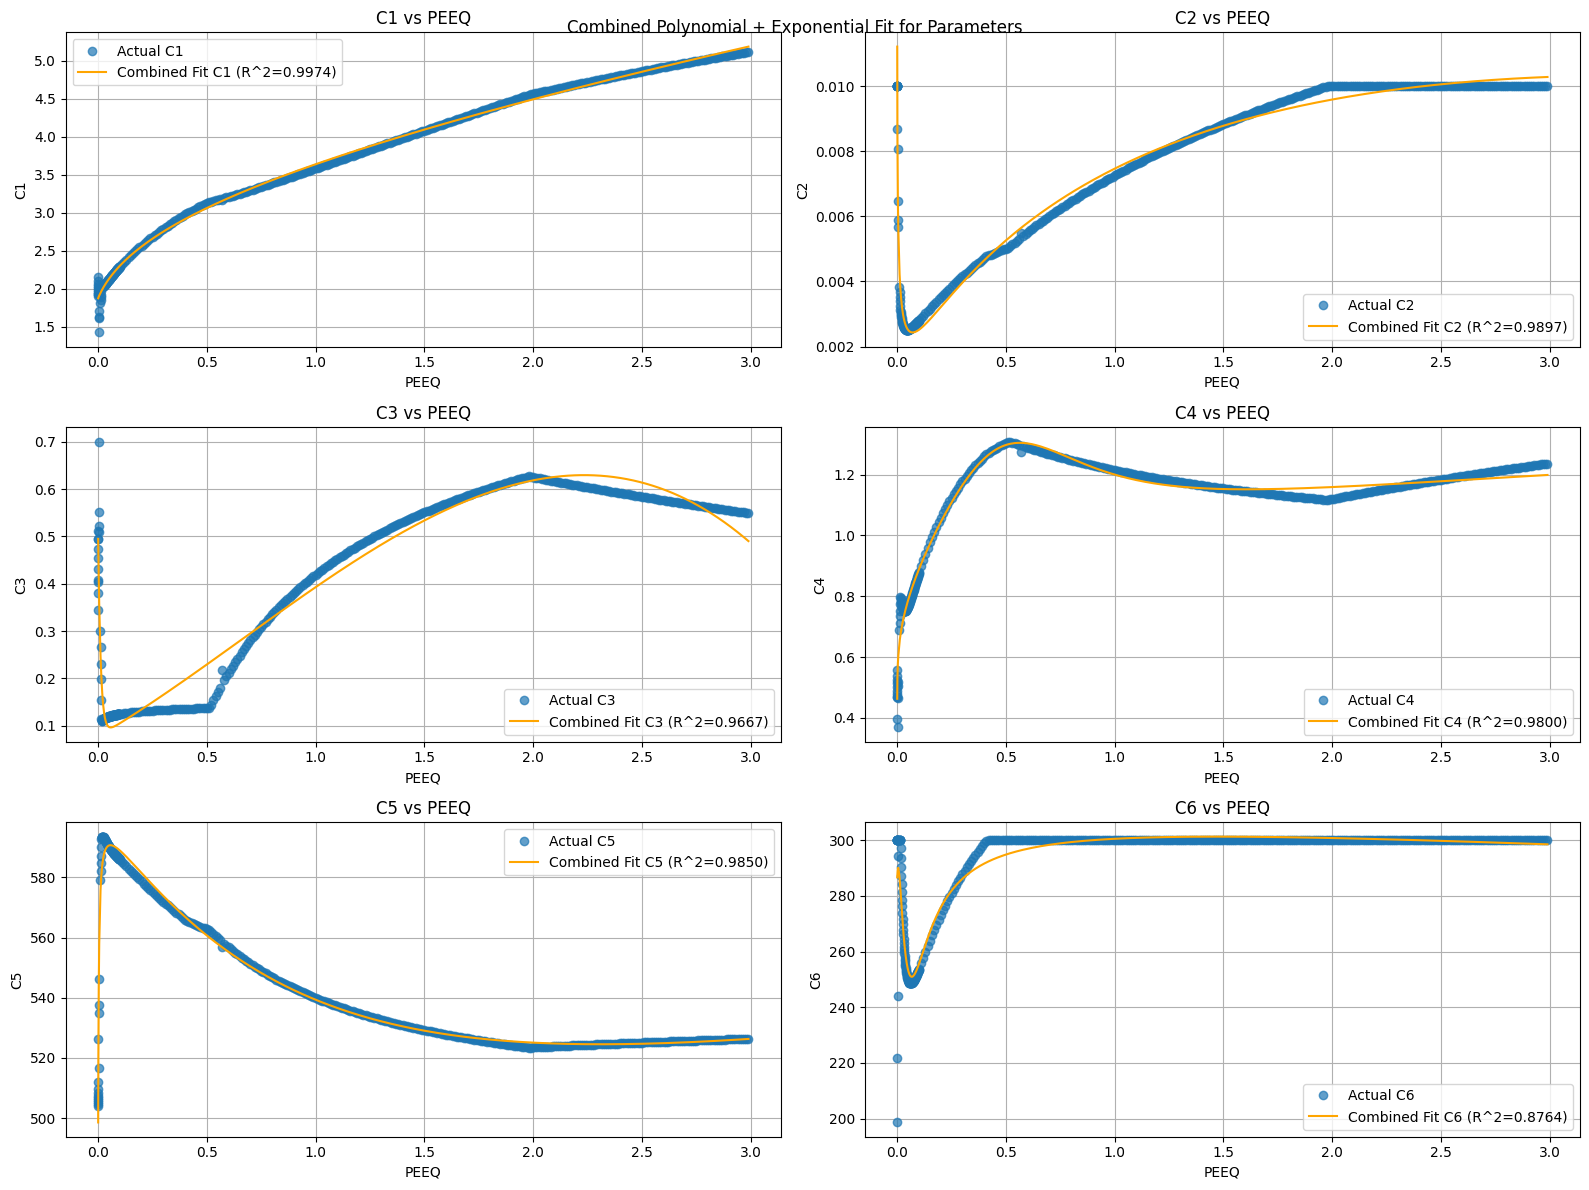

In [21]:
df_para_fit = pd.DataFrame(PEEQ, columns=["PEEQ"])

# Define the combined polynomial + exponential function
def combined_fit(x, a, b, c, d, e, f, C):
    if C == 'C4' or C == 'C2' or C == 'C1':
        return (a*x)/(x**b + c) + d + e * (x**f)
    elif C == 'C5' or C == 'C6': 
        return (a * (x**2) + b * x + c)/(d*x + 1) + e * np.exp(-f * x)
    else :
        return a * (x**3) + b * (x**2) + c * x + d + e * np.exp(-f * x)

# Function to fit the combined model and calculate R^2 score
def fit_combined_model(data, parameter):
    x = data['PEEQ']
    y = data[parameter]
    
    # Apply initial guesses and bounds only for 'C5' and 'C6'
    if parameter in ['C5', 'C6']:
        initial_guess = [100, -50, 580, 1, 50, 1]
        bounds = ([-np.inf, -np.inf, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
        fit_kwargs = {'p0': initial_guess, 'bounds': bounds}
    else:
        fit_kwargs = {}  # No initial guess or bounds for other parameters

    # Fit the combined model
    try:
        popt, _ = curve_fit(lambda x, a, b, c, d, e, f: combined_fit(x, a, b, c, d, e, f, parameter), x, y, maxfev=100000, **fit_kwargs)
        y_pred = combined_fit(x, *popt, parameter)
        r2 = r2_score(y, y_pred)
    except RuntimeError:
        popt = None
        y_pred = None
        r2 = -np.inf  # Indicate failed fit
    
    if popt is not None:
        print(f'Parameter: {parameter}, R^2: {r2:.4f}, Coefficients: {popt}')
    else:
        print(f'Parameter: {parameter} - Fit failed')
    
    return popt, y_pred, r2

# List of parameters to fit
parameters = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Fit models and plot results
plt.figure(figsize=(16, 12))

for i, param in enumerate(parameters):
    popt, y_pred, r2 = fit_combined_model(data, param)
    x = data['PEEQ']
    y_actual = data[param]
    df_para_fit[param] = y_pred
    
    plt.subplot(3, 2, i + 1)
    plt.plot(x, y_actual, 'o', label=f'Actual {param}', alpha=0.7)
    
    # Plot fitted combined model if successful
    if y_pred is not None:
        plt.plot(x, y_pred, '-', color='orange', label=f'Combined Fit {param} (R^2={r2:.4f})')
    
    plt.xlabel('PEEQ')
    plt.ylabel(param)
    plt.title(f'{param} vs PEEQ')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Combined Polynomial + Exponential Fit for Parameters')
plt.show()

In [22]:
df_para_fit.to_csv('para_fit_results_0.0001.csv', index=False)
# Assuming the file is one level up from the current directory
file_path = "Fitted_FC_TmpDpn_RD_StrRt0.0001_ref.csv"
stress_data = pd.read_csv(file_path)

fitted_para = pd.read_csv('para_fit_results_0.0001.csv')

[1.36251004 0.72599133 0.4815976  0.72841393 0.82948758 0.82191691
 0.57495016]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


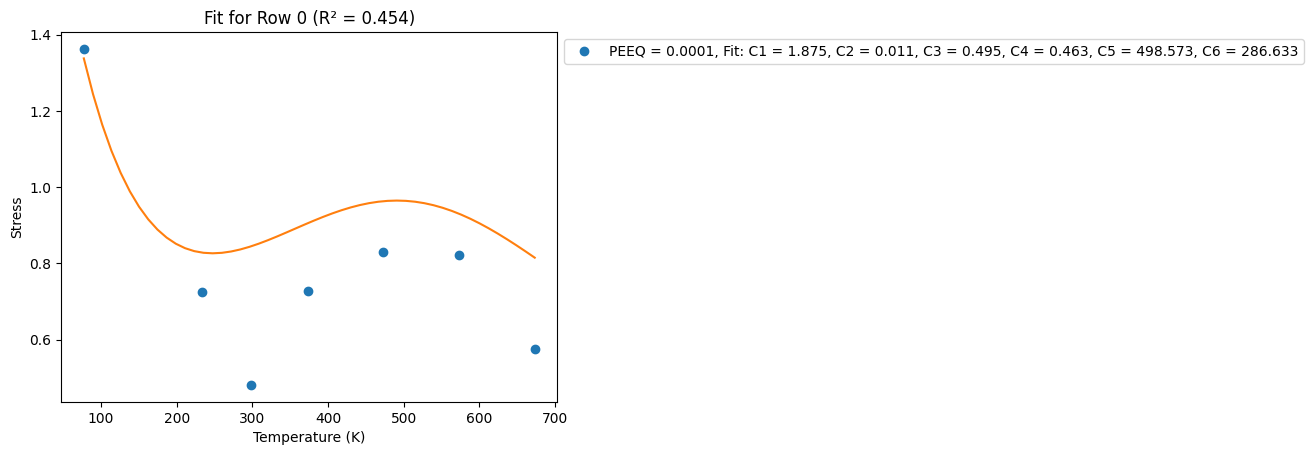

[1.4088003  0.78823669 0.80236574 0.84141439 0.9144373  0.88482855
 0.7604725 ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


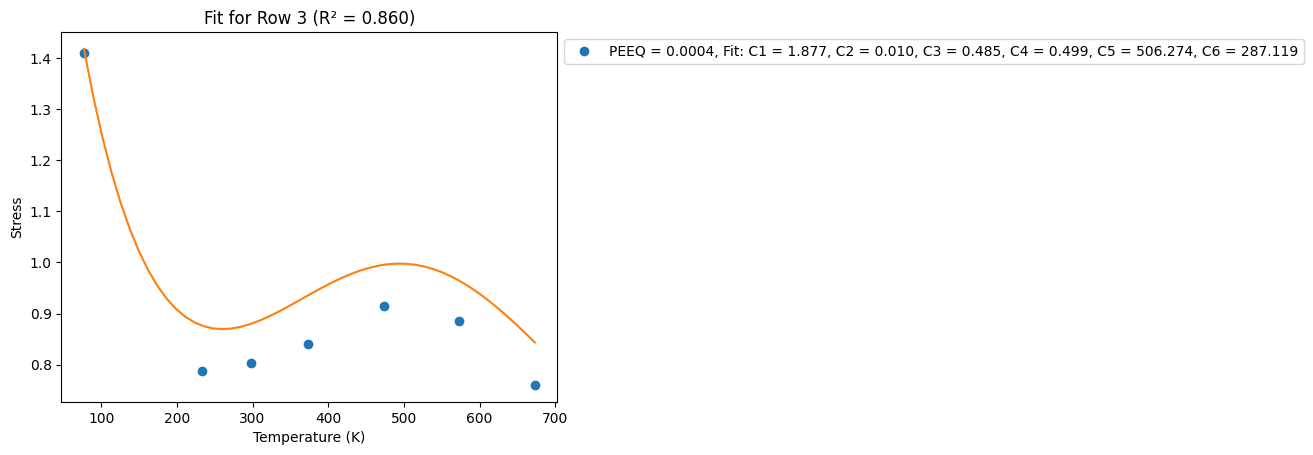

[1.43798219 0.83988294 0.87162077 0.88972207 0.95852643 0.92485234
 0.81279316]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


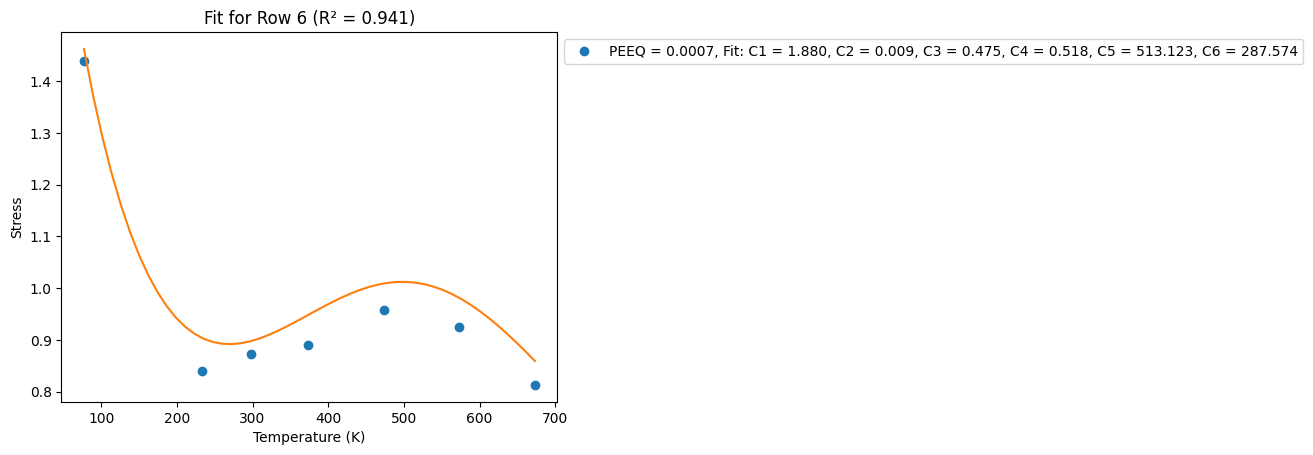

[1.46116835 0.88326191 0.91149156 0.92143296 0.9869516  0.953765
 0.84521133]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


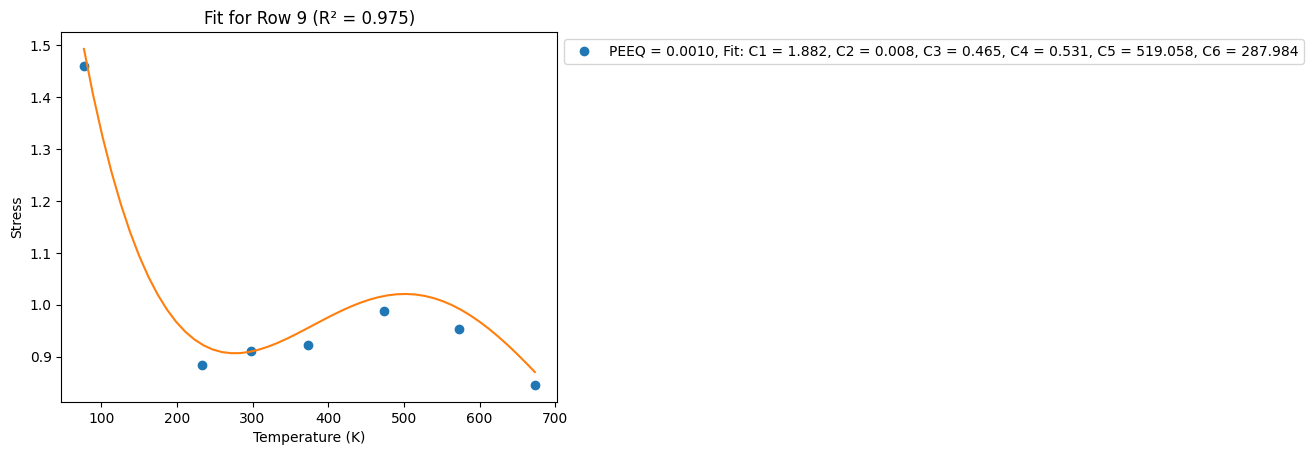

[1.56284214 1.05834586 1.04711581 1.02881016 1.08750725 1.05704757
 0.94991592]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


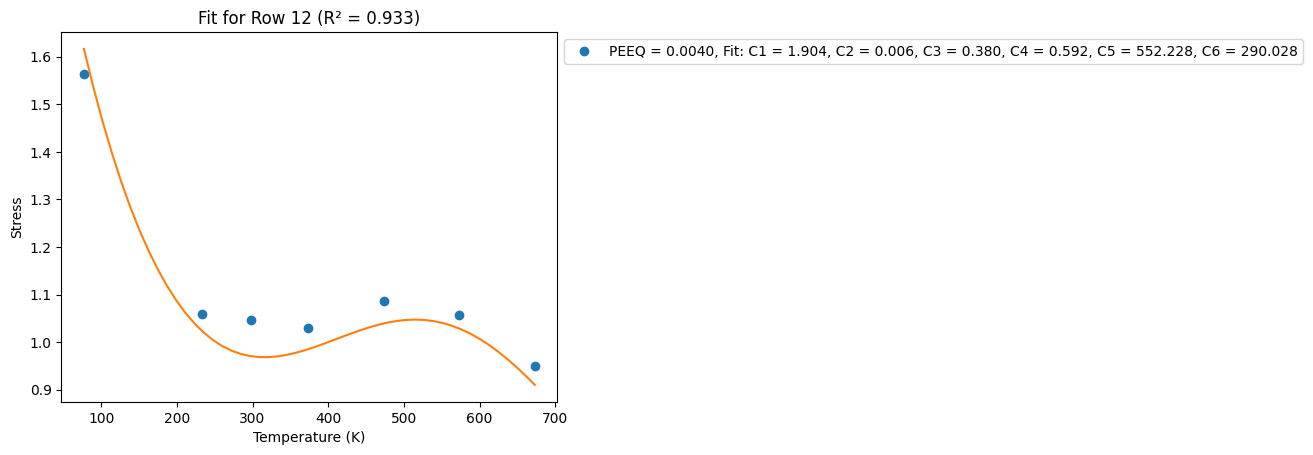

[1.69361316 1.2197177  1.18081648 1.15389214 1.21047734 1.19093161
 1.06323152]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


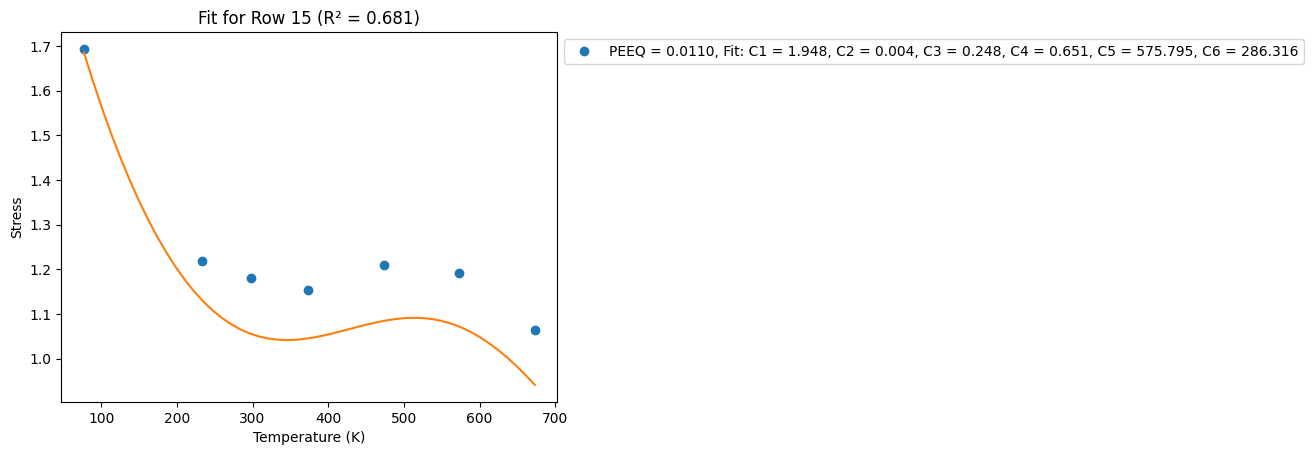

[1.7209566  1.2500482  1.20743061 1.18183176 1.2380837  1.22371858
 1.08681534]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


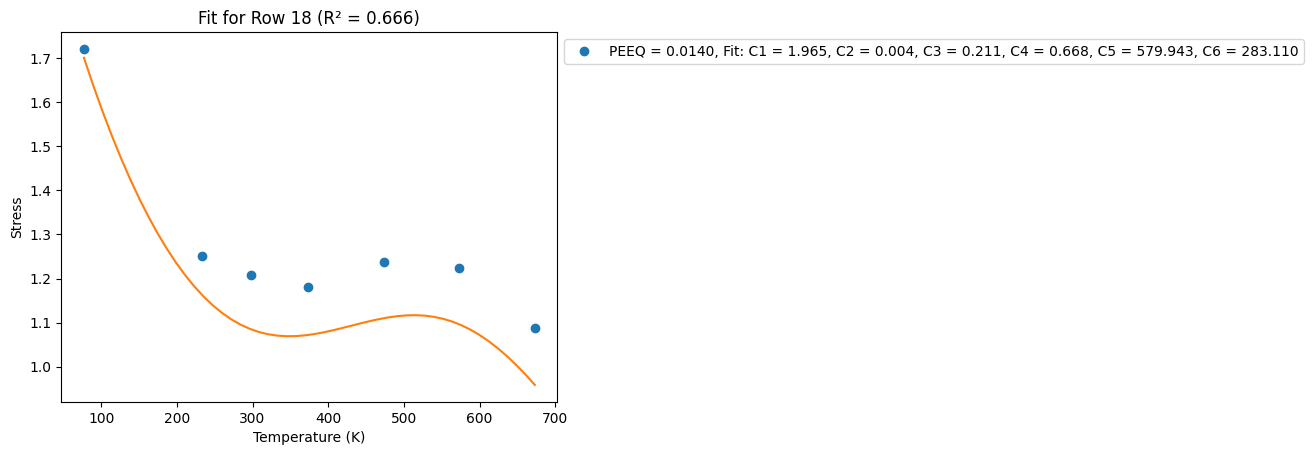

[1.74257942 1.27420198 1.22771379 1.20345841 1.25985303 1.24984368
 1.10475877]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


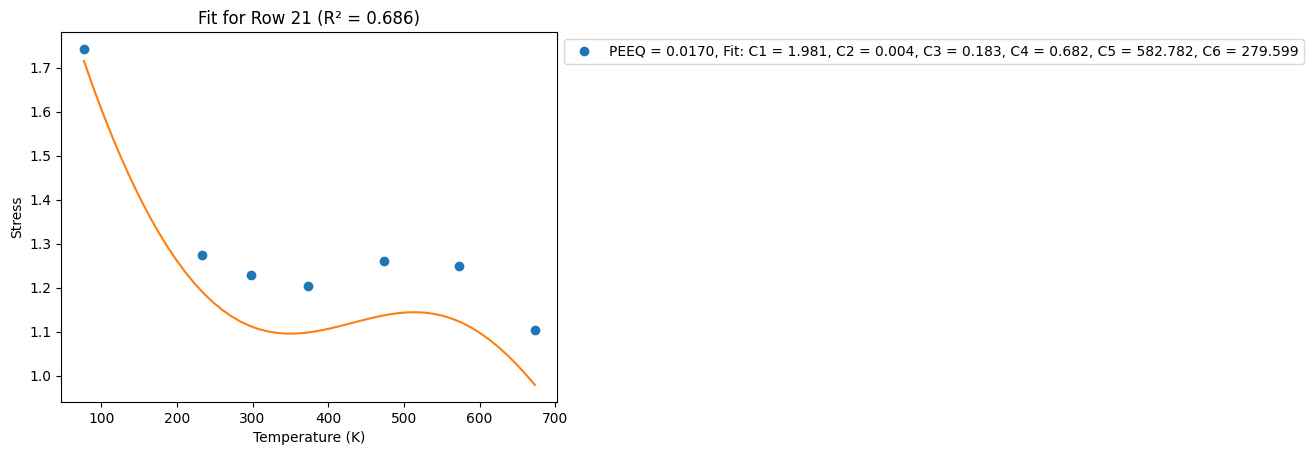

[1.76083908 1.29431158 1.24396878 1.22085456 1.27776823 1.27143681
 1.11912256]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


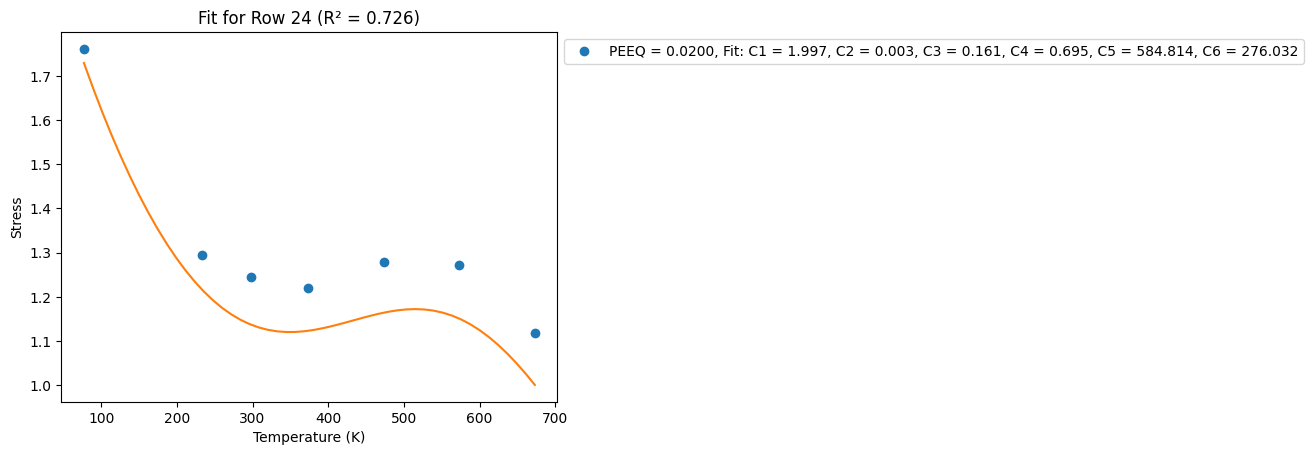

[1.77689696 1.31135823 1.25745235 1.23526187 1.29295469 1.28978721
 1.13106695]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


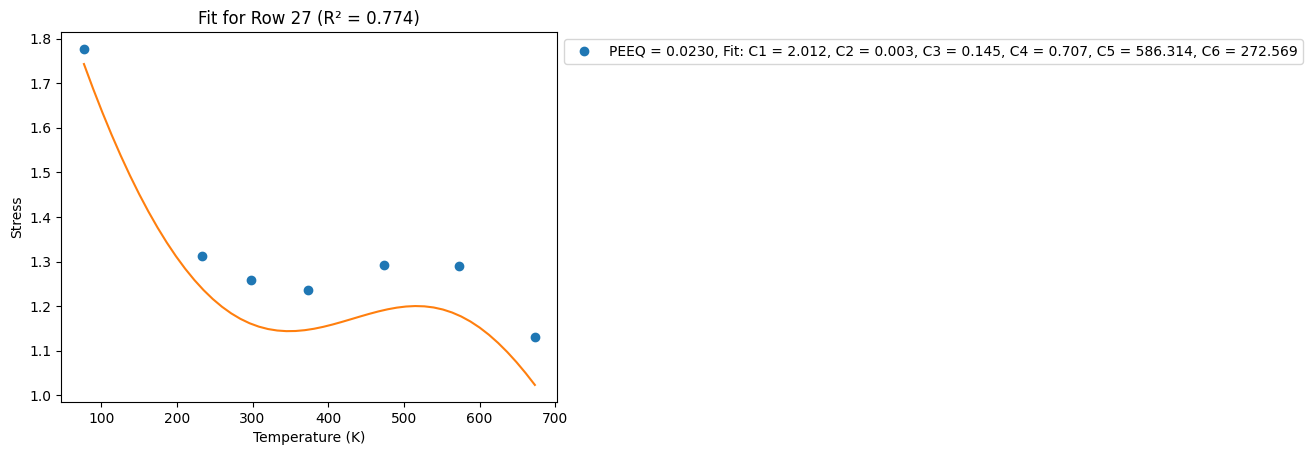

[1.79137792 1.32593264 1.26892168 1.24747859 1.30611125 1.30571746
 1.14129182]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


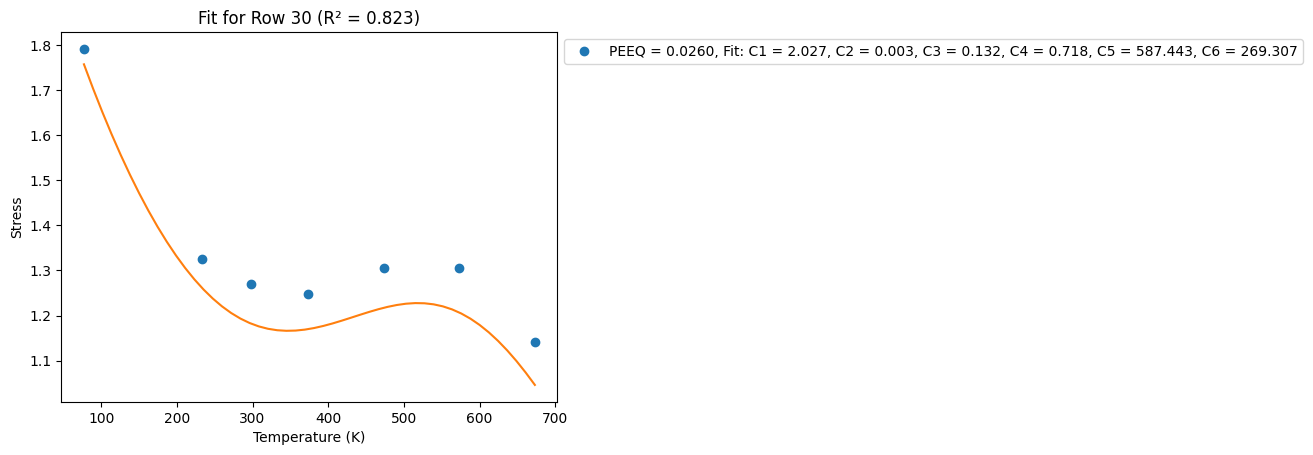

[1.80465079 1.33846509 1.27886636 1.25804341 1.31770094 1.31977781
 1.15024167]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


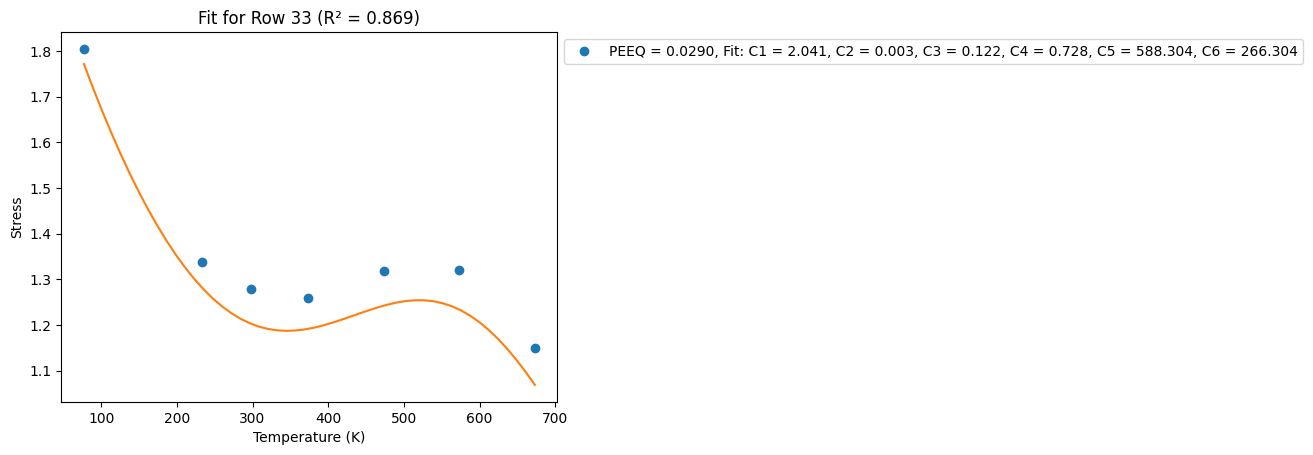

[1.81695326 1.34929878 1.28762013 1.26733252 1.32804598 1.33235217
 1.1582112 ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


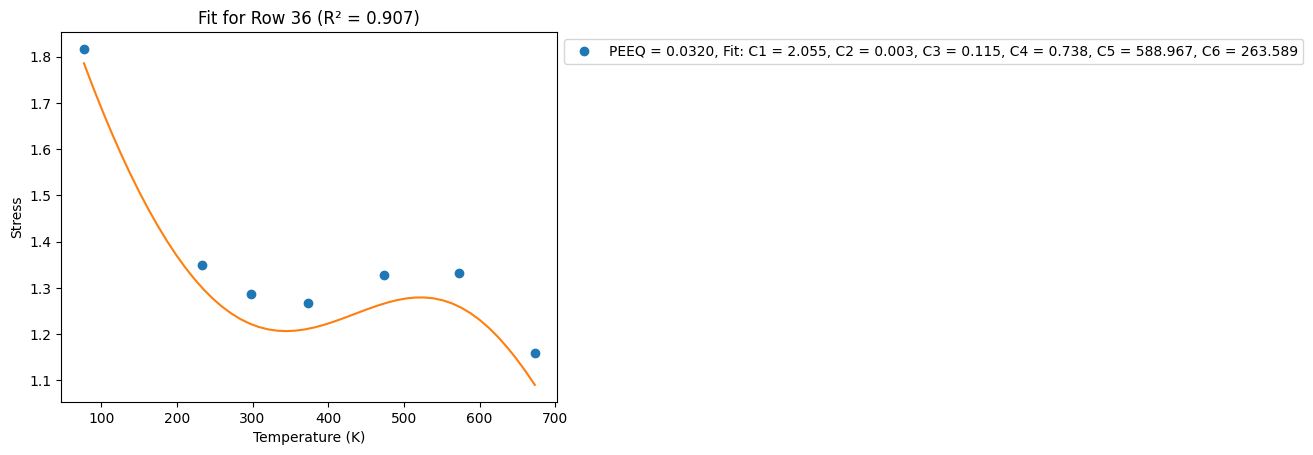

[1.82845034 1.35871584 1.29542015 1.27561559 1.33737939 1.34371821
 1.16540351]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


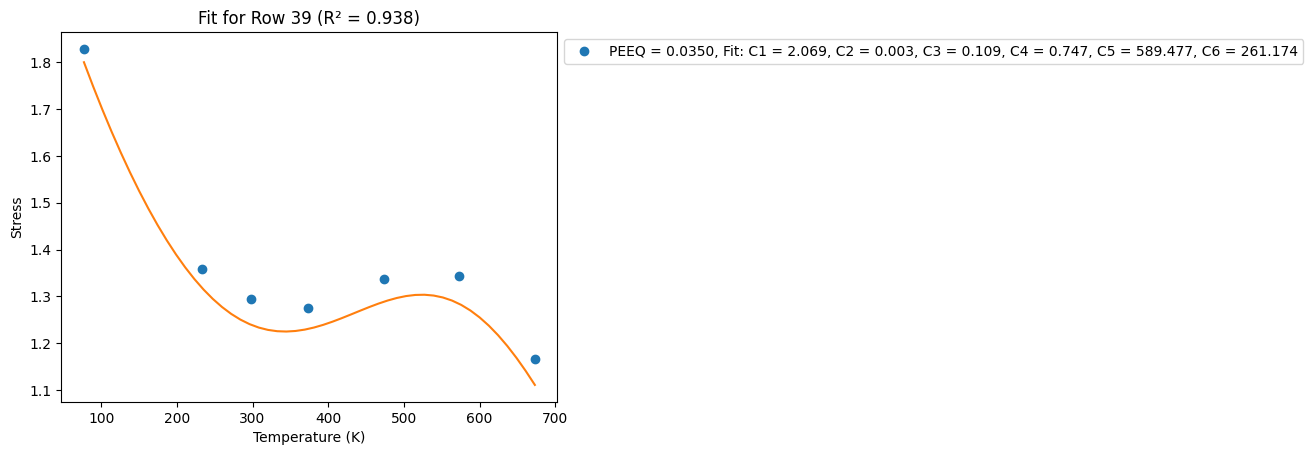

[1.83926348 1.36694947 1.3024406  1.28309014 1.34587501 1.35408299
 1.17196351]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


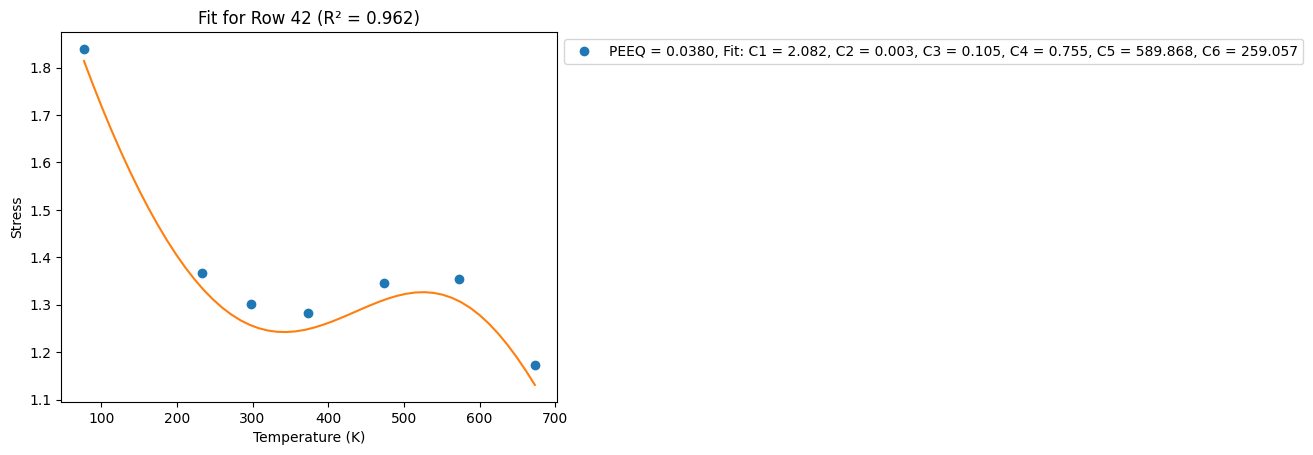

[1.84948588 1.37419193 1.30881299 1.28990356 1.35366587 1.36360489
 1.17799798]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


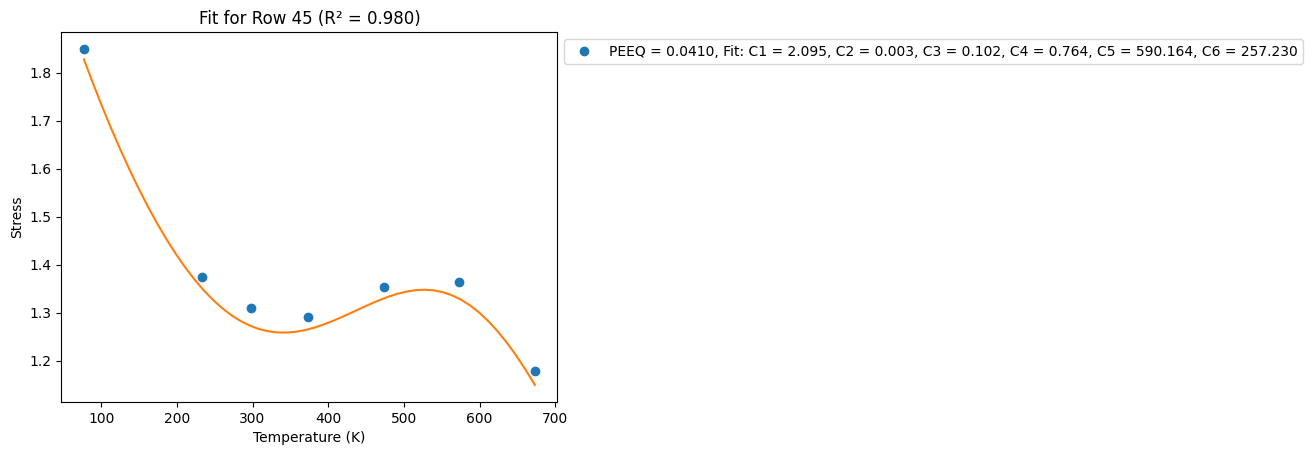

[1.85919142 1.38060124 1.31463887 1.29616773 1.36085598 1.37240774
 1.18358782]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


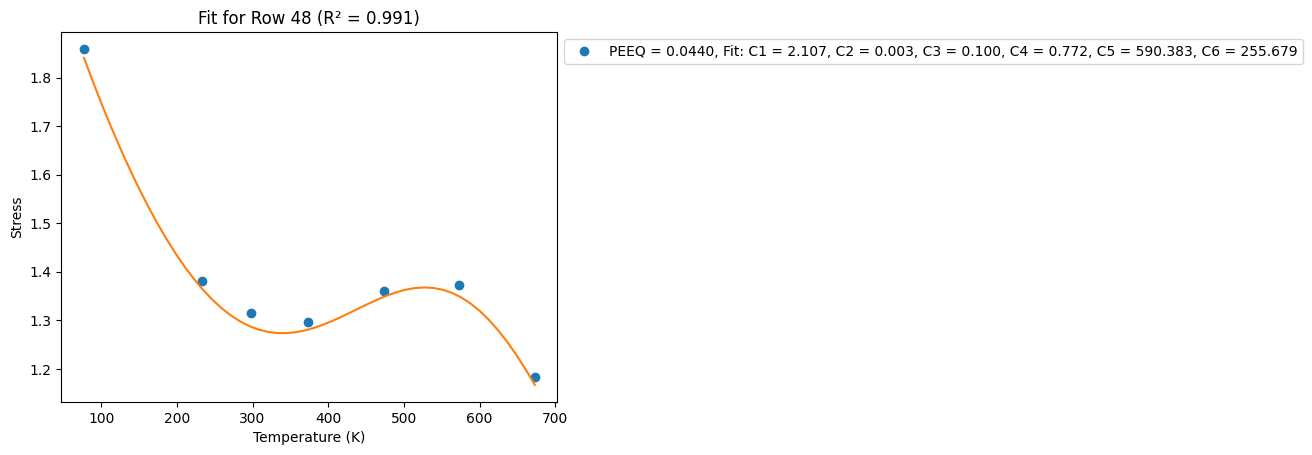

[1.86843995 1.38630701 1.3199982  1.30196892 1.36752816 1.38059012
 1.18879593]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


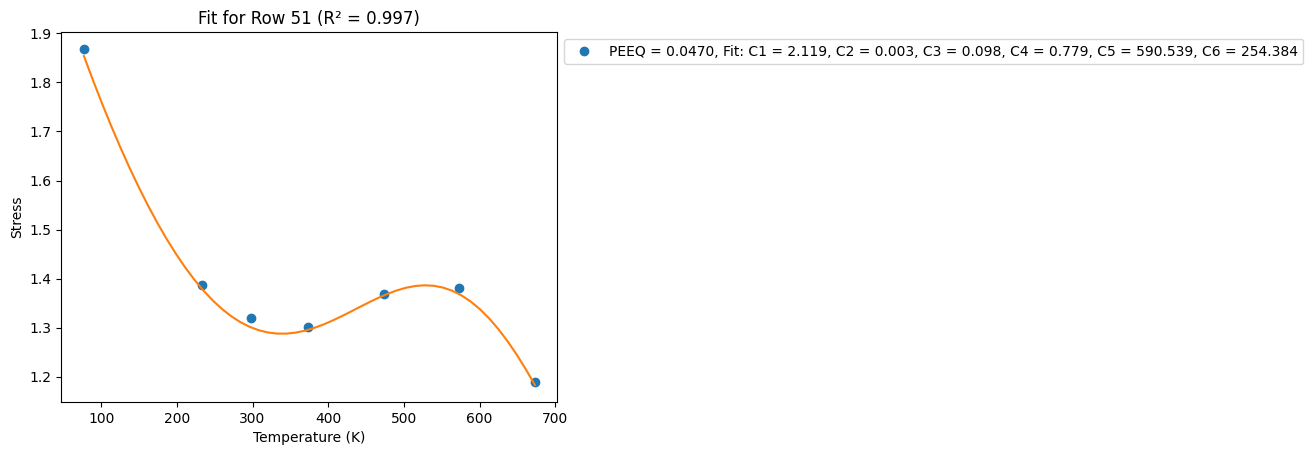

[1.87728091 1.39141556 1.32495501 1.30737468 1.3737494  1.38823177
 1.19367229]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


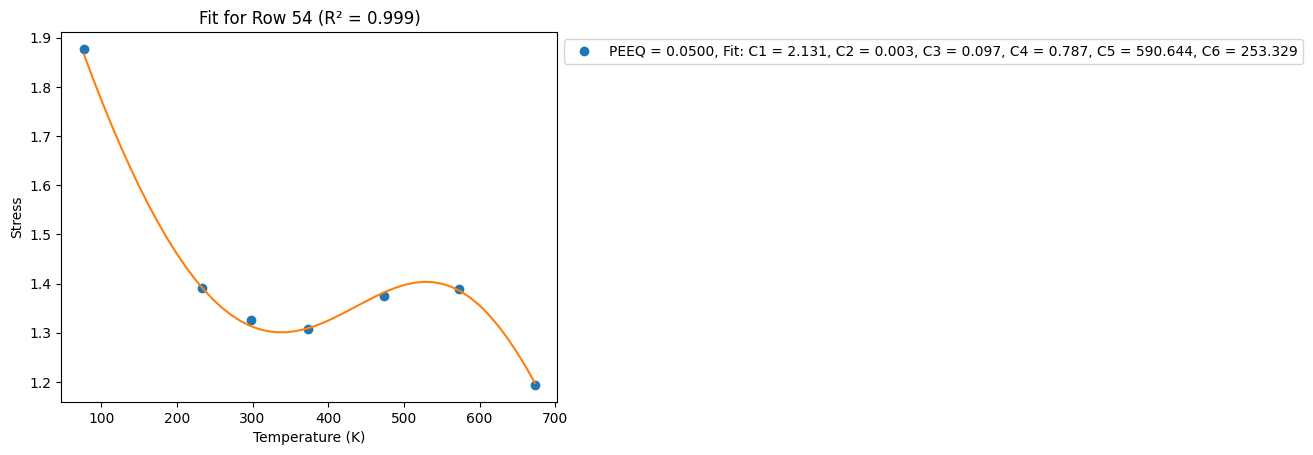

[1.88575564 1.39601421 1.32956129 1.31243865 1.37957464 1.39539813
 1.19825733]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


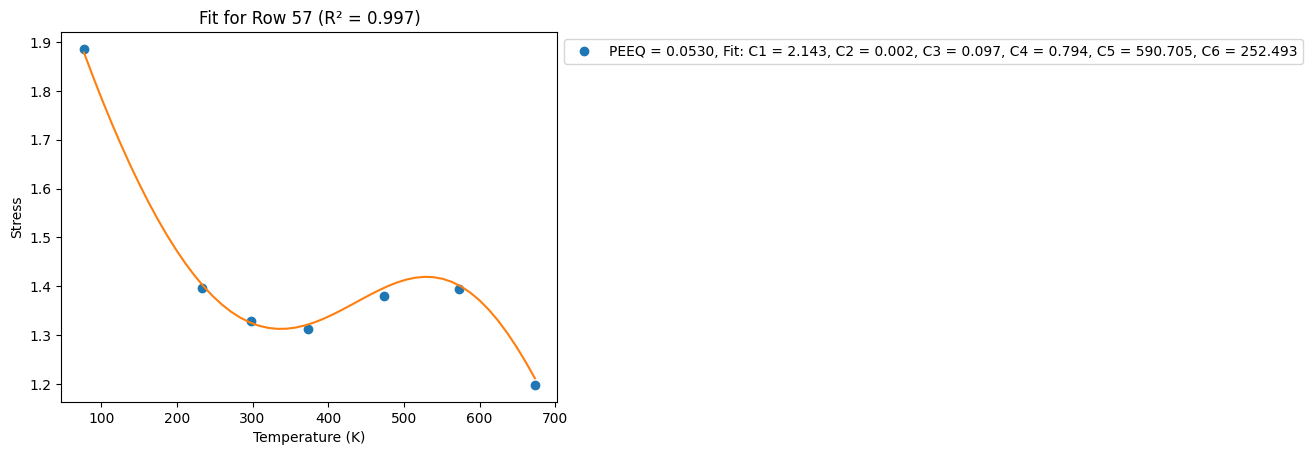

[1.89389919 1.40017497 1.33385983 1.31720403 1.38504945 1.40214349
 1.20258433]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


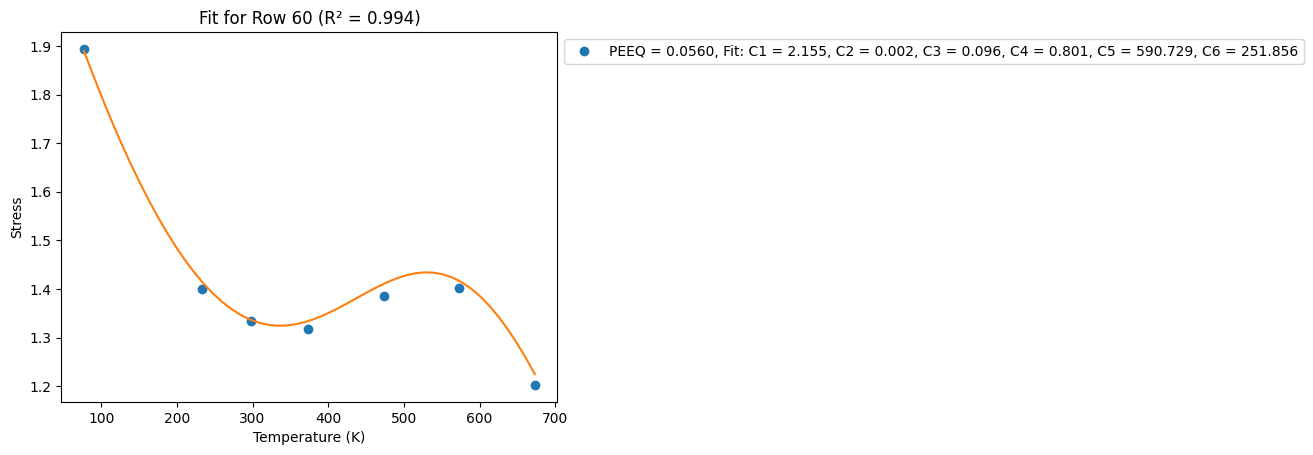

[1.90174153 1.40395739 1.33788622 1.32170608 1.39021208 1.40851342
 1.20668107]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


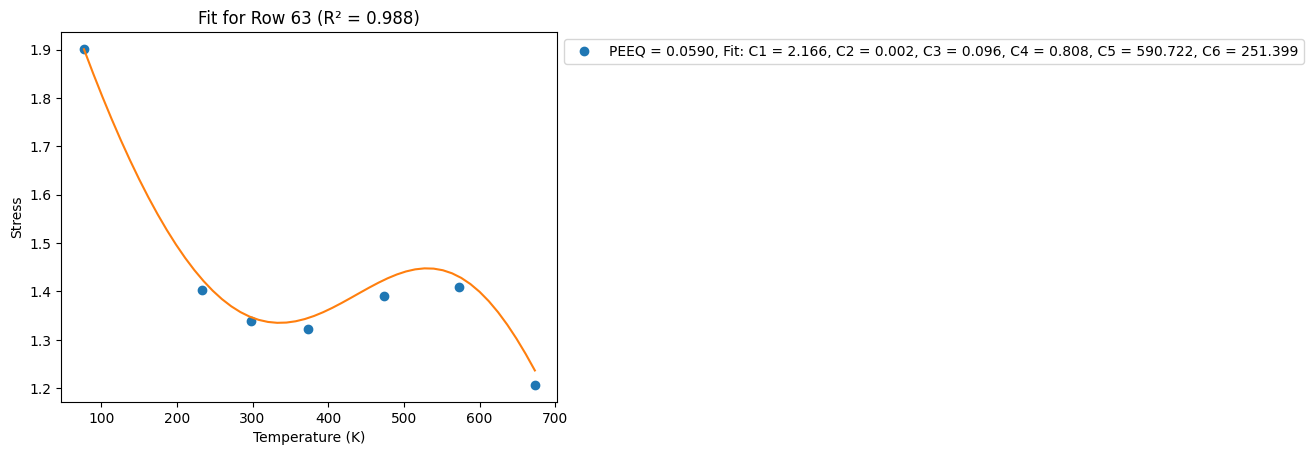

[1.90930854 1.40741103 1.34167038 1.32597389 1.3950949  1.41454653
 1.21057096]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


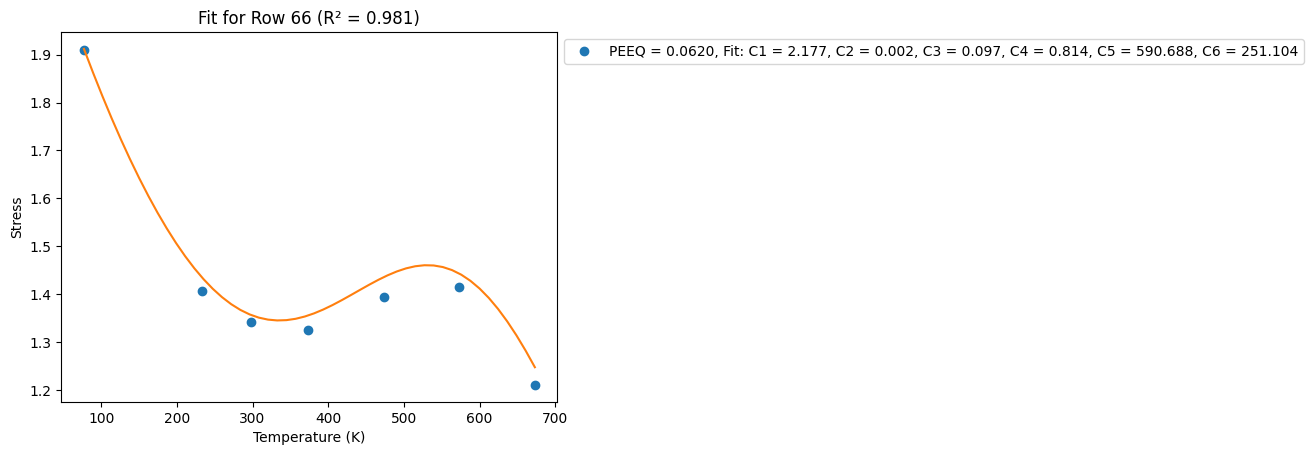

[1.91662273 1.41057732 1.34523766 1.33003181 1.39972556 1.42027581
 1.21427399]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


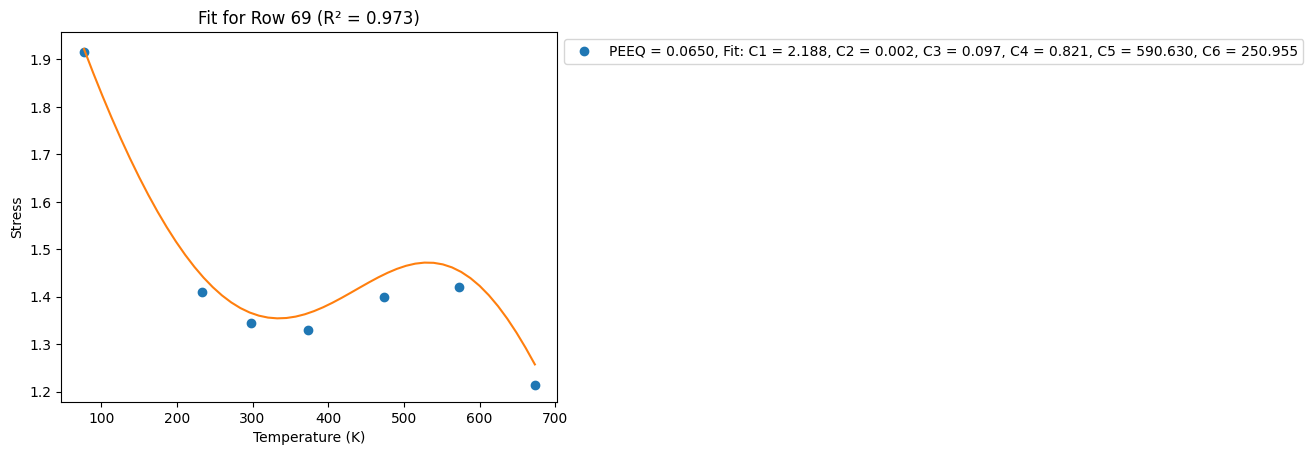

[1.9237038  1.41349109 1.34860974 1.33390038 1.40412786 1.42572966
 1.21780735]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


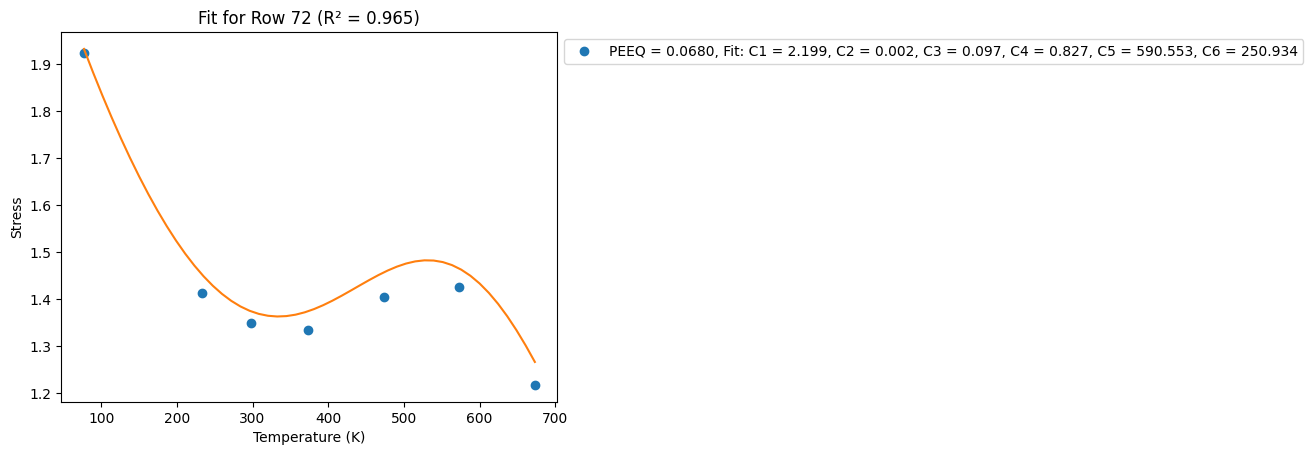

[1.93056912 1.41618183 1.35180529 1.33759713 1.40832242 1.43093272
 1.22118593]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


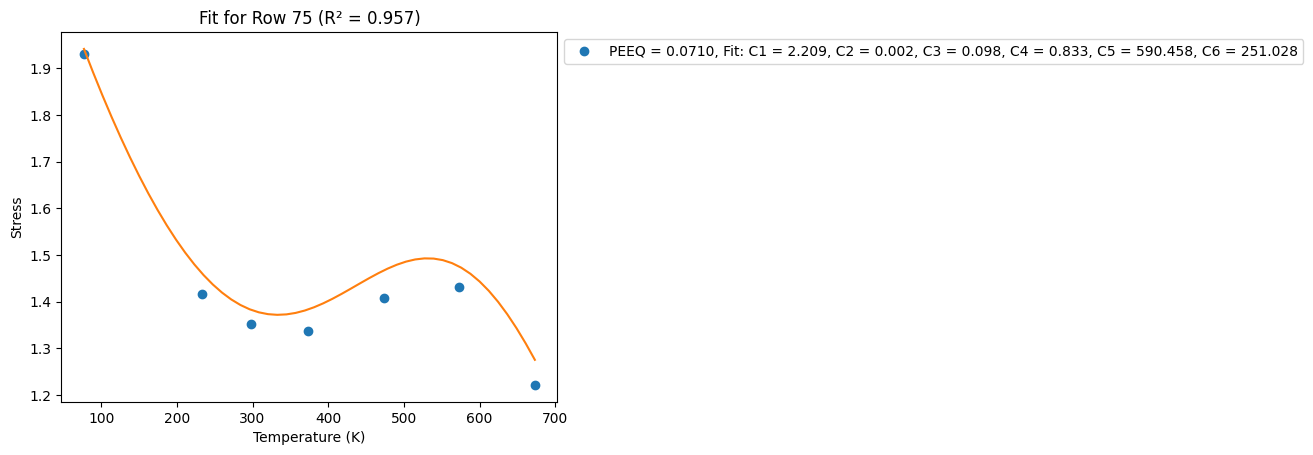

[1.93723411 1.4186746  1.35484049 1.34113716 1.41232721 1.43590647
 1.22442276]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


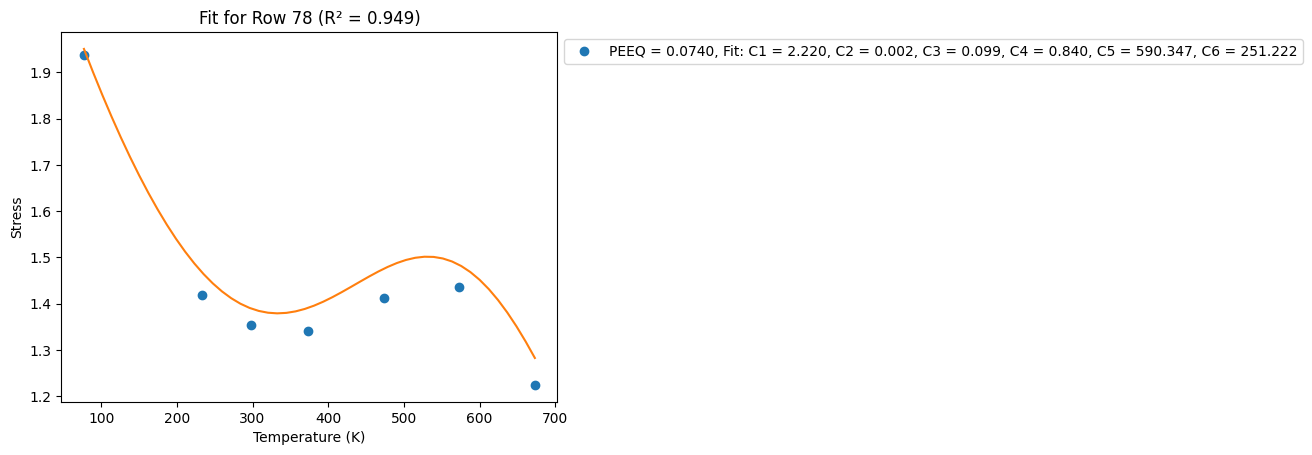

[1.94371247 1.42099086 1.35772945 1.34453356 1.41615802 1.44066979
 1.22752925]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


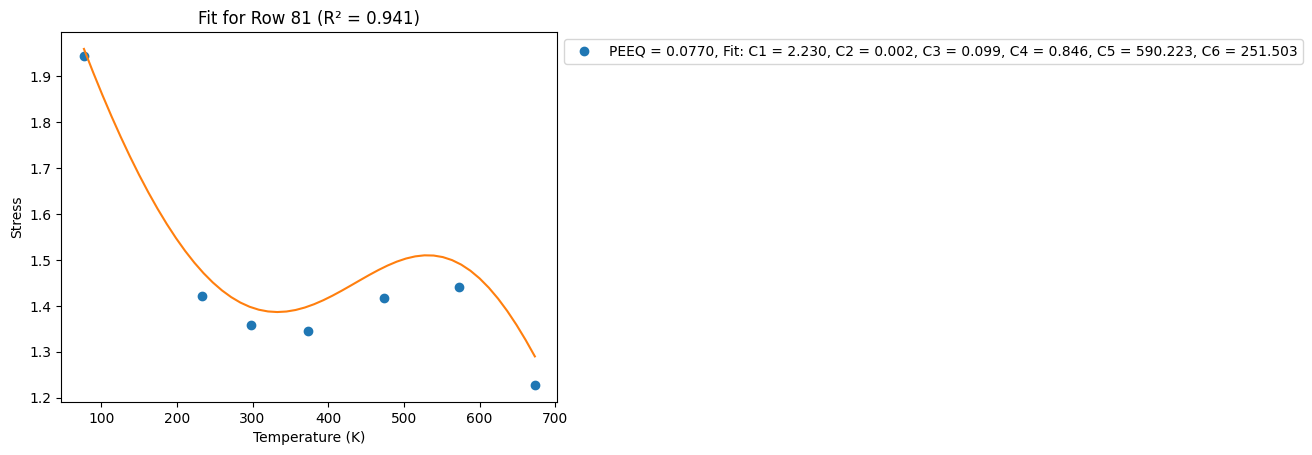

[1.9500165  1.42314905 1.36048455 1.3477978  1.41982875 1.44523932
 1.23051552]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


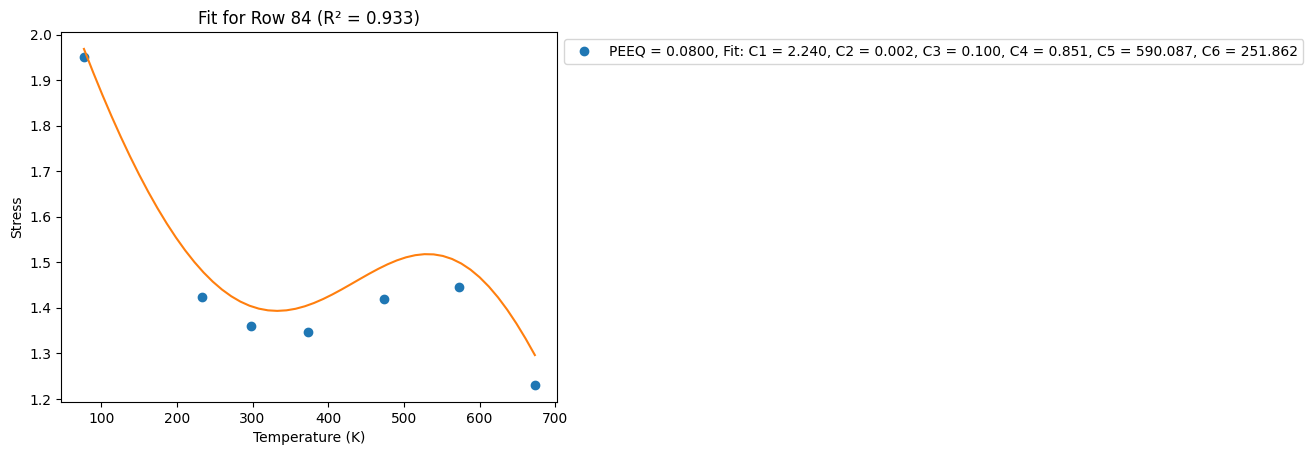

[1.95615723 1.42516514 1.3631167  1.35093997 1.42335174 1.44962983
 1.23339051]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


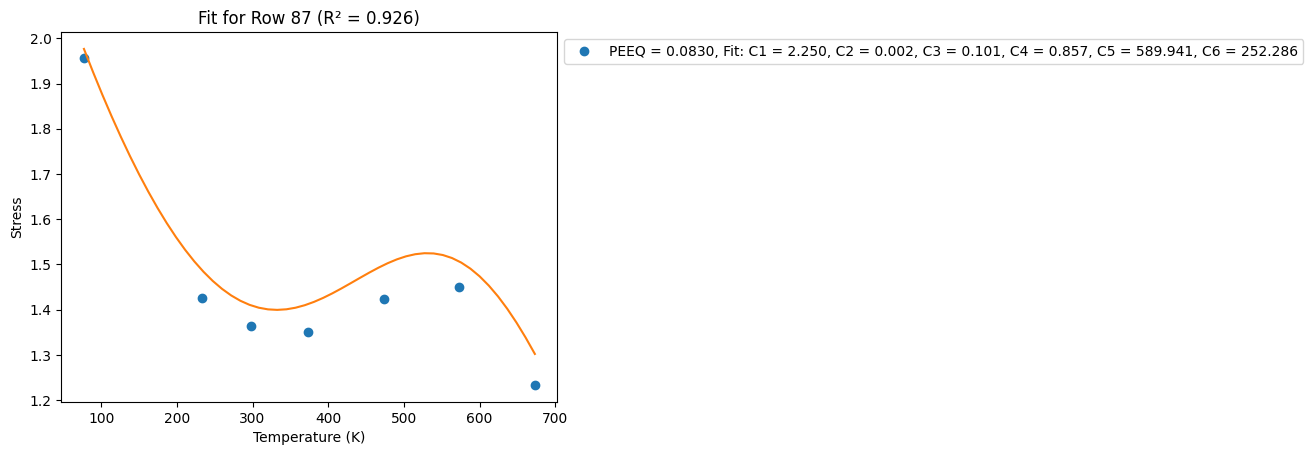

[1.96214465 1.42705298 1.36563557 1.353969   1.42673795 1.45385447
 1.23616224]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


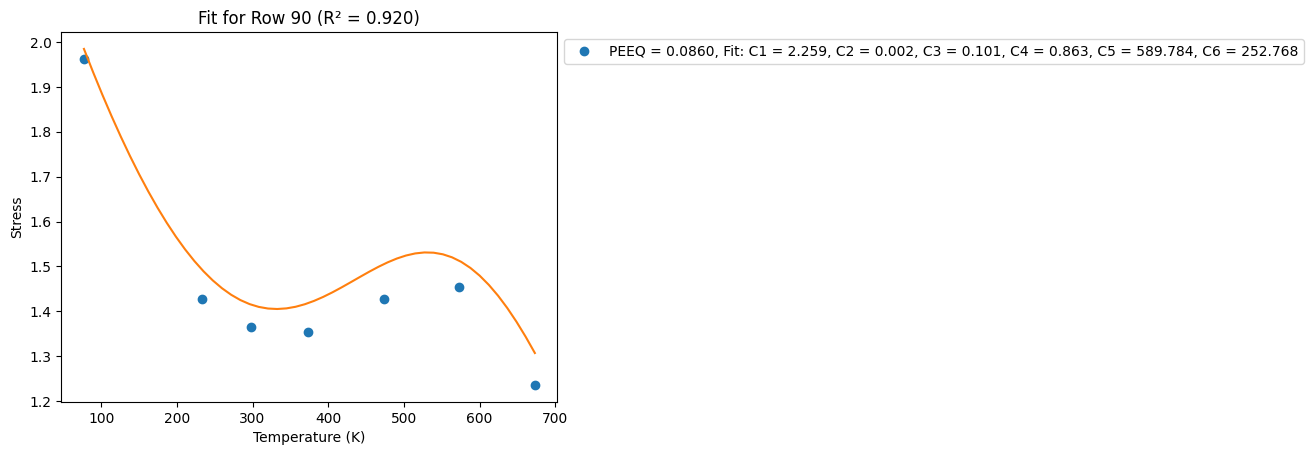

[1.96798778 1.42882468 1.36804976 1.35689287 1.4299972  1.457925
 1.23883786]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


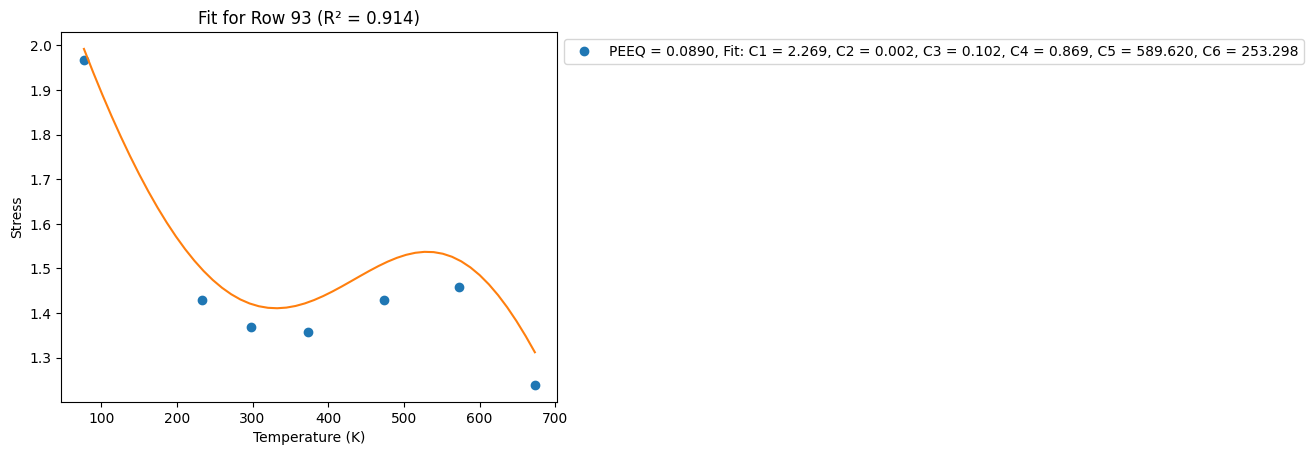

[1.97369485 1.43049085 1.37036695 1.3597187  1.43313829 1.46185199
 1.24142382]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


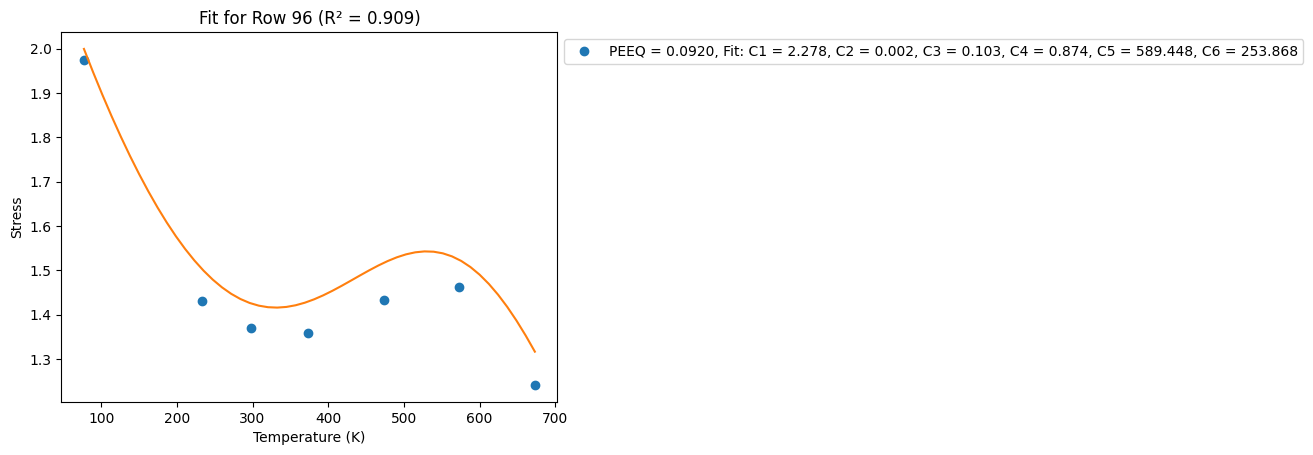

[1.97927335 1.43206085 1.37259402 1.36245291 1.43616916 1.46564497
 1.24392594]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


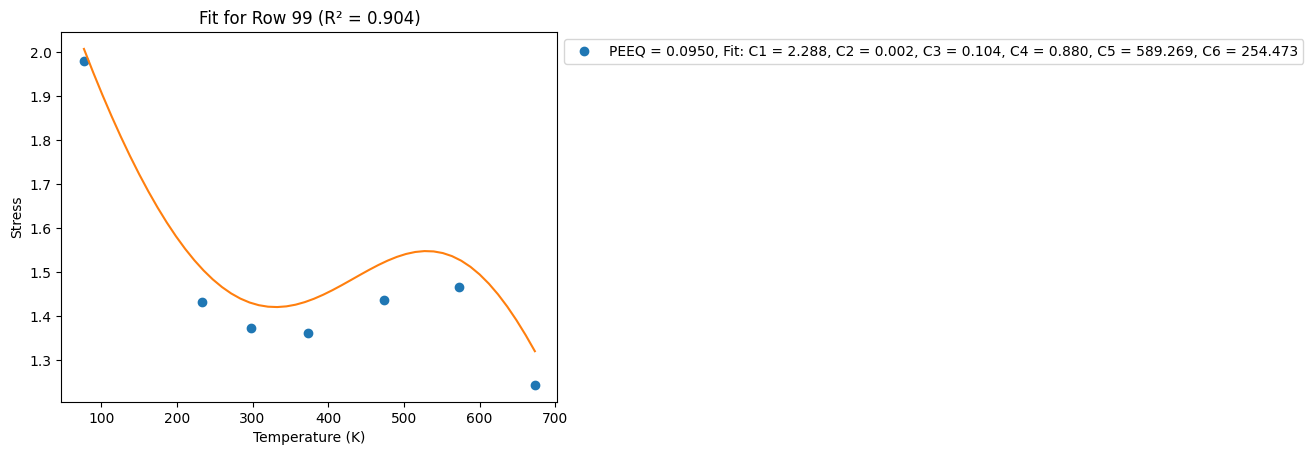

[1.98473014 1.43354294 1.37473719 1.36510129 1.43909698 1.46931255
 1.24634947]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


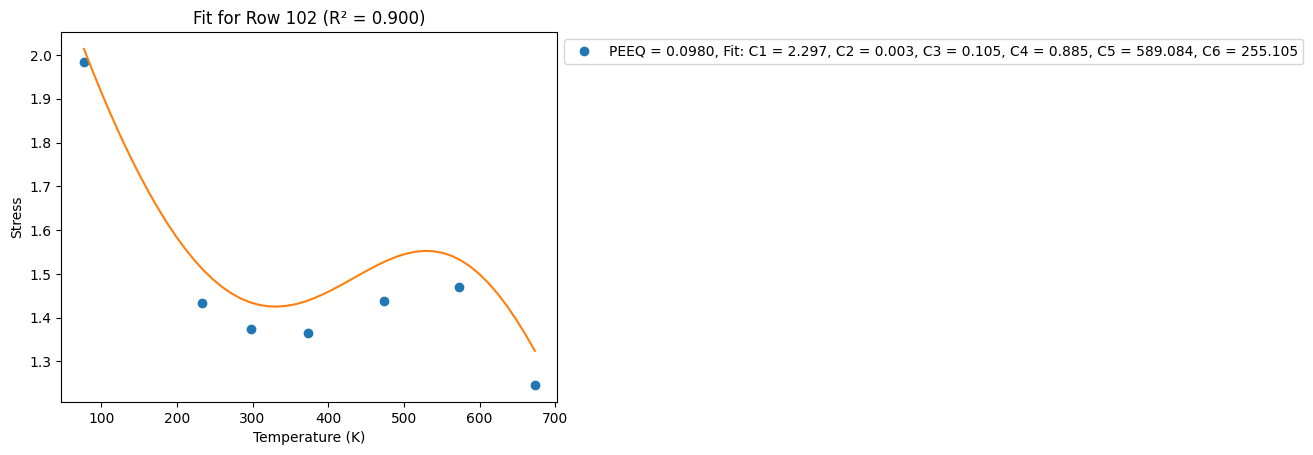

[1.99007152 1.43494446 1.37680205 1.3676691  1.44192825 1.47286255
 1.24869921]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


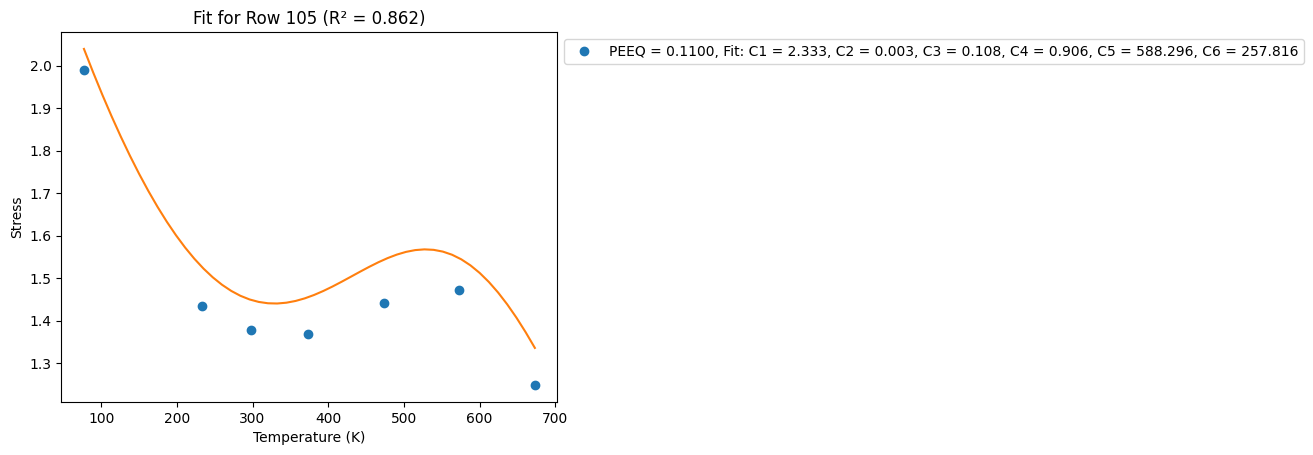

[2.03822165 1.44568235 1.39406686 1.3897932  1.46601438 1.50320096
 1.26894021]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


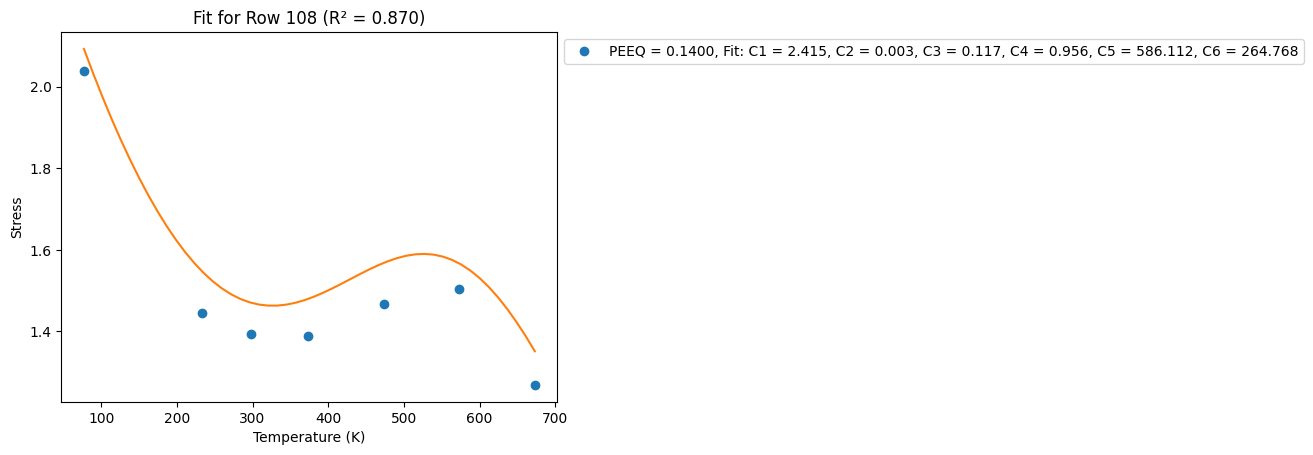

[2.07919226 1.45268465 1.40708782 1.40731097 1.48469245 1.52690495
 1.28496065]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


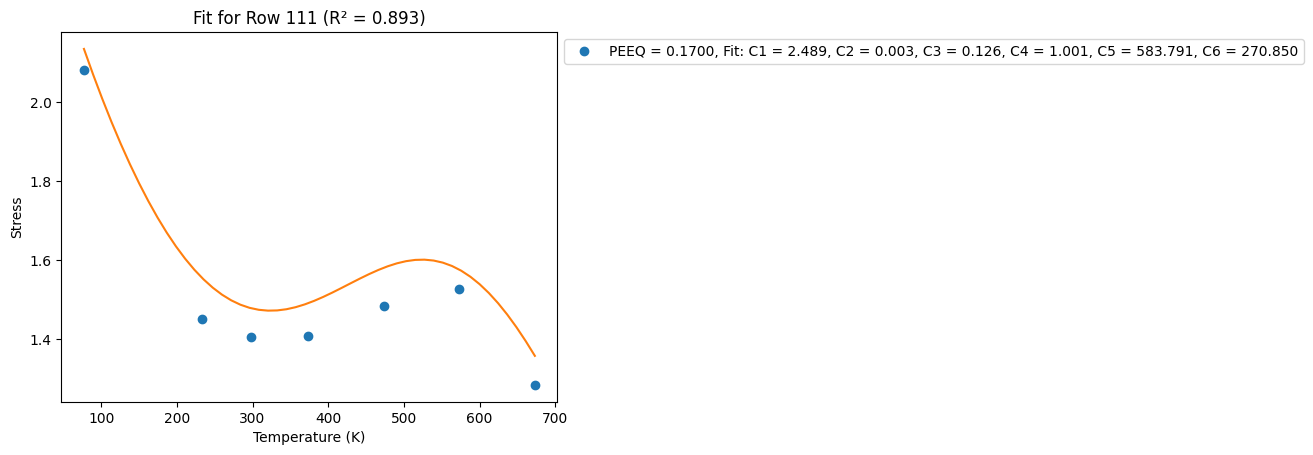

[2.11514448 1.45763383 1.41745147 1.42181478 1.49989444 1.5463179
 1.29822057]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


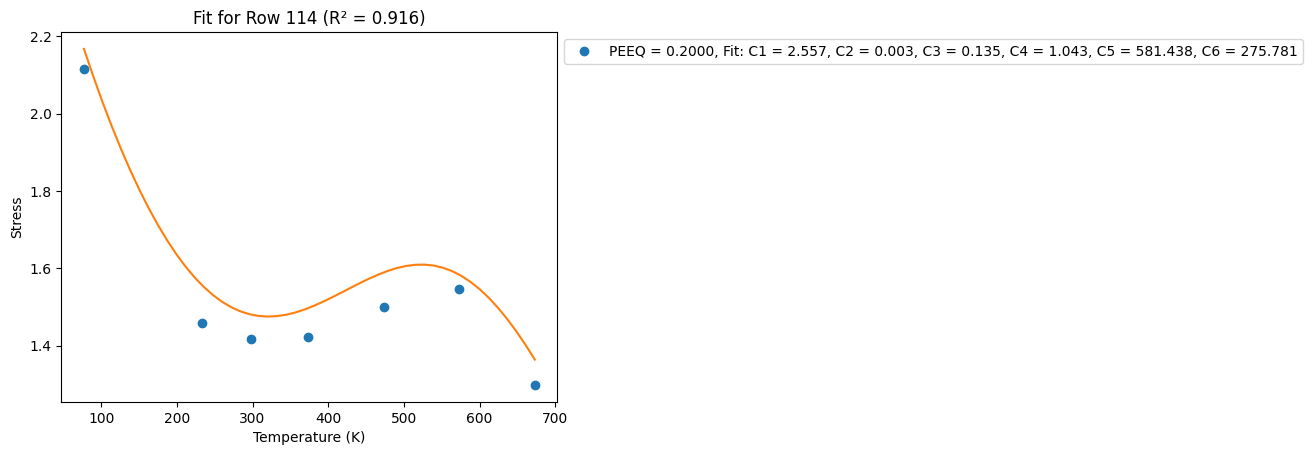

[2.14735859 1.46132891 1.4260065  1.43419149 1.51267988 1.56273182
 1.30953298]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


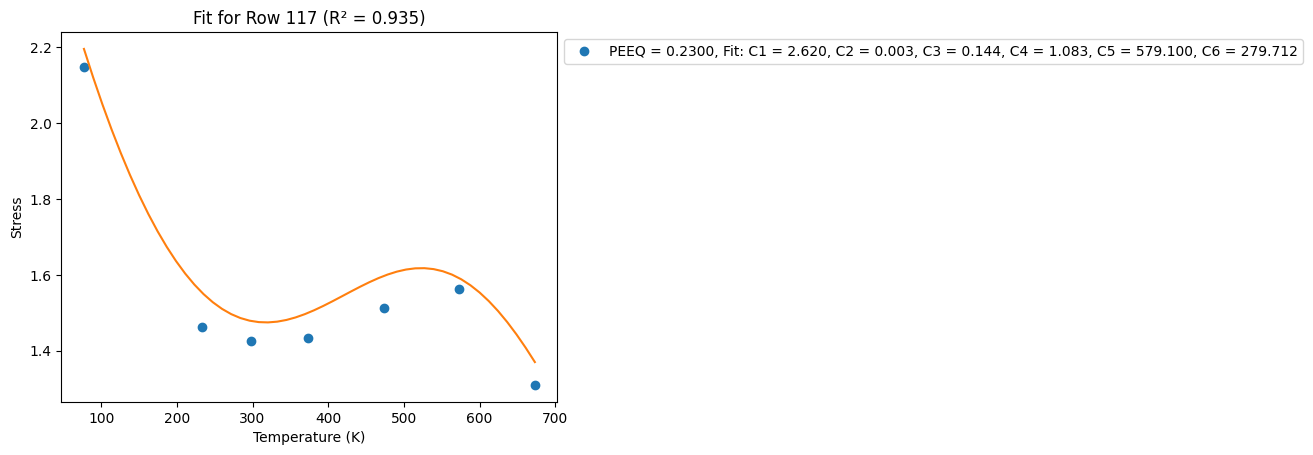

[2.17666243 1.46419959 1.43325726 1.44498622 1.52369129 1.57693386
 1.31939737]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


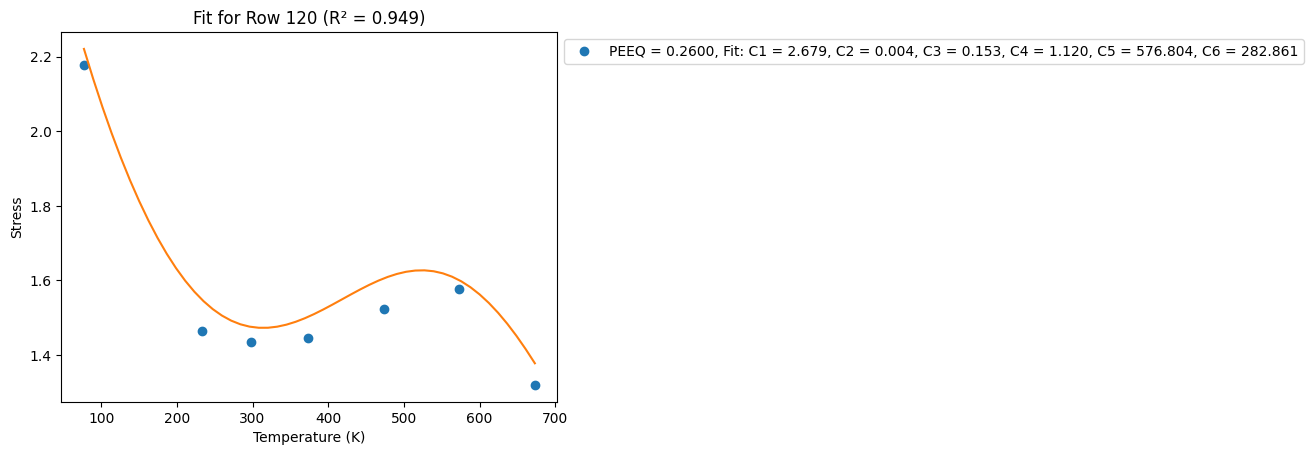

[2.20362553 1.46649816 1.43952656 1.45455811 1.53334706 1.58943865
 1.32814277]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


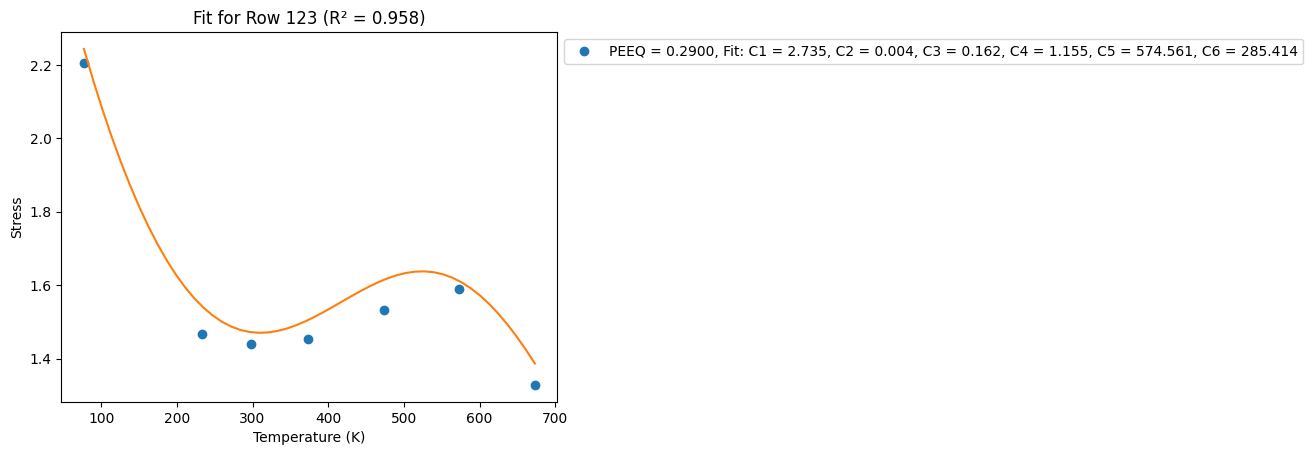

[2.22865829 1.46838283 1.44503277 1.46315636 1.54193442 1.60060087
 1.33599737]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


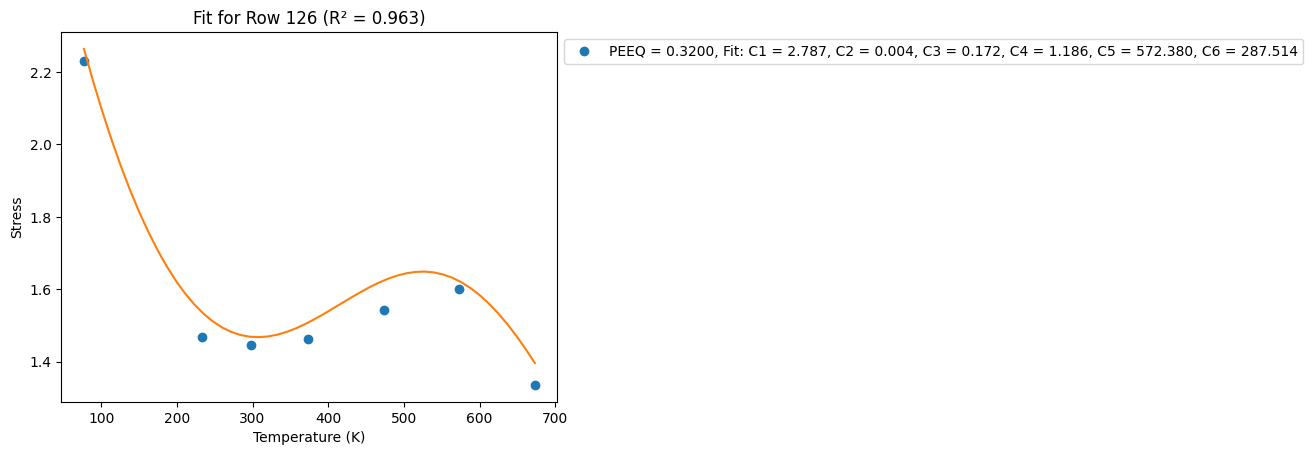

[2.25206728 1.46995797 1.44993012 1.47096098 1.54965892 1.61067515
 1.343126  ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


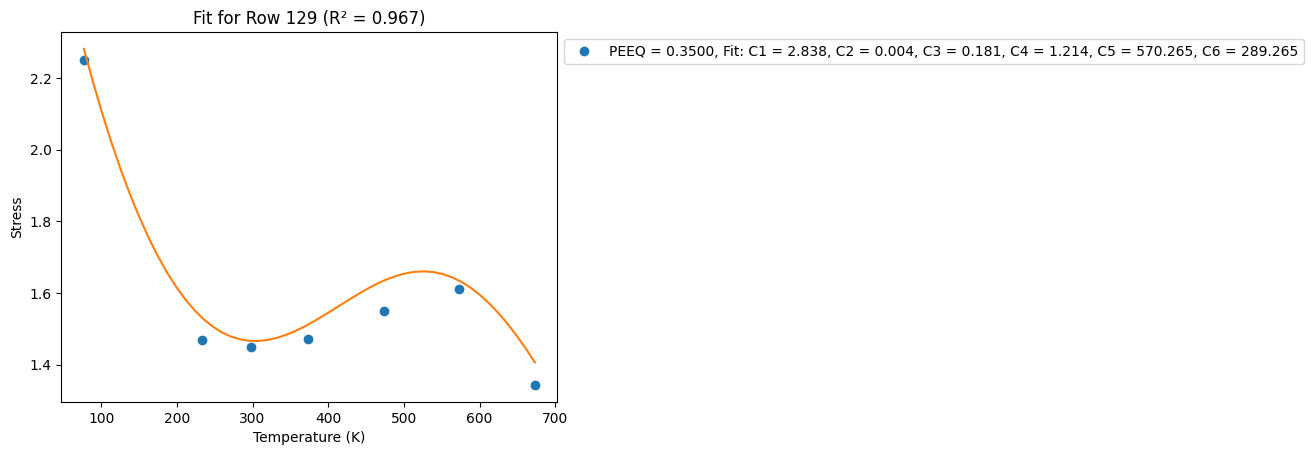

[2.27408818 1.47129532 1.45433133 1.47810626 1.55667257 1.61985041
 1.34965158]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


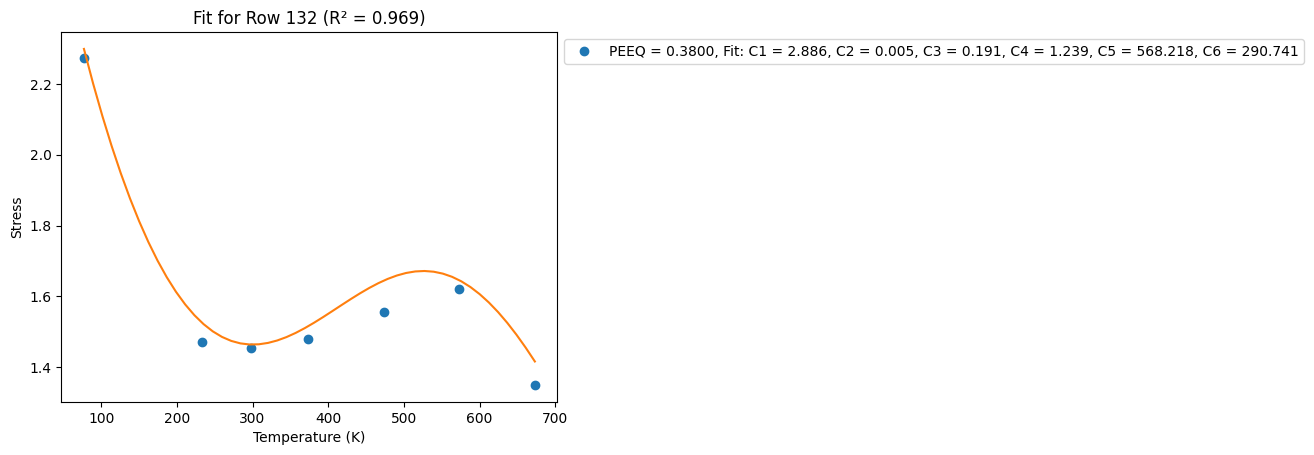

[2.29490652 1.4724459  1.45832114 1.48469501 1.56309088 1.62827058
 1.35566824]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


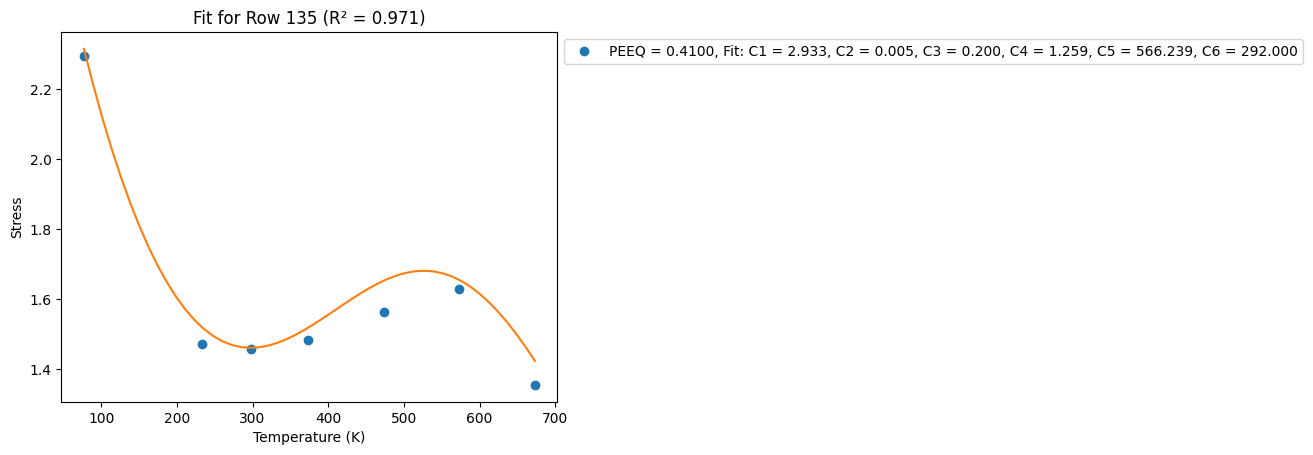

[2.31467125 1.47344695 1.46196478 1.49080776 1.5690036  1.63604781
 1.36124966]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


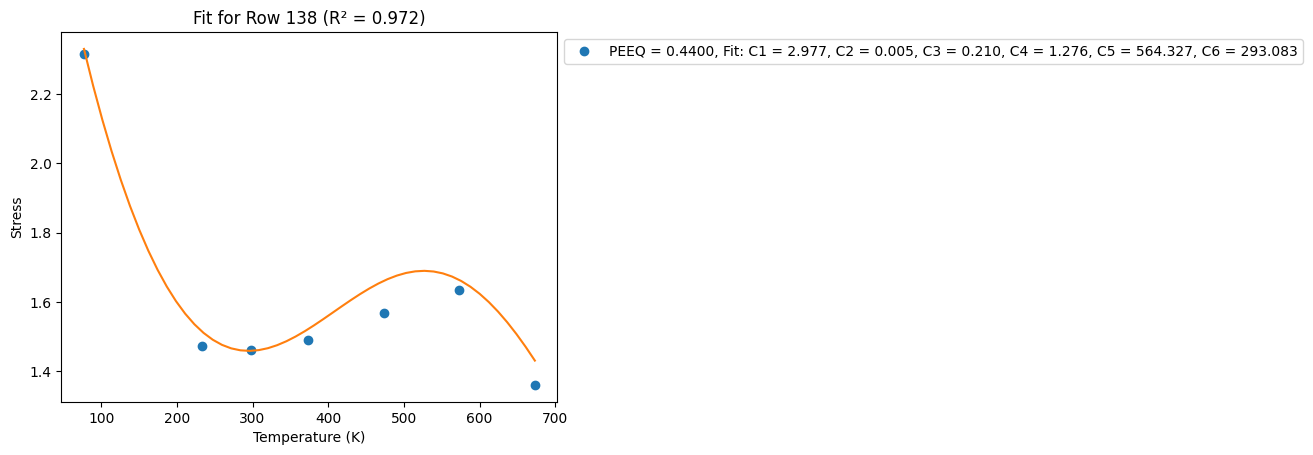

[2.33350393 1.47432638 1.46531346 1.4965087  1.57448183 1.64327118
 1.36645457]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


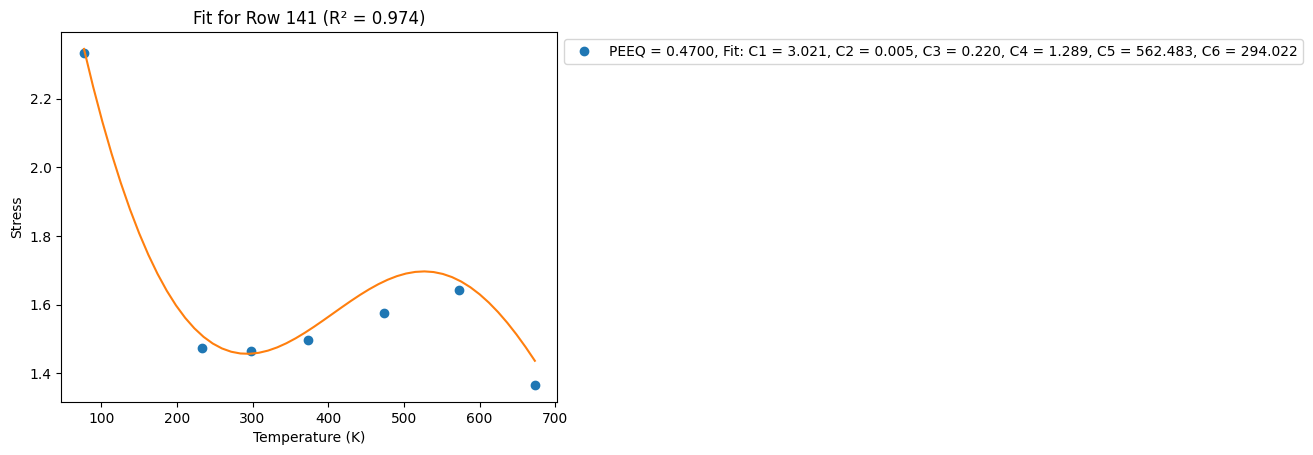

[2.35150524 1.47510549 1.46840805 1.50184987 1.57958285 1.65001256
 1.37133058]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


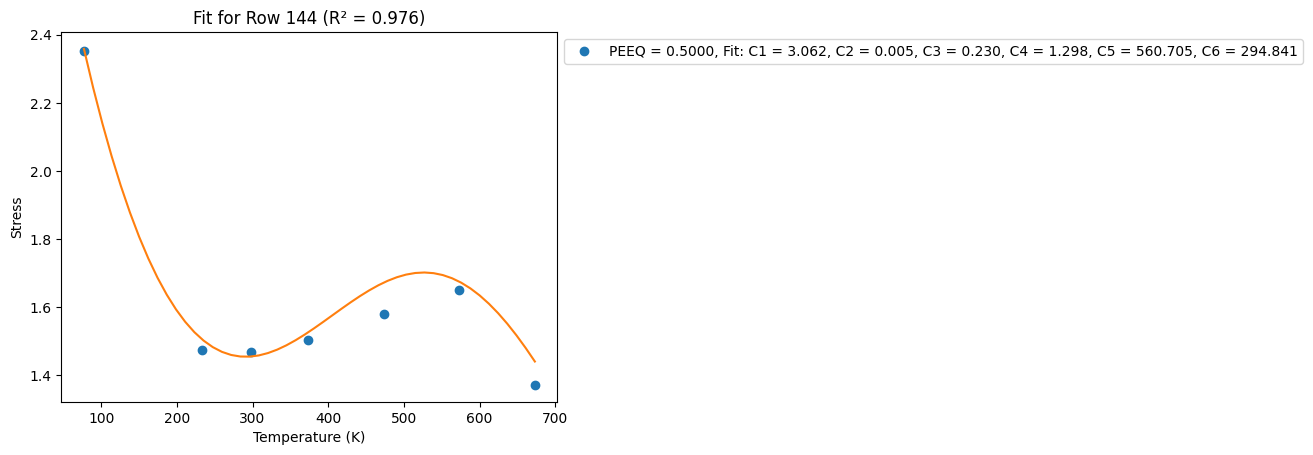

[2.36875958 1.47580084 1.4712817  1.50687401 1.5843534  1.6563308
 1.37591681]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


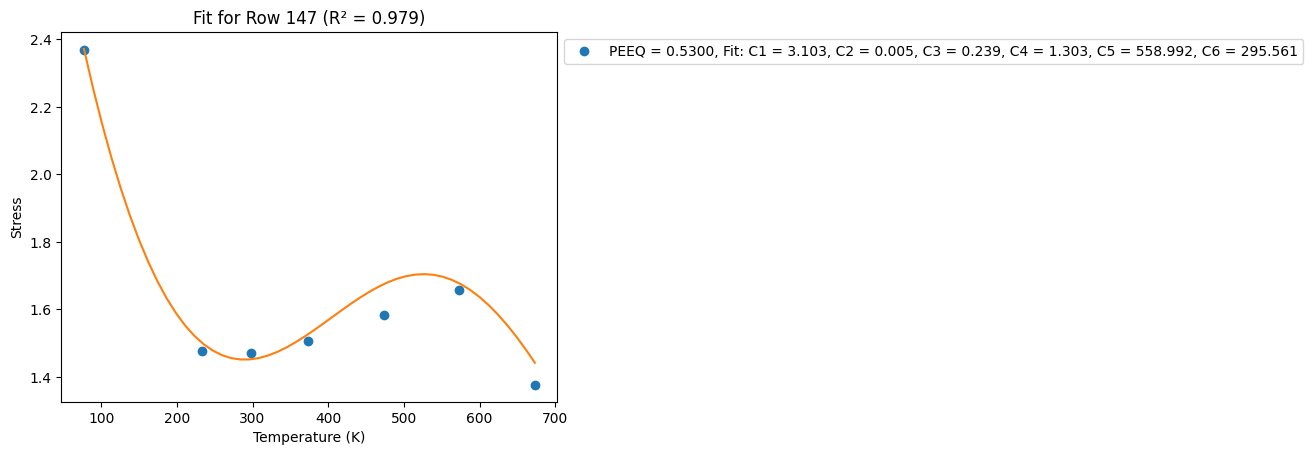

[2.38533848 1.4764255  1.47396162 1.51161669 1.58883217 1.66227467
 1.38024577]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


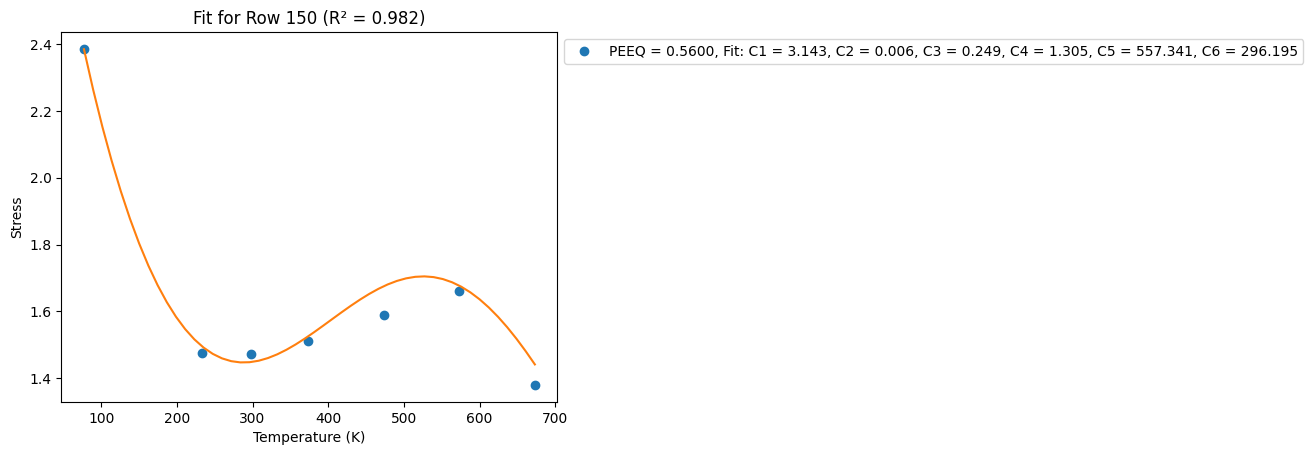

[2.40130318 1.47698994 1.47647041 1.51610778 1.59305151 1.66788502
 1.3843448 ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


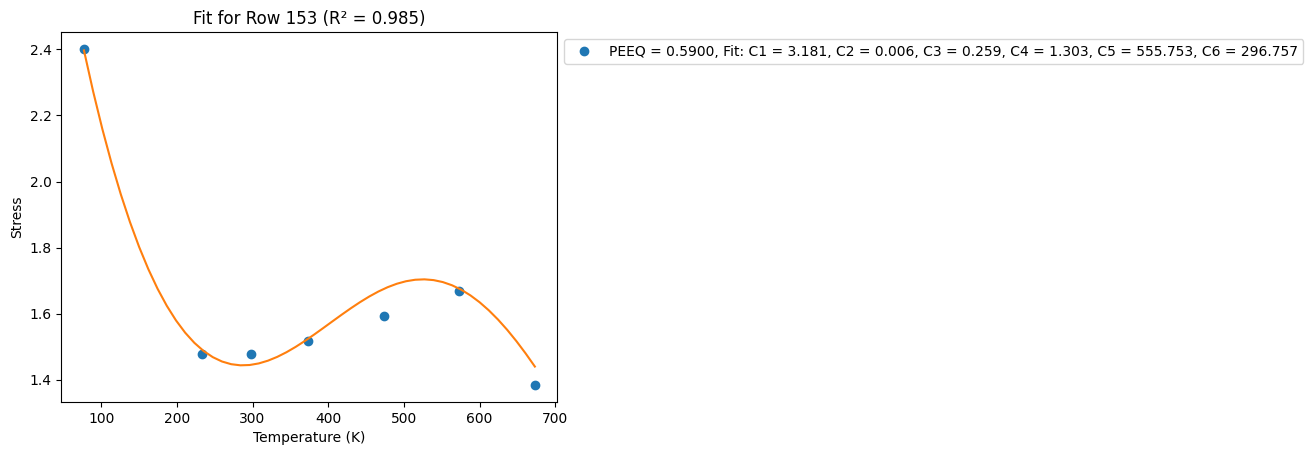

[2.41670649 1.47750263 1.47882704 1.52037266 1.59703872 1.6731964
 1.38823711]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


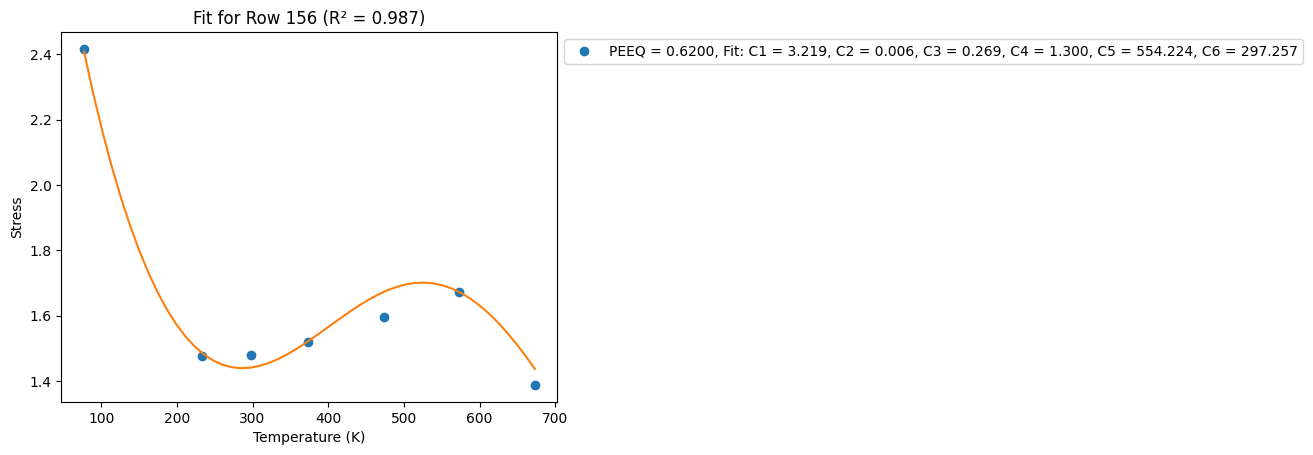

[2.43159438 1.47797052 1.48104755 1.52443303 1.60081707 1.67823833
 1.39194254]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


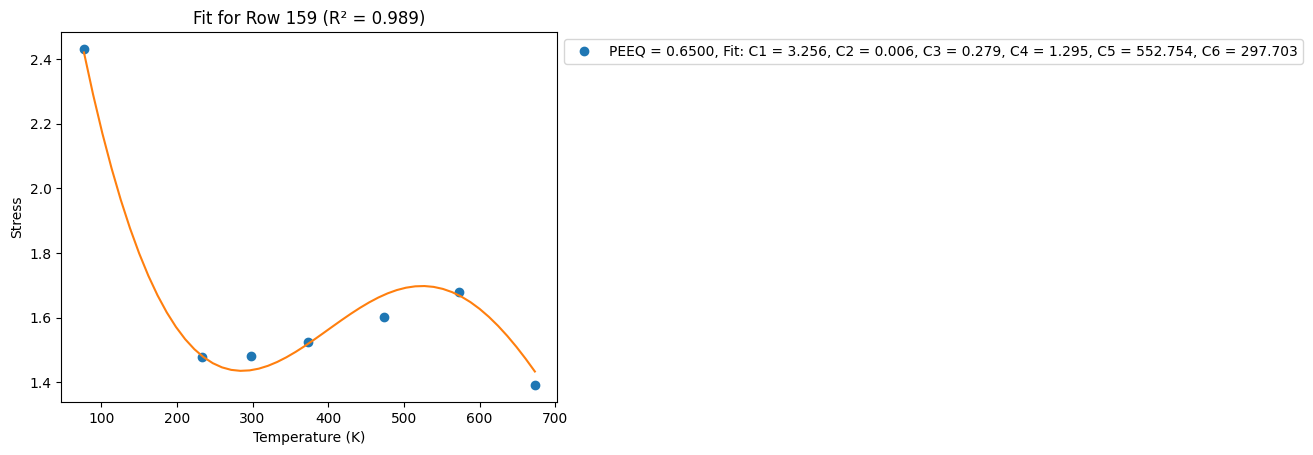

[2.44600708 1.47839935 1.48314566 1.52830764 1.60440655 1.68303617
 1.39547823]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


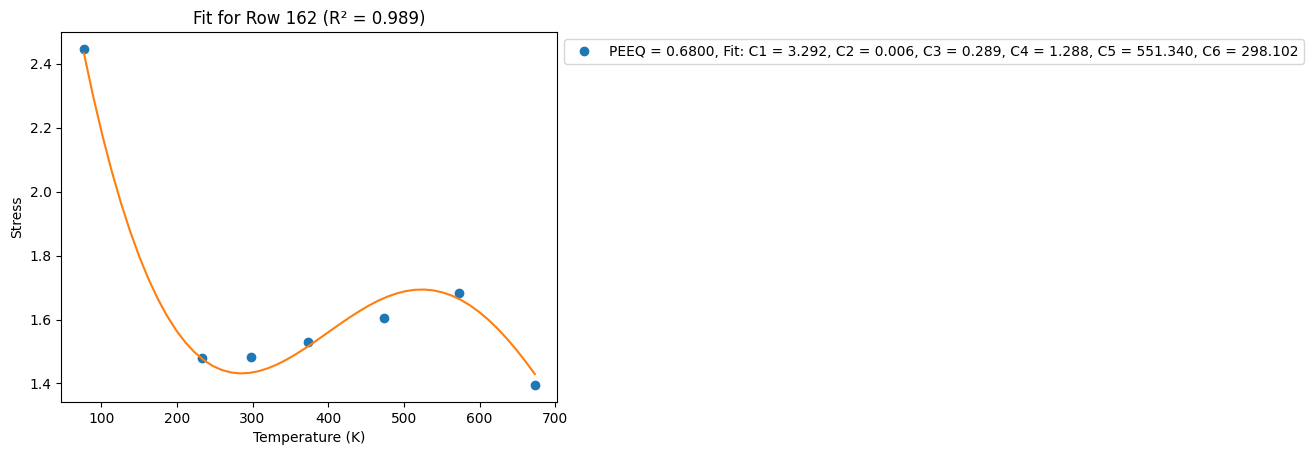

[2.45998006 1.47879391 1.48513315 1.53201274 1.60782442 1.68761189
 1.39885904]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


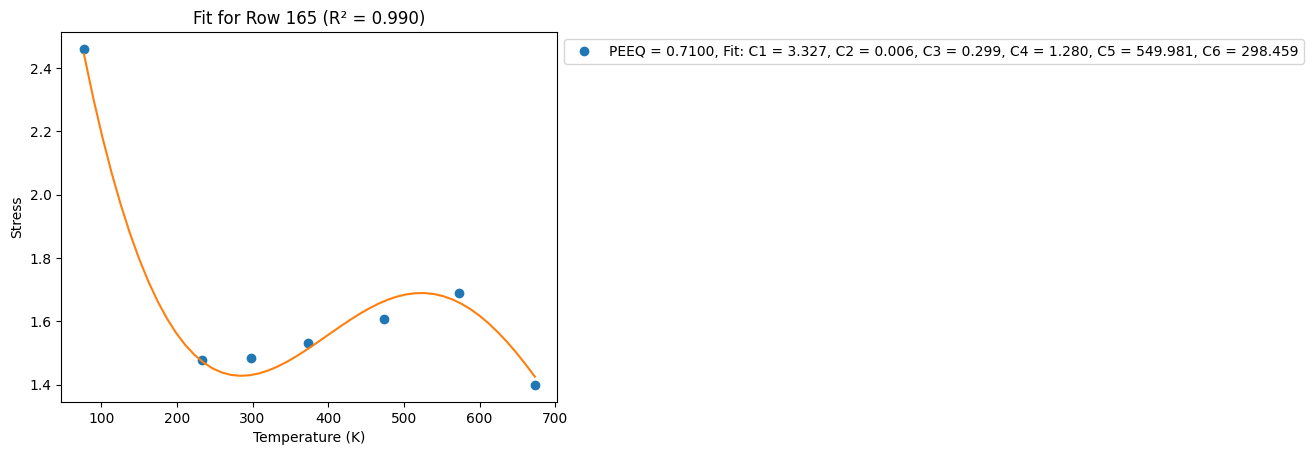

[2.47354474 1.47915823 1.48702023 1.53556255 1.61108573 1.69198465
 1.40209798]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


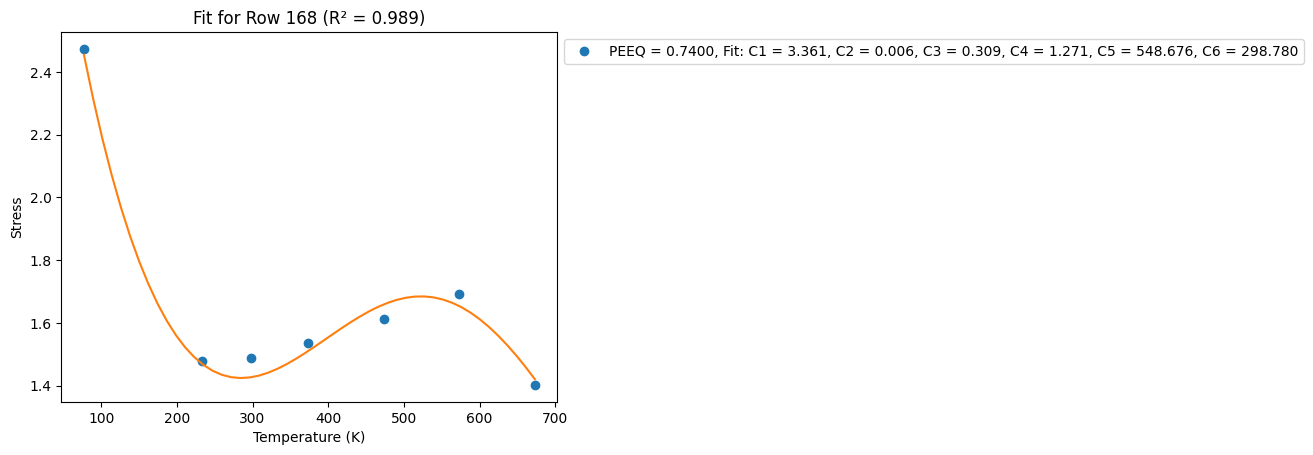

[2.48672913 1.47949574 1.4888158  1.53896958 1.61420364 1.69617125
 1.40520648]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


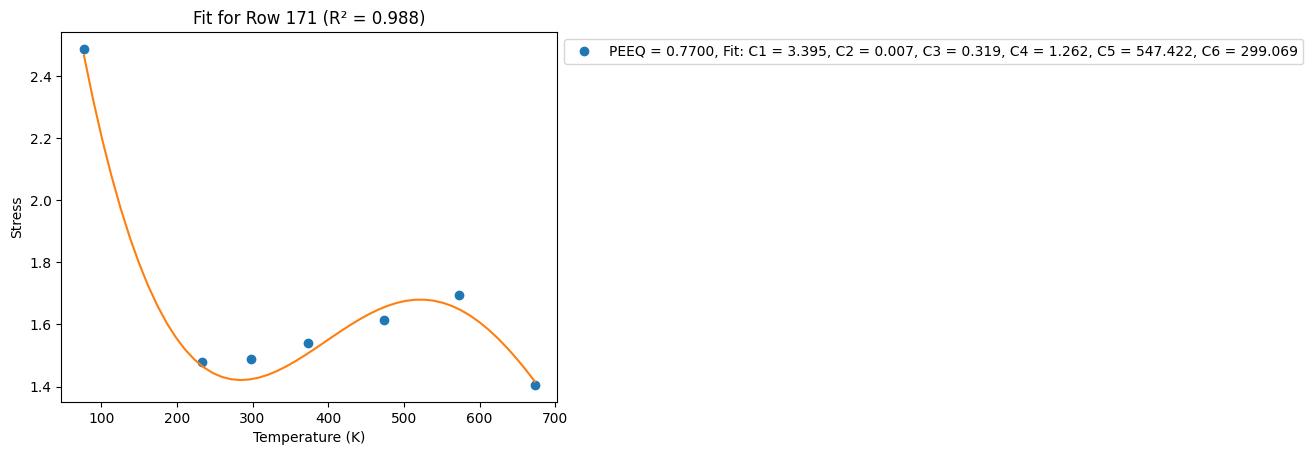

[2.49955829 1.47980934 1.49052765 1.54224487 1.61718977 1.70018652
 1.40819464]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


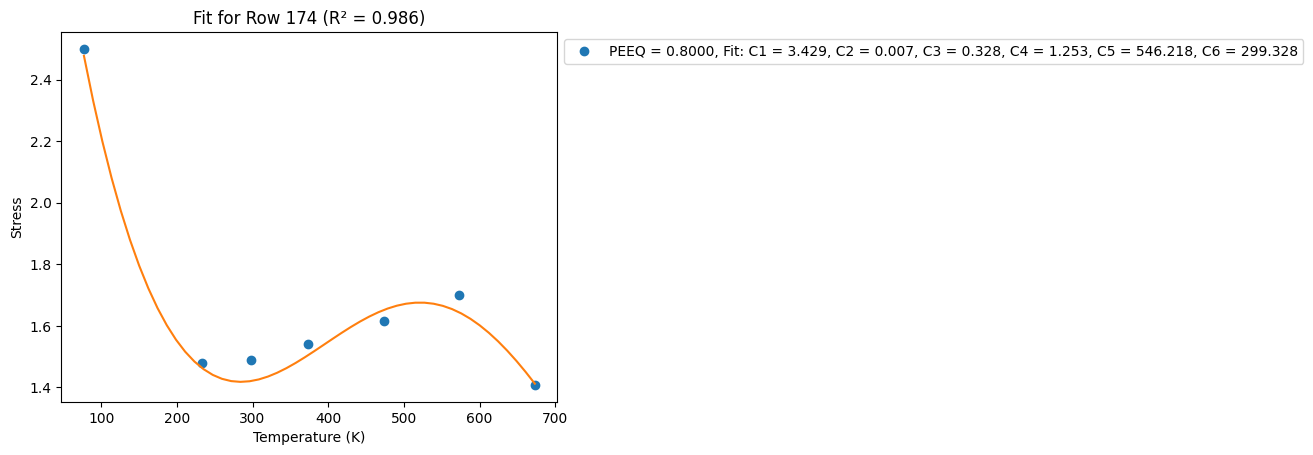

[2.51205475 1.48010155 1.49216264 1.54539825 1.62005436 1.70404358
 1.41107143]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


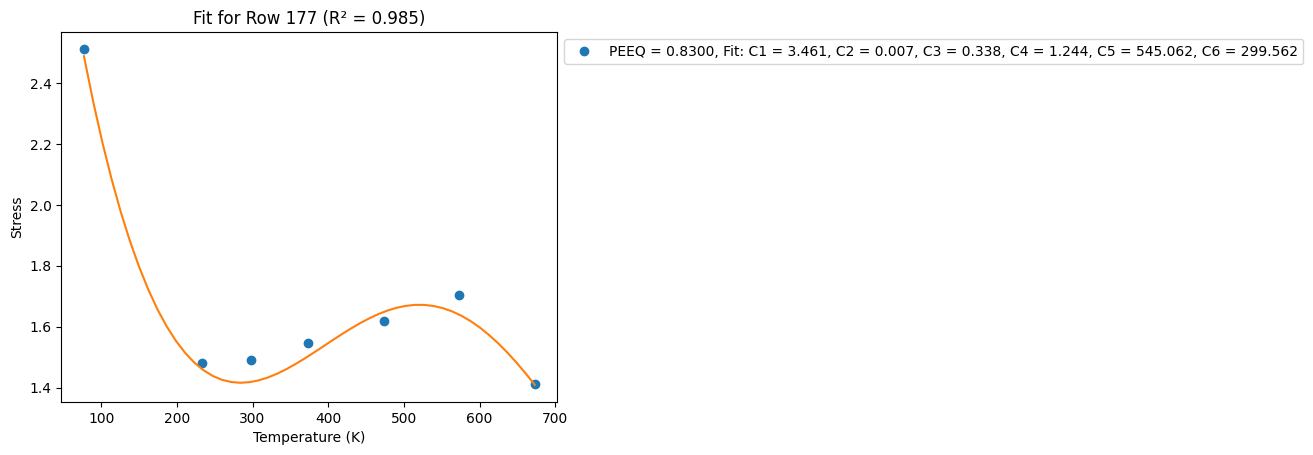

[2.52423884 1.48037452 1.49372686 1.54843847 1.62280655 1.70775411
 1.41384486]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


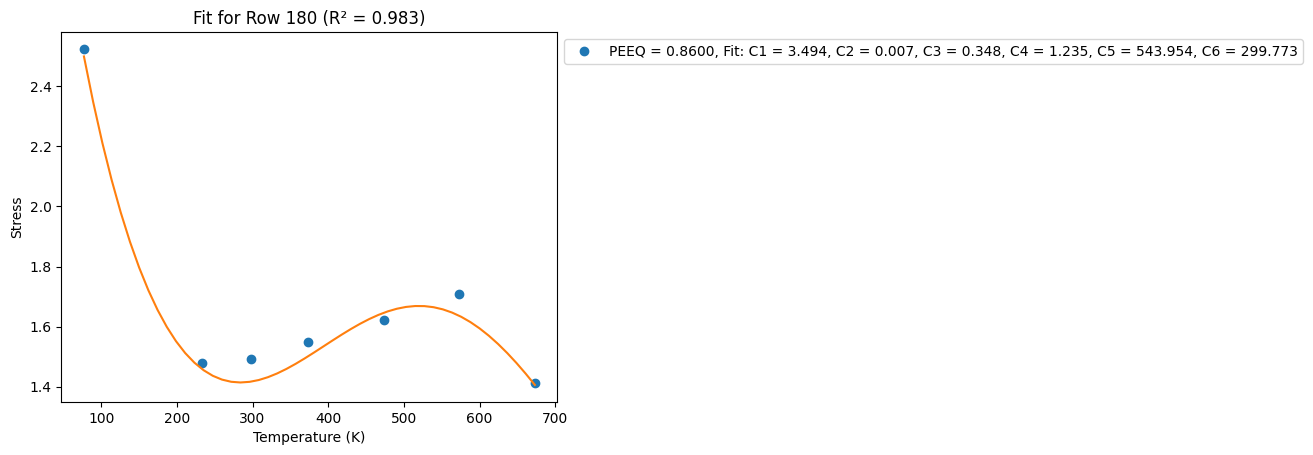

[2.53612901 1.48063013 1.4952257  1.55137337 1.62545448 1.71132857
 1.41652209]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


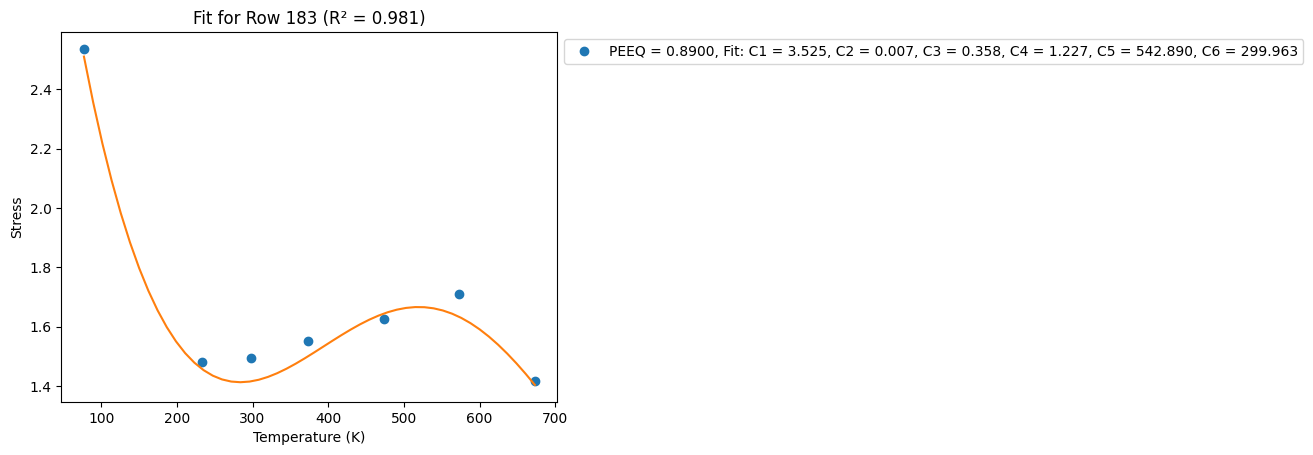

[2.54774201 1.48087002 1.49666399 1.55421001 1.62800545 1.71477633
 1.41910959]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


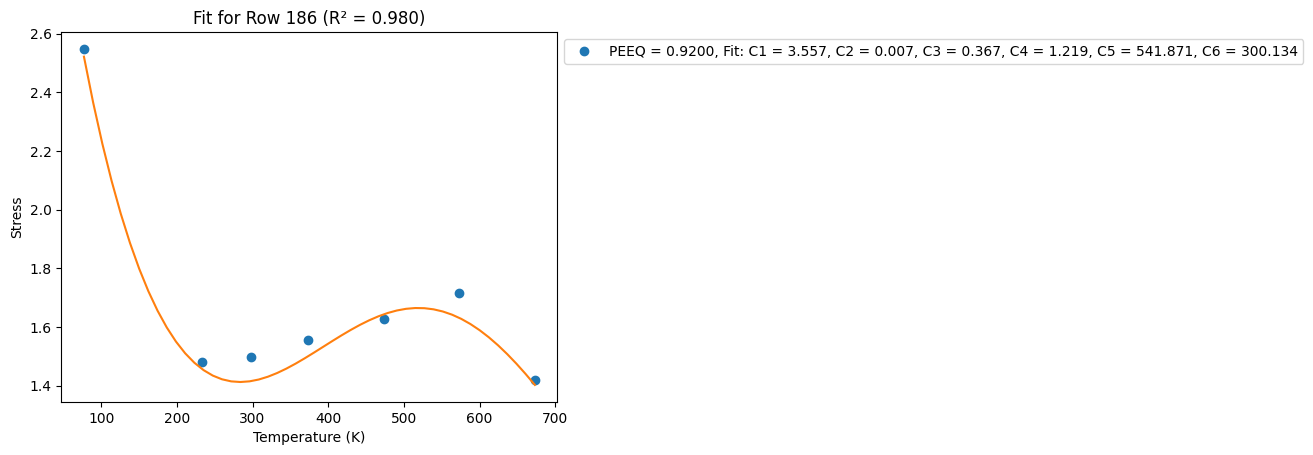

[2.55909313 1.48109563 1.49804606 1.55695476 1.63046604 1.71810585
 1.42161316]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


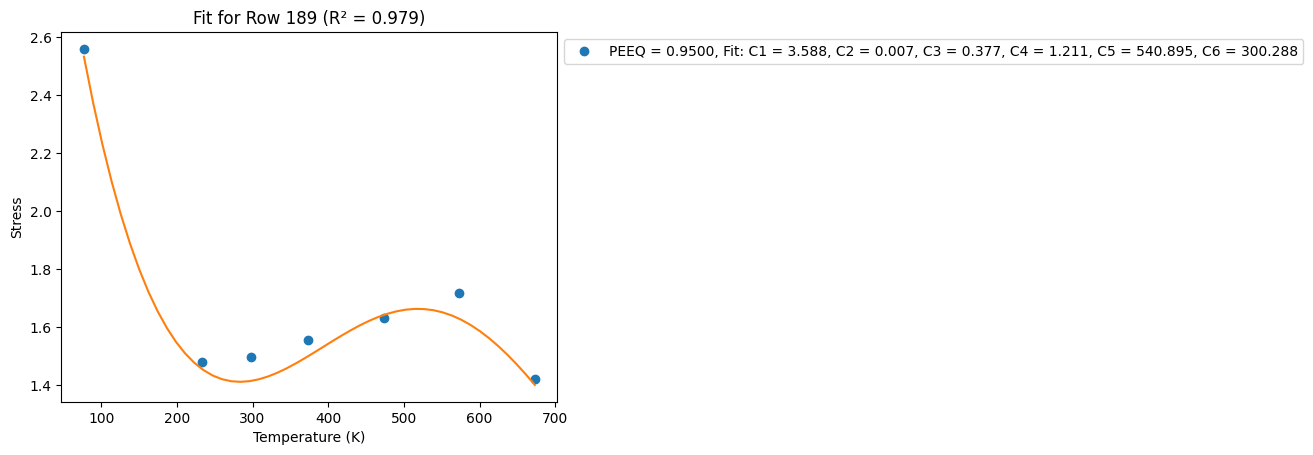

[2.57019635 1.48130823 1.49937579 1.5596134  1.63284218 1.72132475
 1.42403808]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


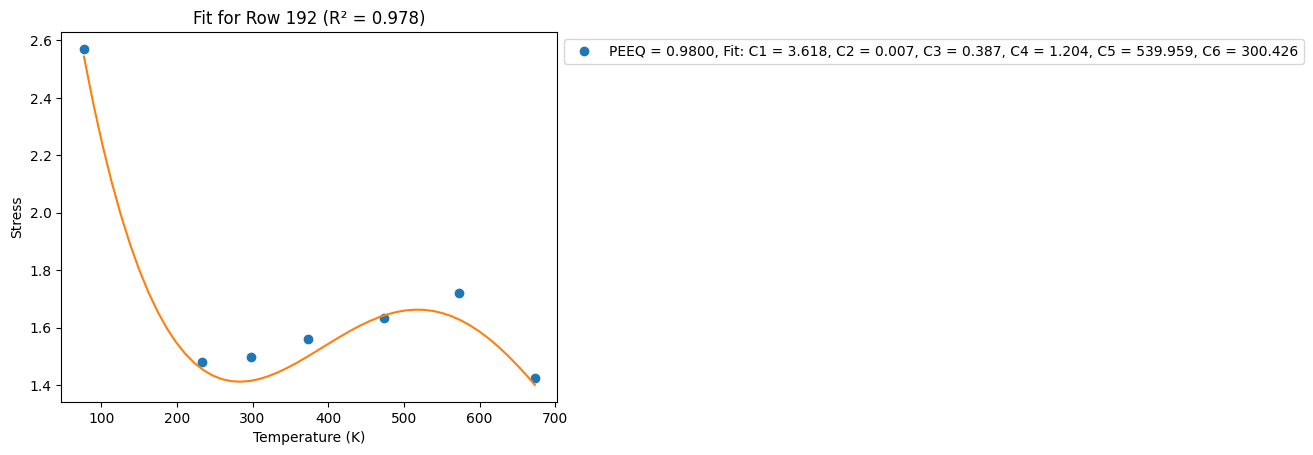

[2.58106451 1.48150892 1.50065669 1.56219116 1.63513926 1.72443998
 1.42638915]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


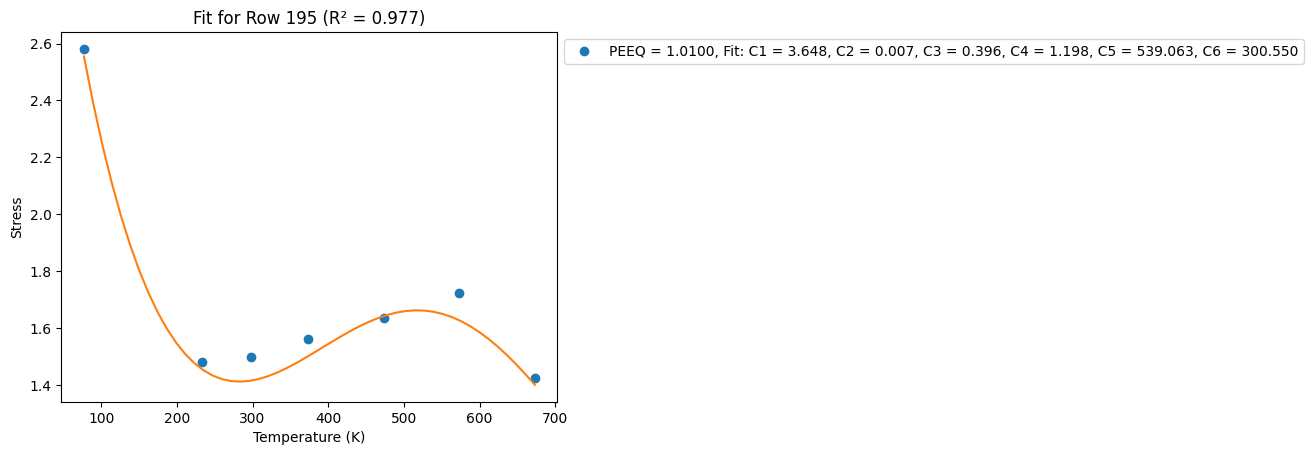

[2.59170943 1.48169871 1.50189194 1.56469282 1.63736214 1.72745783
 1.42867072]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


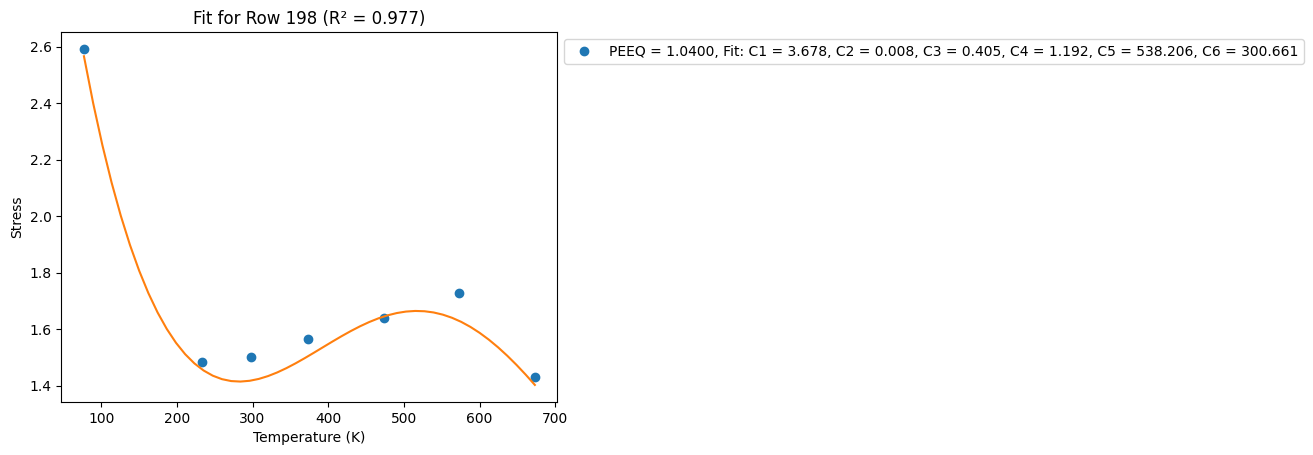

[2.60214198 1.48187848 1.50308443 1.56712276 1.6395153  1.73038405
 1.4308868 ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


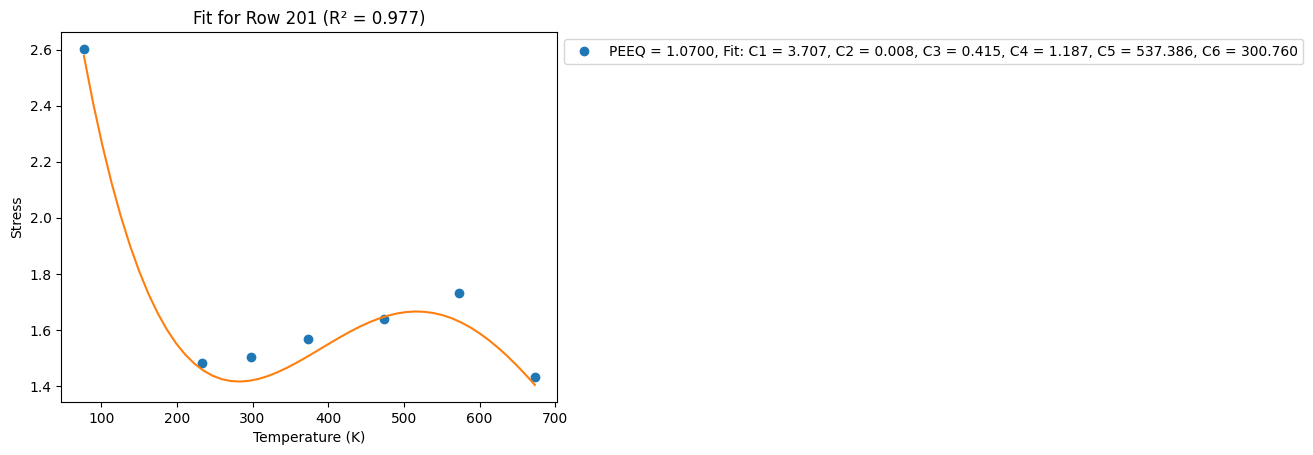

[2.61237225 1.48204902 1.50423679 1.56948496 1.64160279 1.7332239
 1.43304104]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


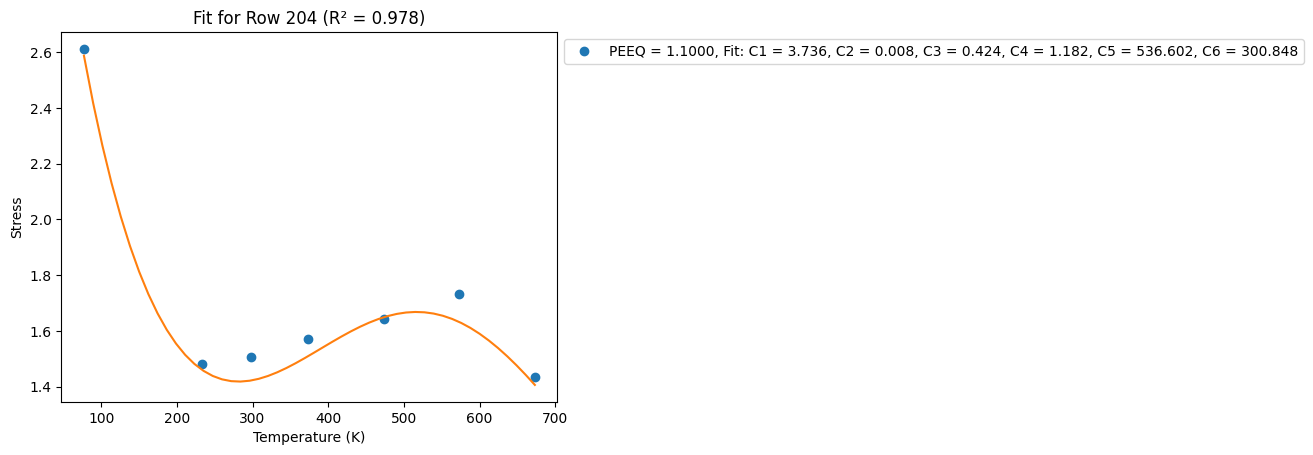

[2.62240957 1.48221103 1.50535142 1.57178312 1.64362834 1.7359822
 1.43513679]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


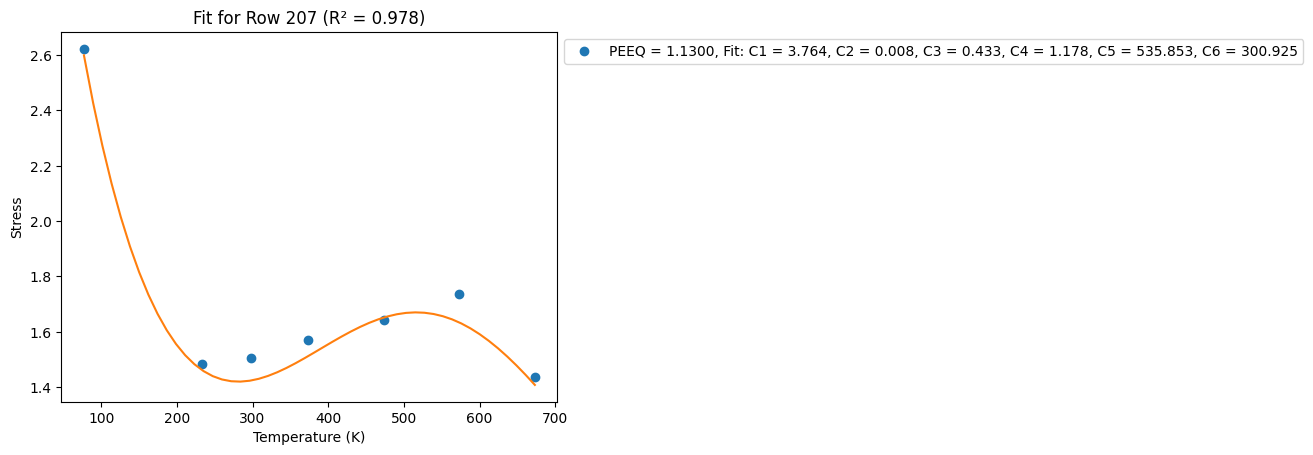

[2.63226259 1.48236516 1.50643051 1.5740206  1.64559538 1.73866339
 1.43717715]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


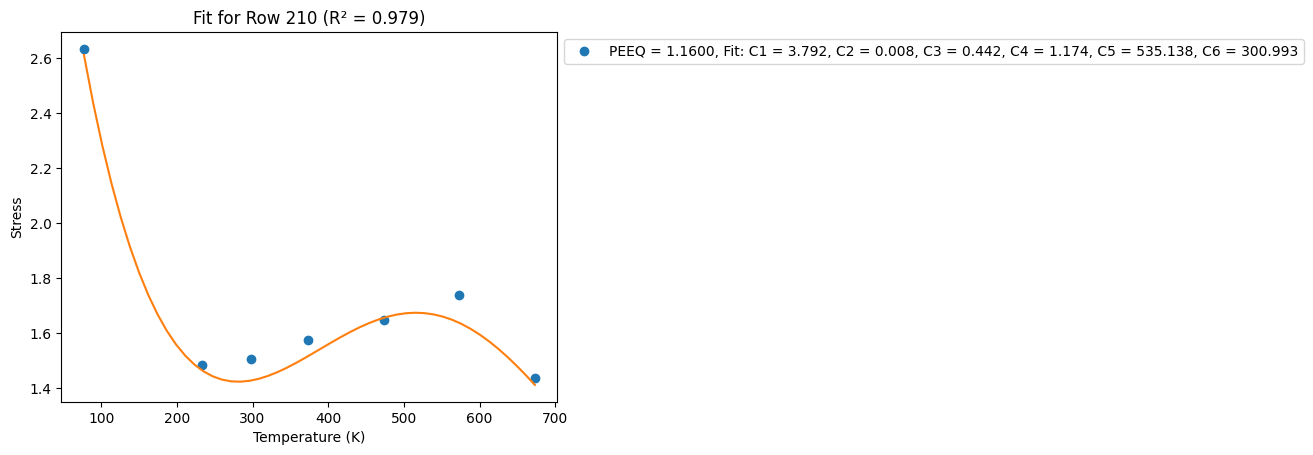

[2.64193939 1.48251198 1.50747608 1.57620054 1.64750706 1.74127155
 1.43916496]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


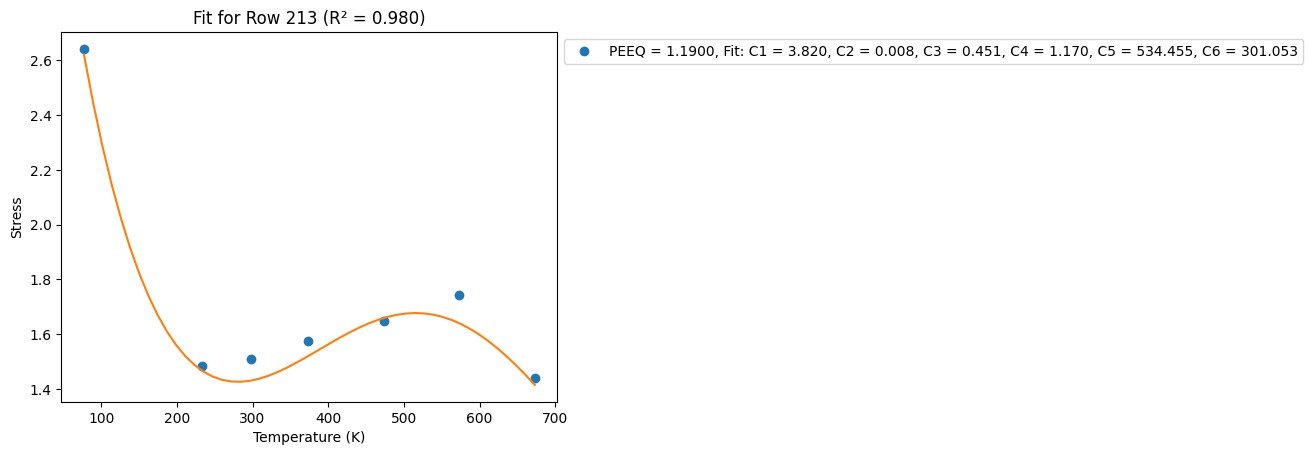

[2.65144747 1.48265201 1.50848998 1.57832583 1.64936628 1.74381045
 1.44110288]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


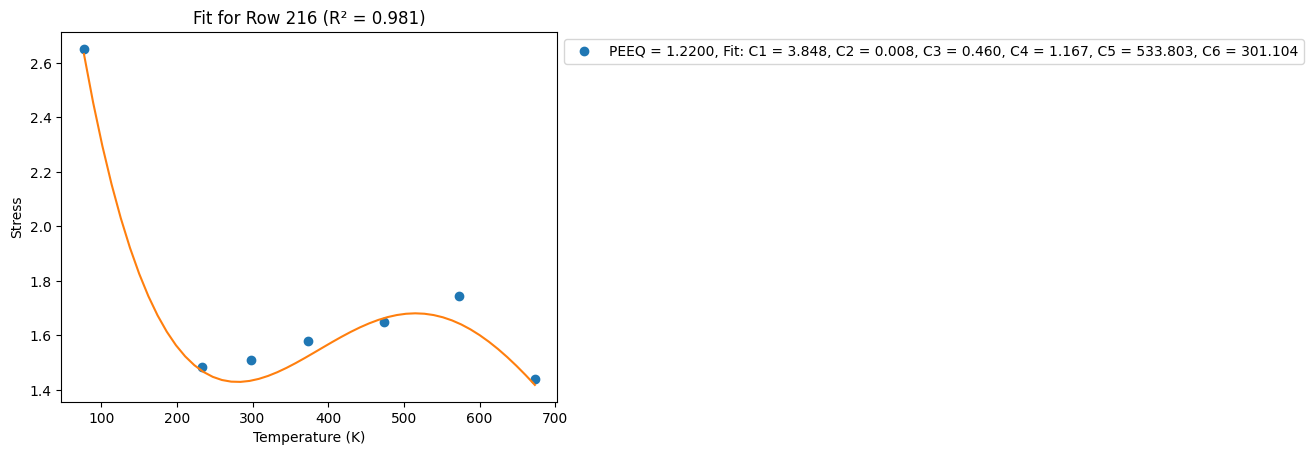

[2.66079385 1.48278571 1.50947393 1.58039913 1.65117574 1.74628358
 1.44299334]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


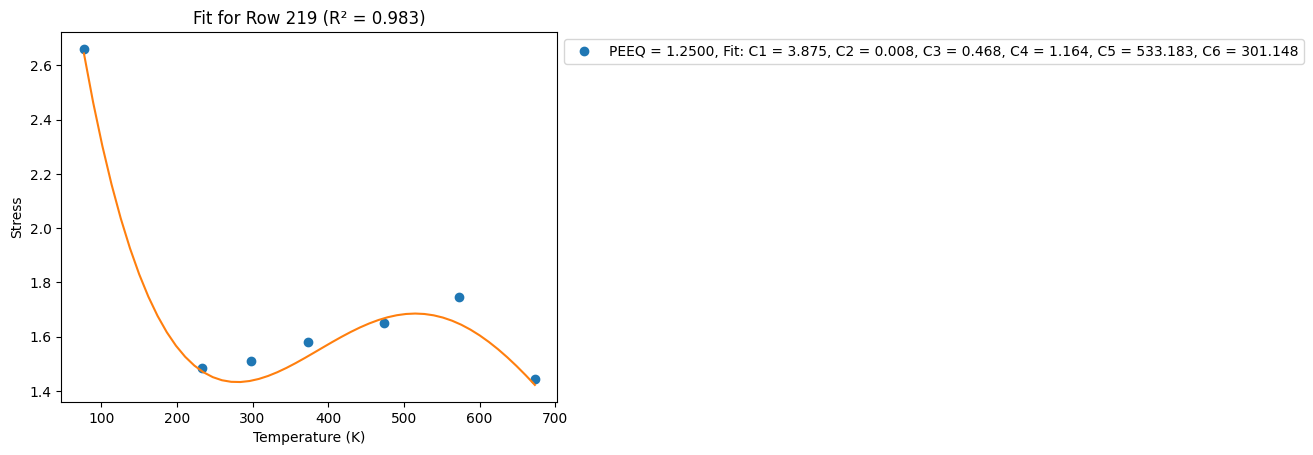

[2.66998511 1.48291352 1.5104295  1.58242293 1.65293791 1.74869418
 1.44483861]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


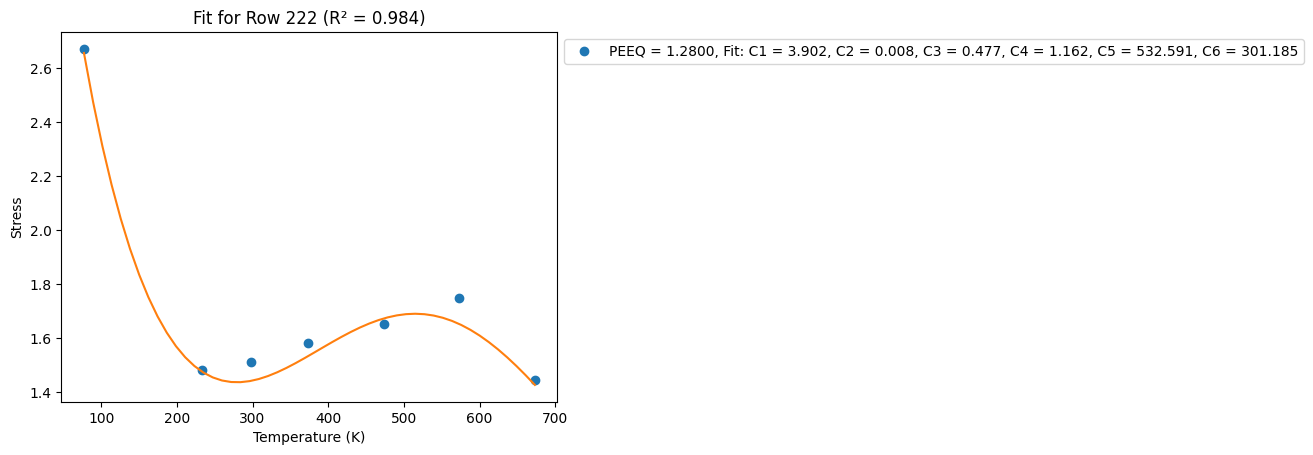

[2.67902737 1.48303583 1.51135816 1.58439954 1.65465511 1.75104524
 1.44664081]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


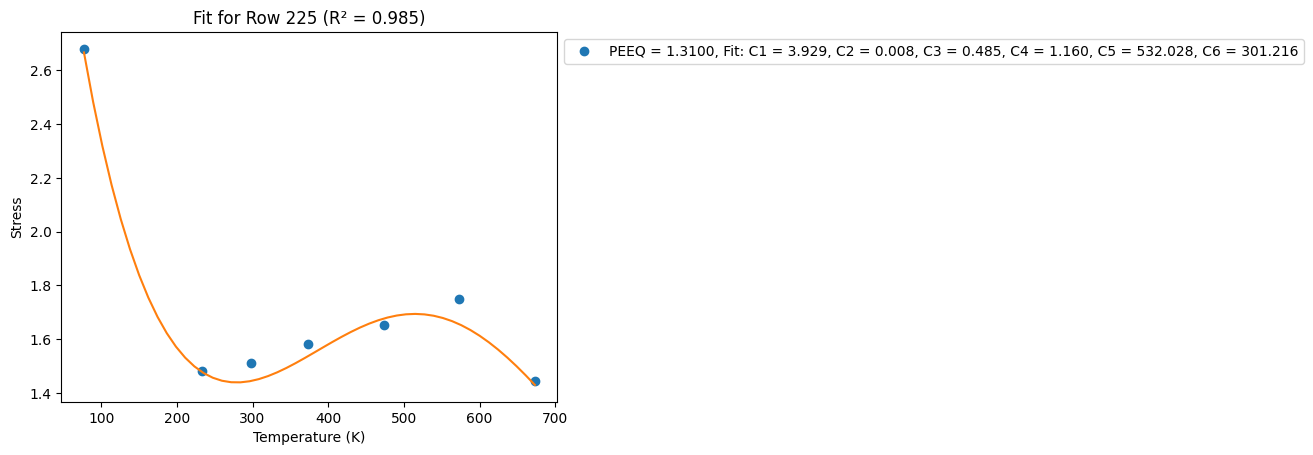

[2.68792643 1.48315298 1.51226124 1.58633112 1.65632948 1.75333956
 1.44840189]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


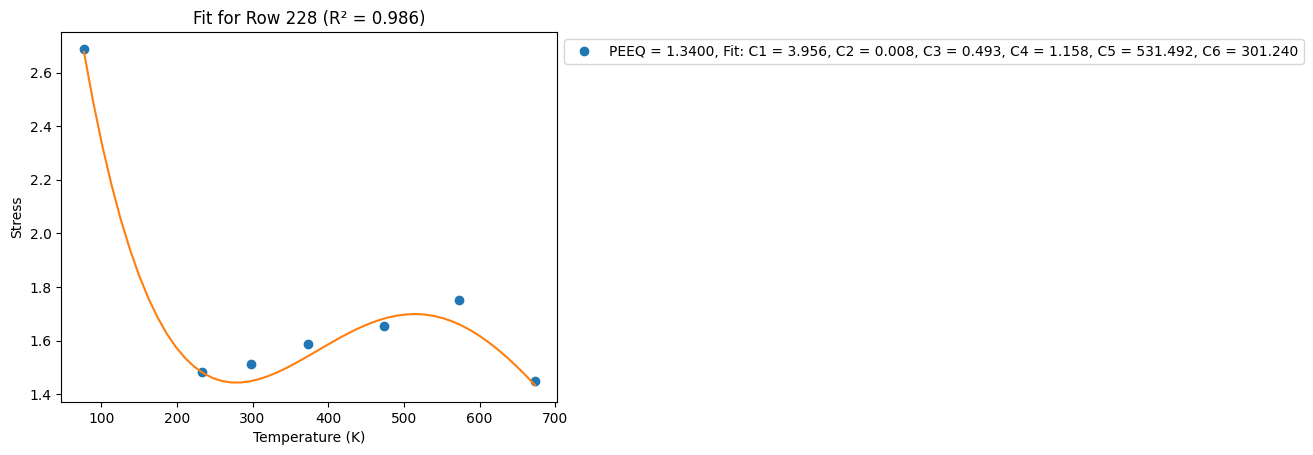

[2.6966877  1.48326532 1.51314002 1.58821967 1.65796303 1.75557974
 1.45012369]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


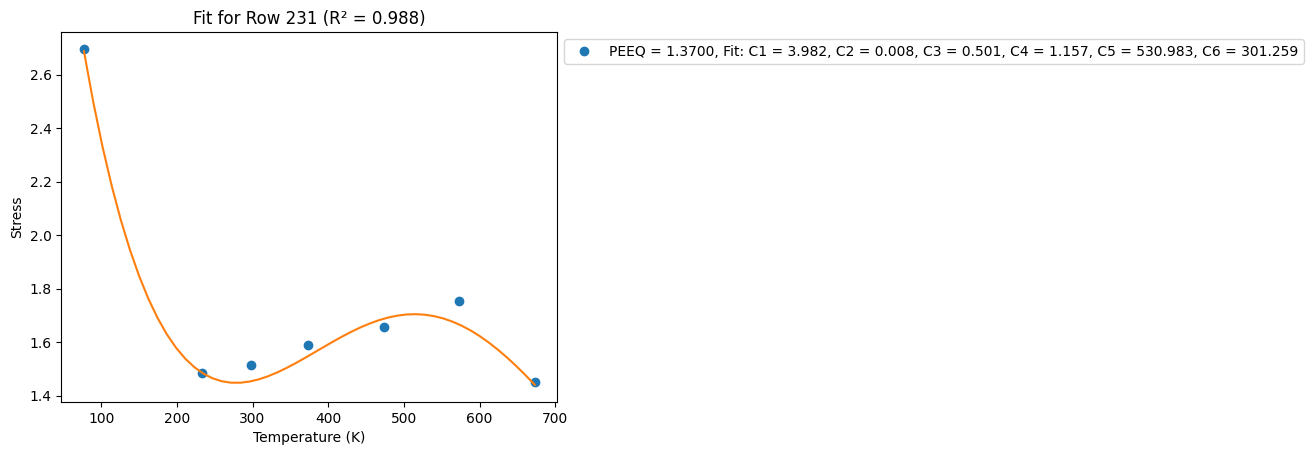

[2.70531628 1.48337313 1.51399566 1.59006706 1.65955761 1.75776822
 1.45180793]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


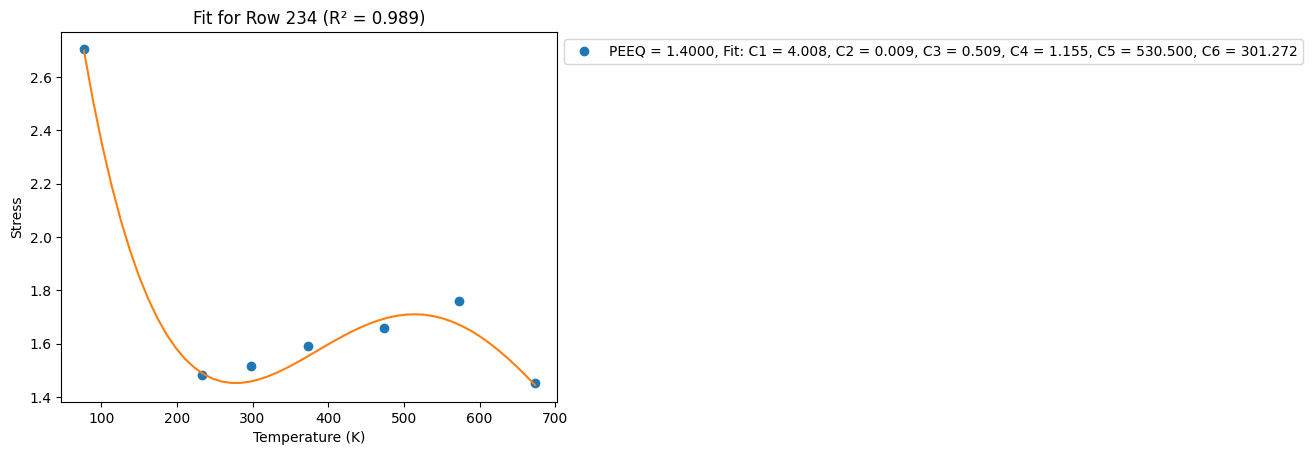

[2.71381698 1.48347669 1.51482926 1.59187506 1.66111496 1.75990726
 1.45345621]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


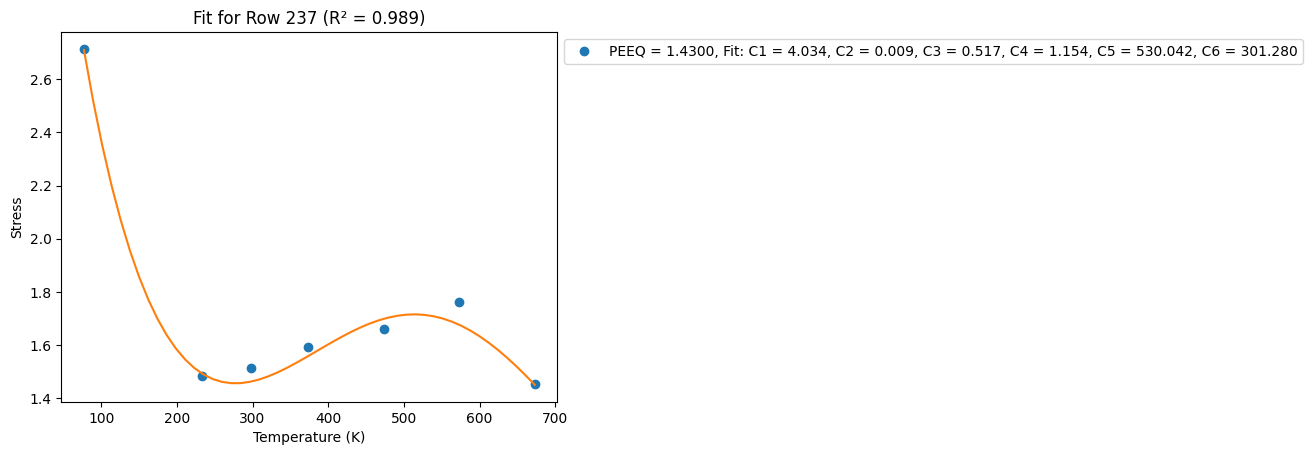

[2.72219435 1.48357625 1.51564182 1.59364531 1.66263672 1.76199899
 1.45507004]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


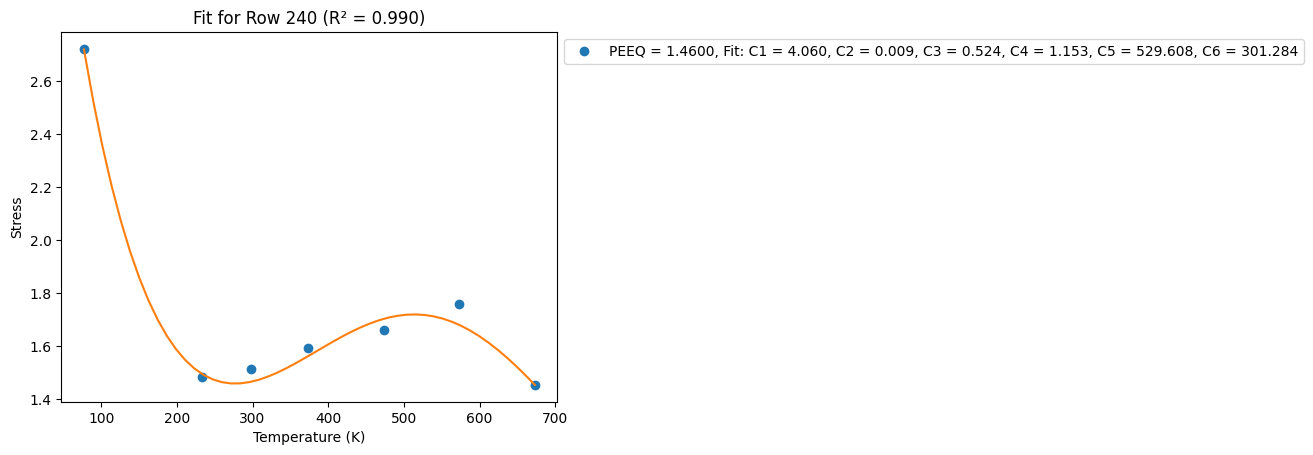

[2.73045266 1.48367204 1.51643429 1.59537936 1.6641244  1.76404541
 1.45665081]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


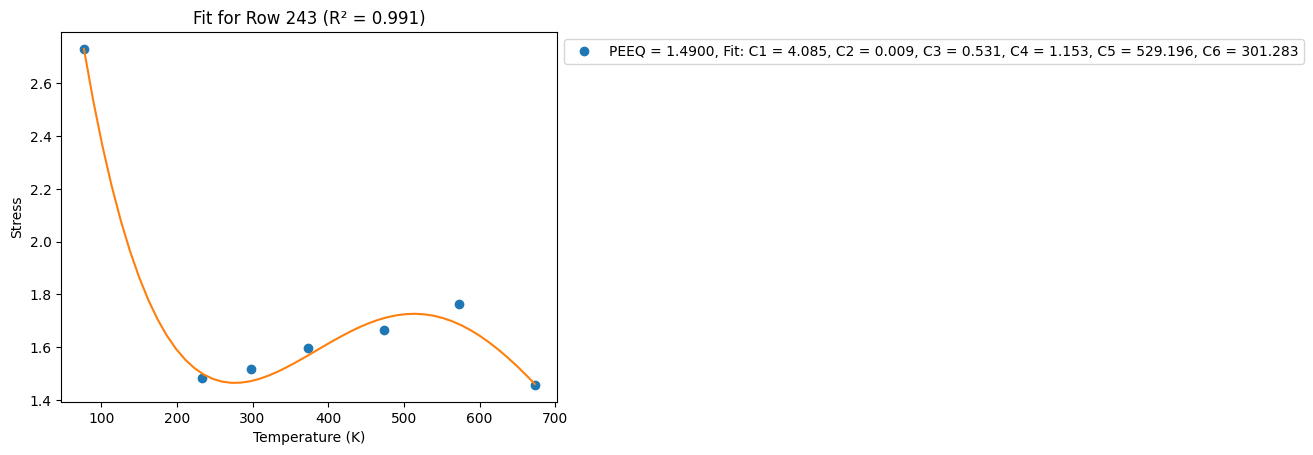

[2.73859598 1.48376428 1.51720757 1.59707865 1.66557944 1.76604838
 1.45819987]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


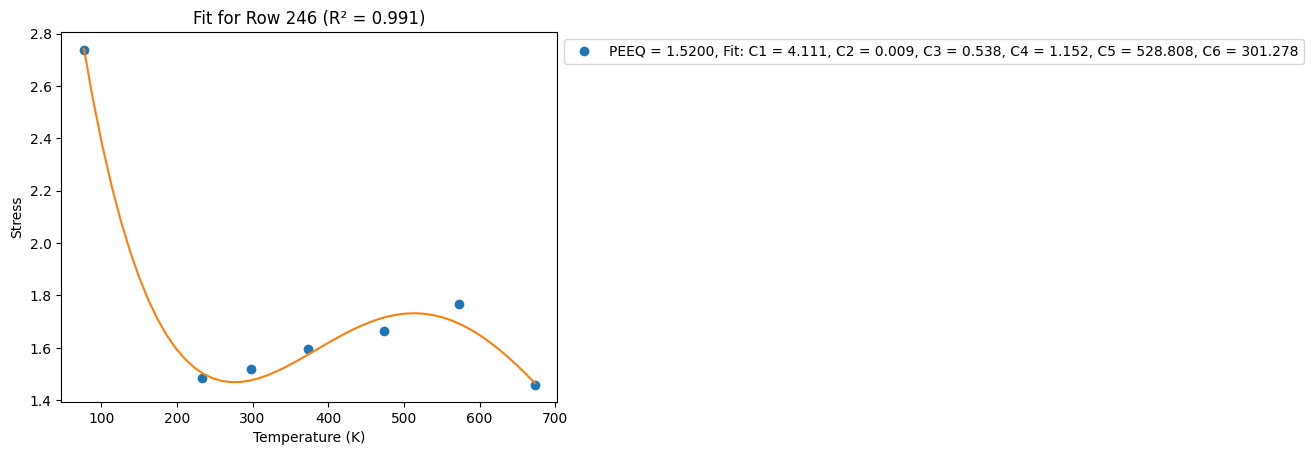

[2.74662814 1.48385317 1.51796248 1.59874456 1.66700319 1.76800966
 1.45971846]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


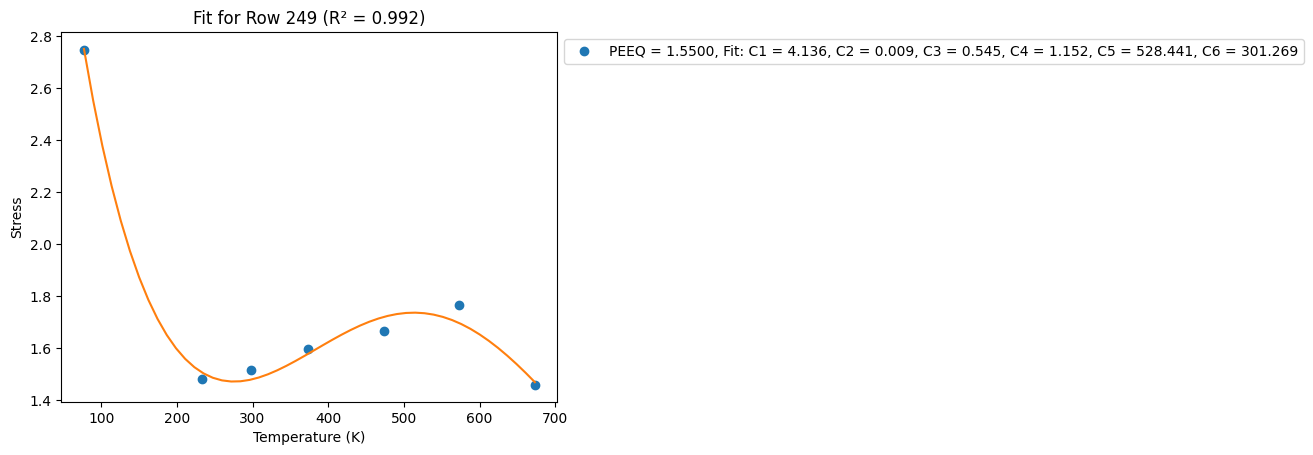

[2.75455278 1.48393889 1.51869982 1.60037837 1.66839689 1.76993091
 1.46120775]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


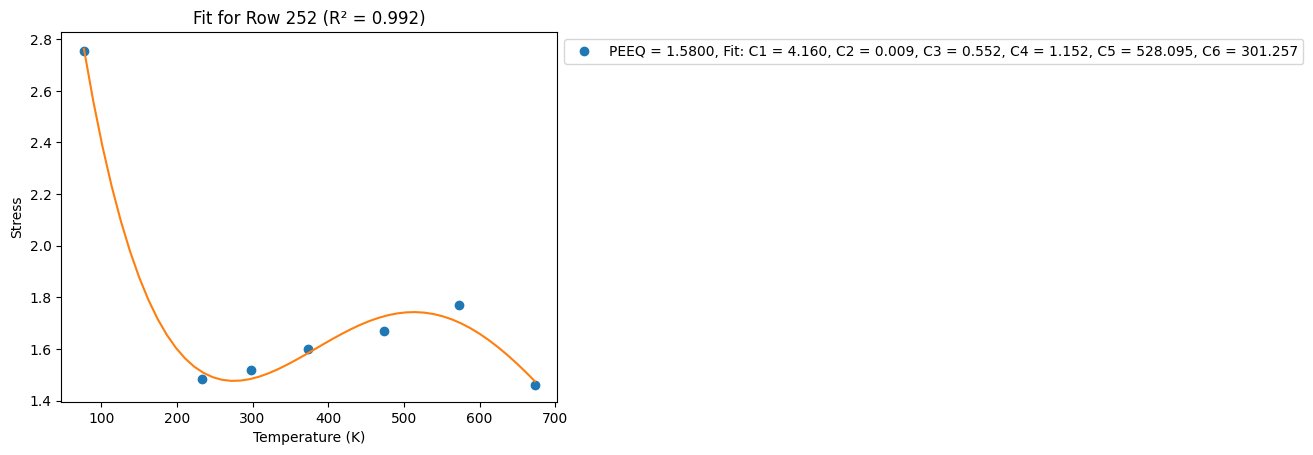

[2.76237335 1.48402161 1.51942031 1.6019813  1.66976176 1.77181369
 1.46266886]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


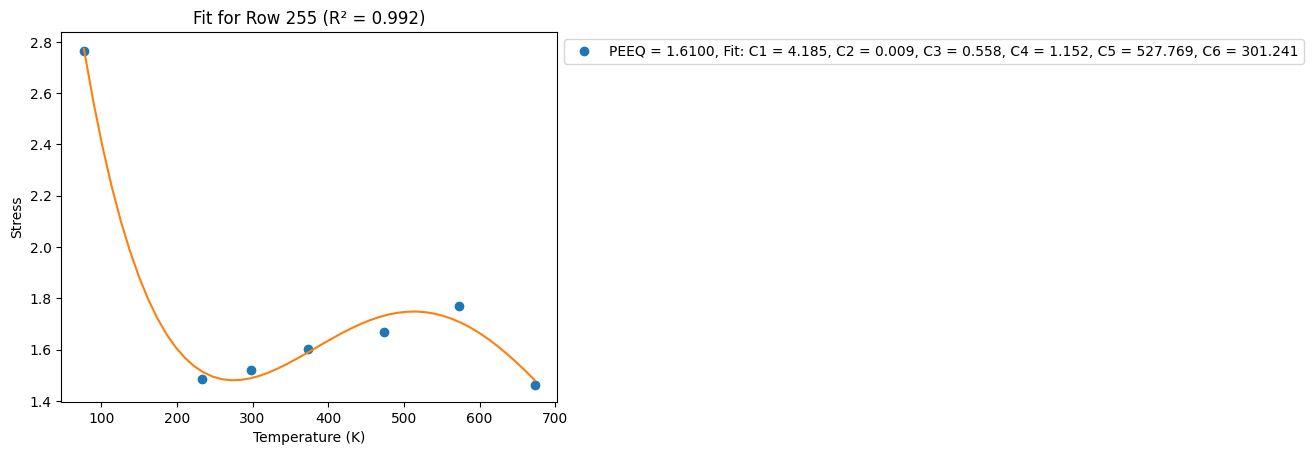

[2.77009313 1.48410149 1.52012464 1.60355449 1.67109889 1.77365946
 1.46410283]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


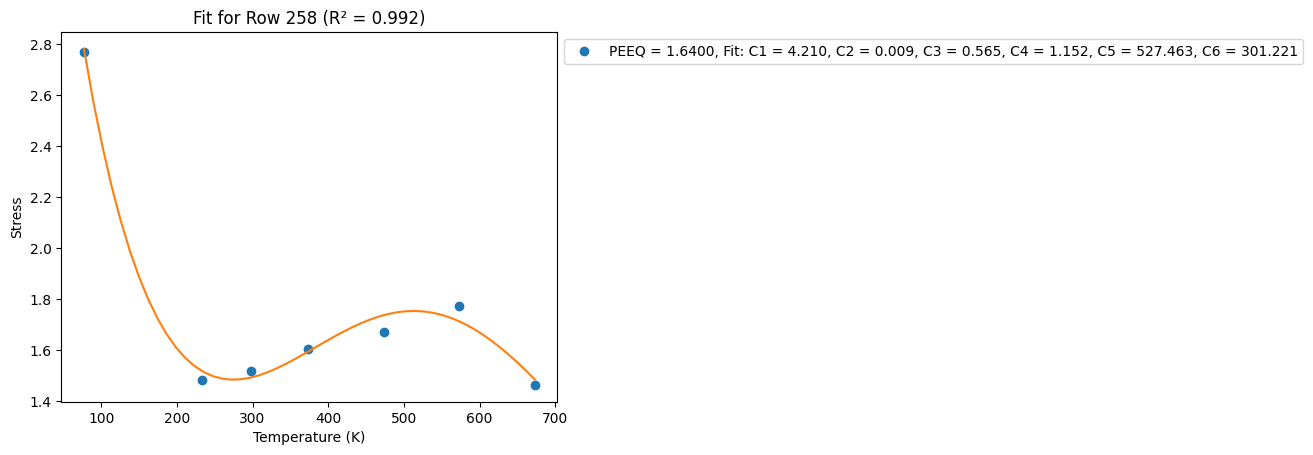

[2.77771525 1.48417867 1.52081346 1.60509902 1.67240936 1.77546961
 1.46551064]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


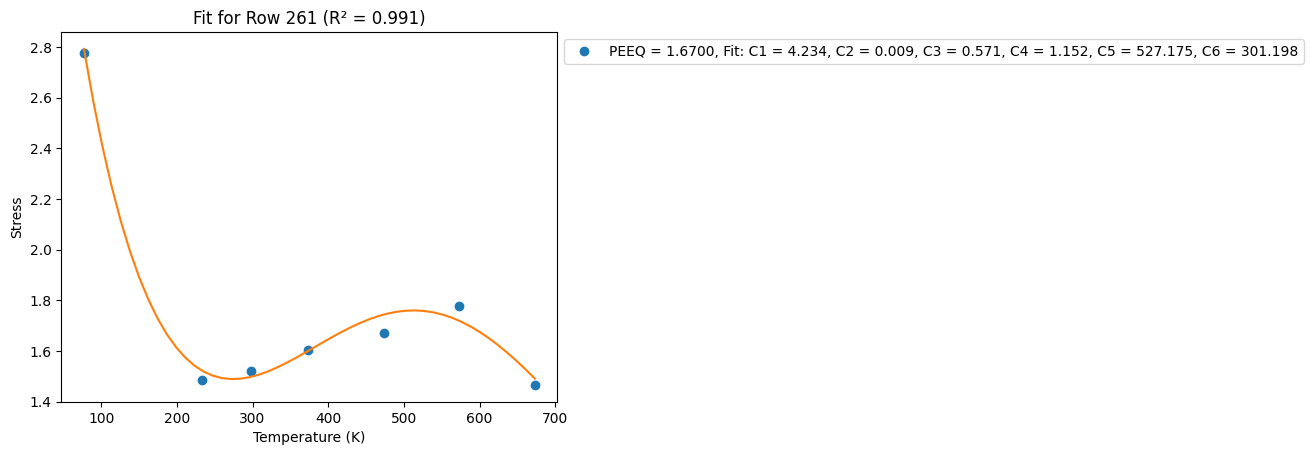

[2.78524267 1.4842533  1.52148738 1.60661593 1.67369416 1.77724547
 1.46689325]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


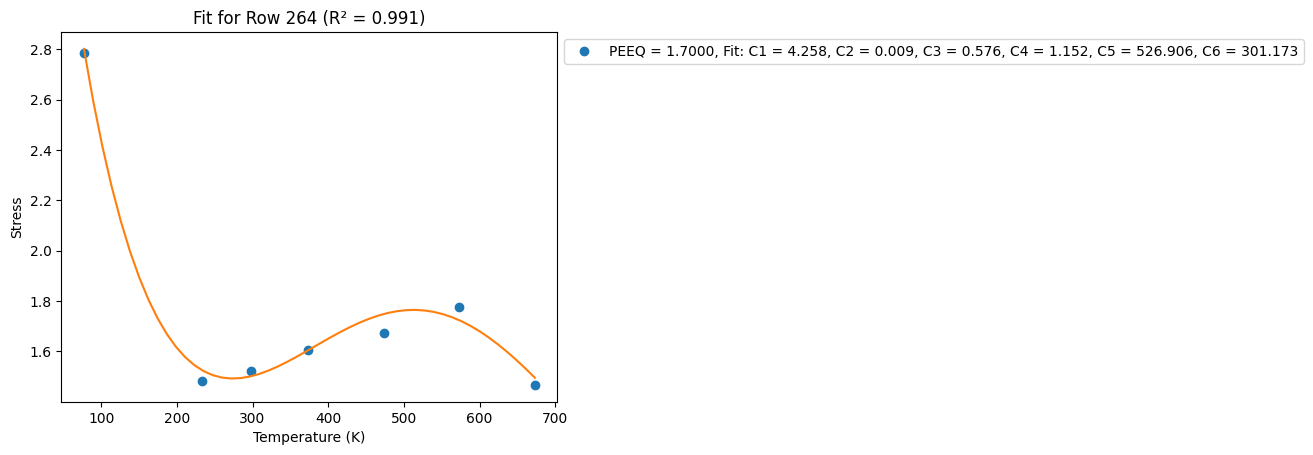

[2.79267821 1.48432549 1.52214699 1.60810618 1.67495424 1.77898826
 1.46825153]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


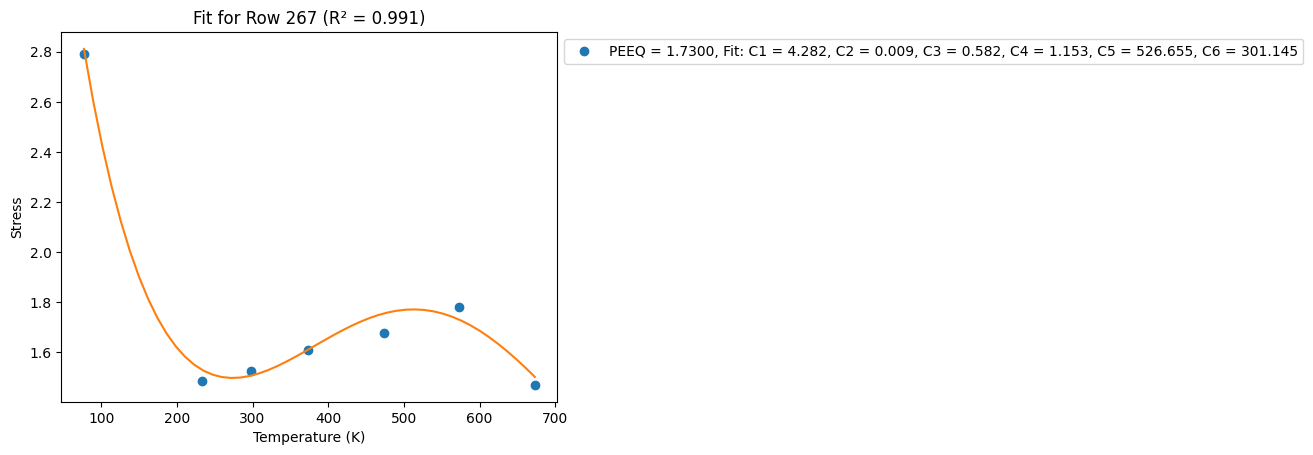

[2.80002458 1.48439538 1.52279283 1.60957069 1.67619049 1.78069916
 1.46958633]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


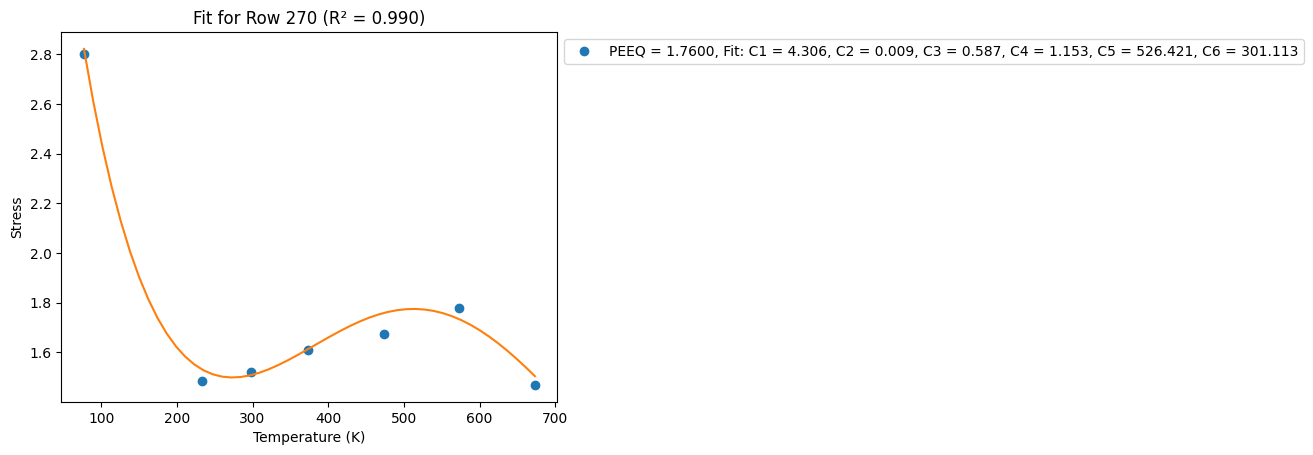

[2.80728434 1.48446306 1.52342541 1.61101035 1.67740376 1.7823793
 1.47089844]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


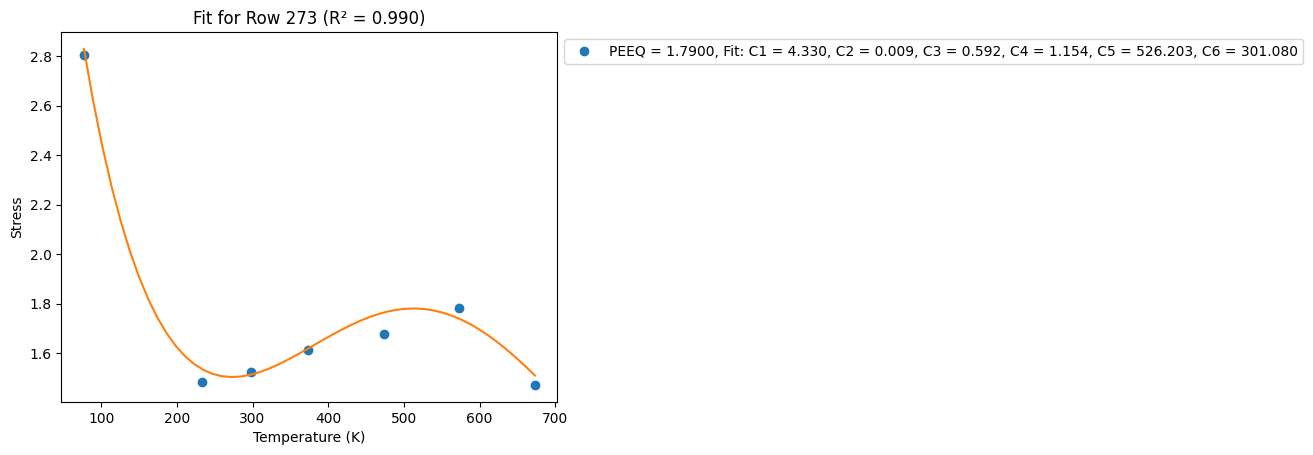

[2.81445994 1.48452866 1.52404522 1.61242597 1.67859486 1.78402972
 1.47218862]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


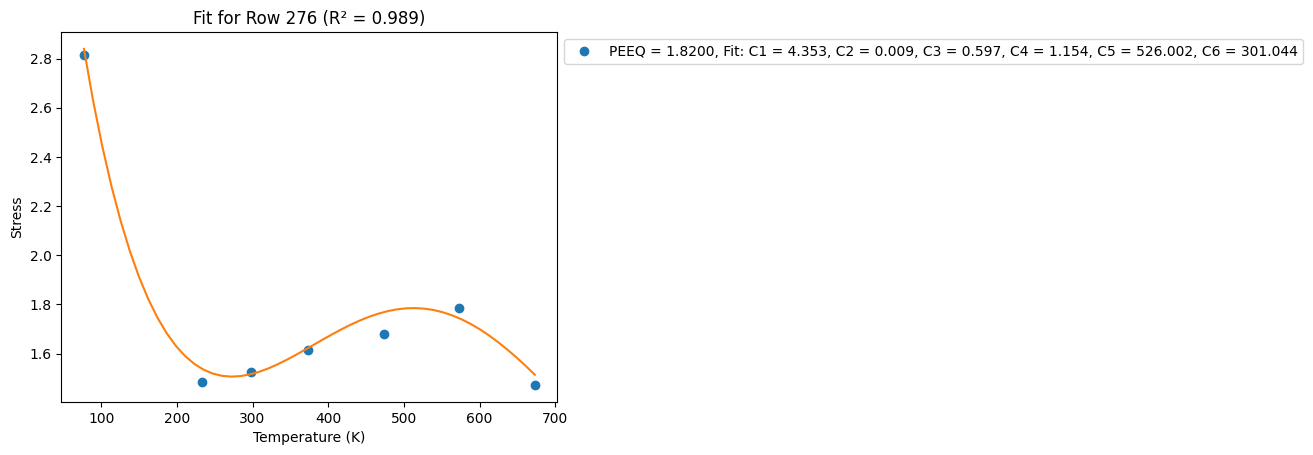

[2.82155374 1.48459225 1.52465274 1.61381836 1.67976453 1.78565144
 1.4734576 ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


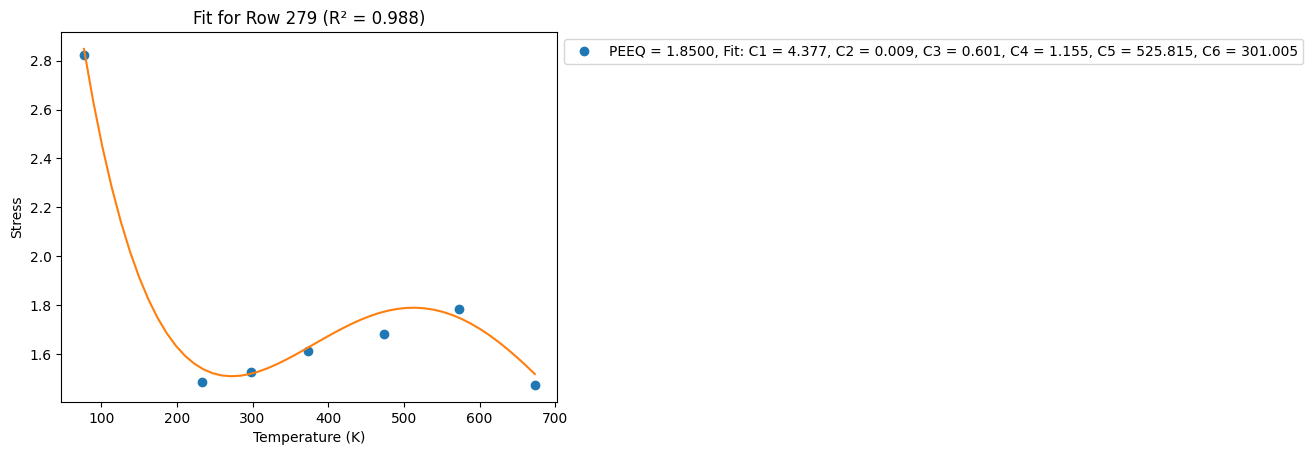

[2.82856798 1.48465395 1.52524838 1.61518825 1.68091352 1.7872454
 1.47470605]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


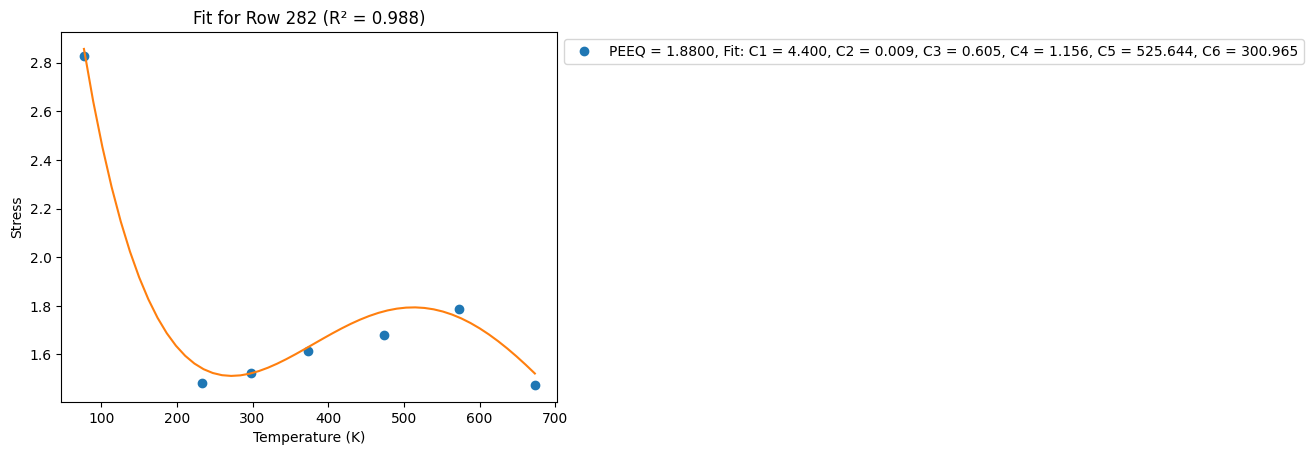

/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


[2.8355048  1.48471382 1.52583258 1.61653638 1.68204251 1.78881252
 1.47593464]


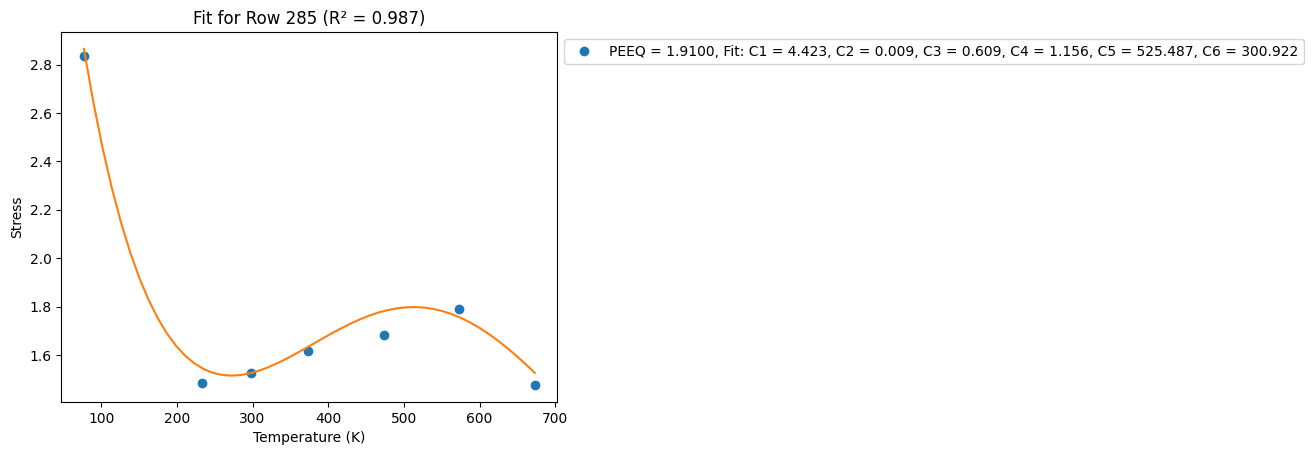

[2.84236626 1.48477196 1.52640573 1.61786341 1.68315215 1.79035366
 1.47714399]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


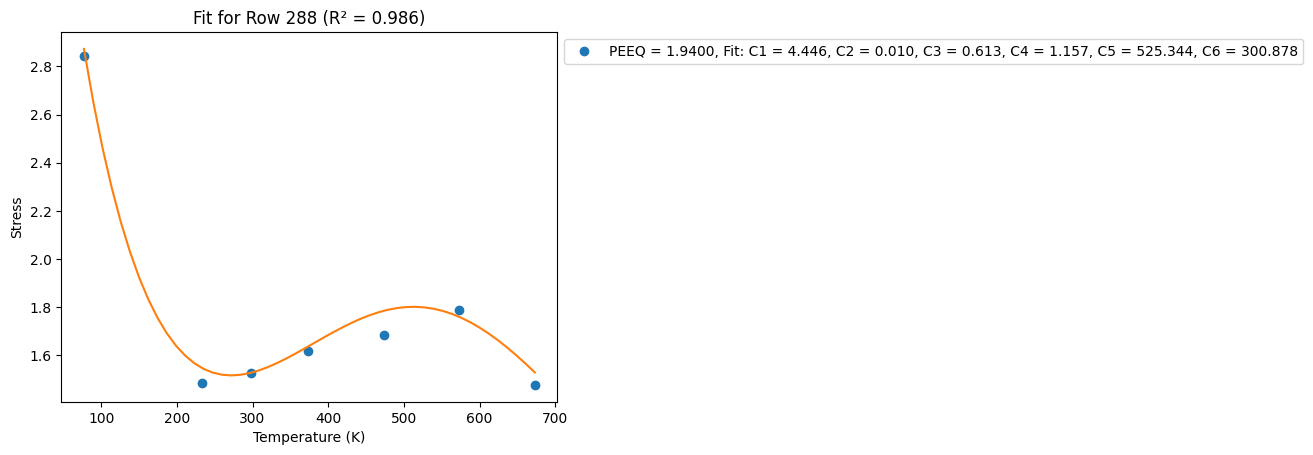

[2.84915434 1.48482843 1.52696819 1.61916999 1.68424307 1.79186965
 1.47833468]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


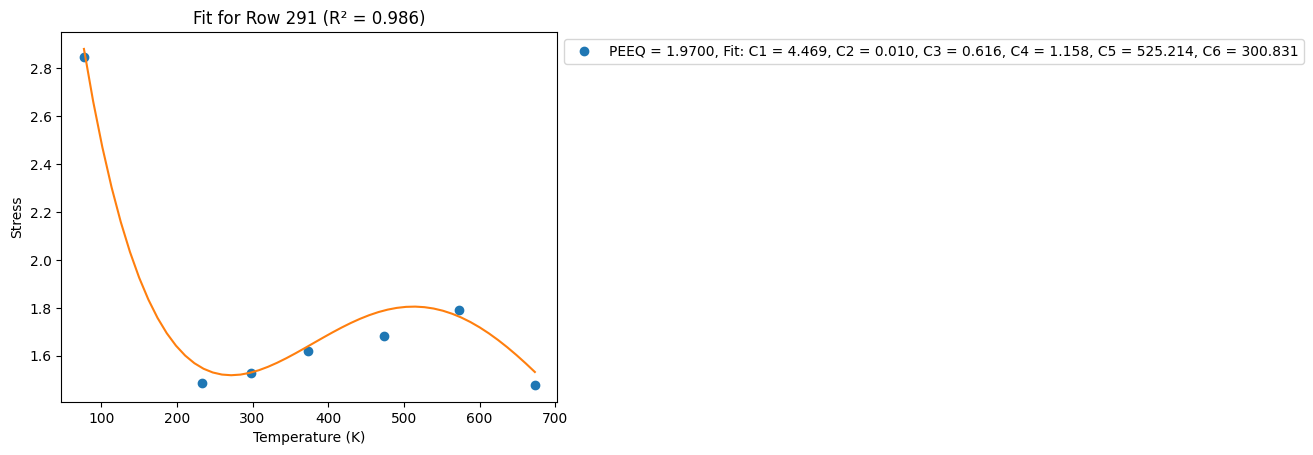

[2.85587092 1.48488332 1.52752035 1.62045676 1.68531587 1.79336128
 1.47950729]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


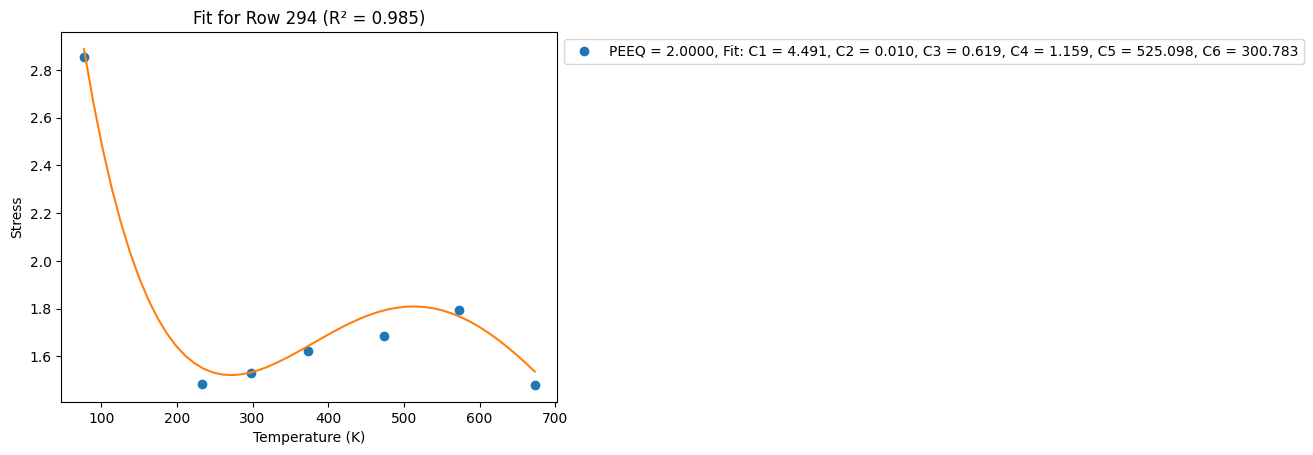

[2.86251782 1.48493668 1.52806252 1.6217243  1.6863711  1.79482928
 1.48066235]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


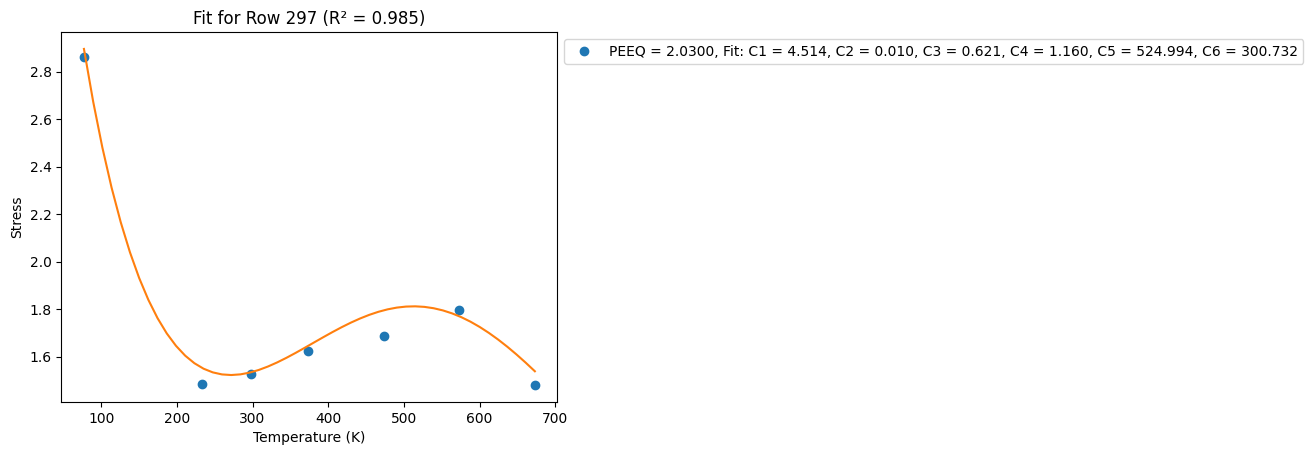

[2.86909678 1.48498859 1.52859504 1.62297318 1.68740932 1.79627438
 1.48180039]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


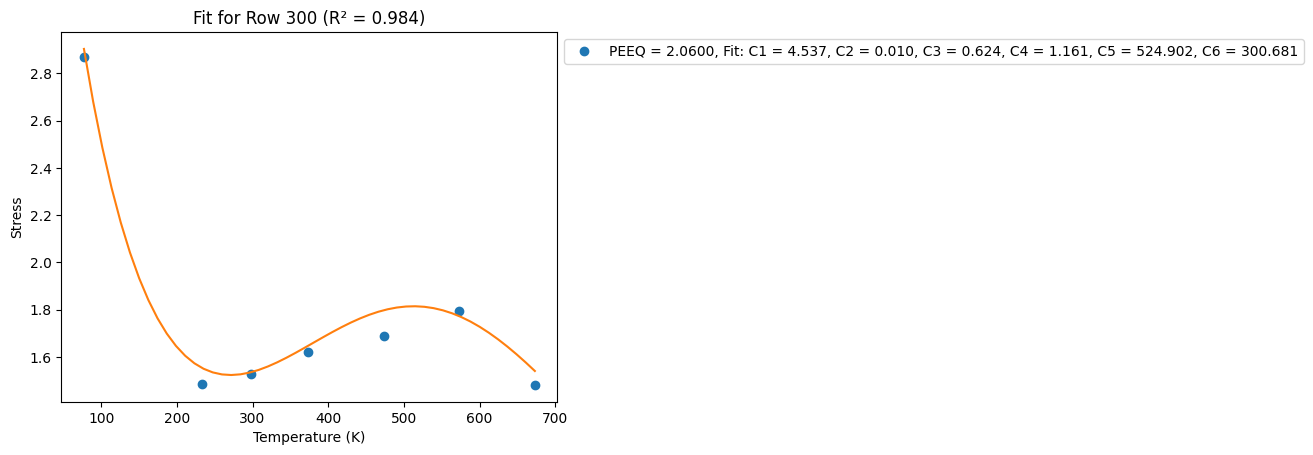

[2.87560947 1.4850391  1.52911821 1.62420393 1.68843105 1.79769727
 1.48292189]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


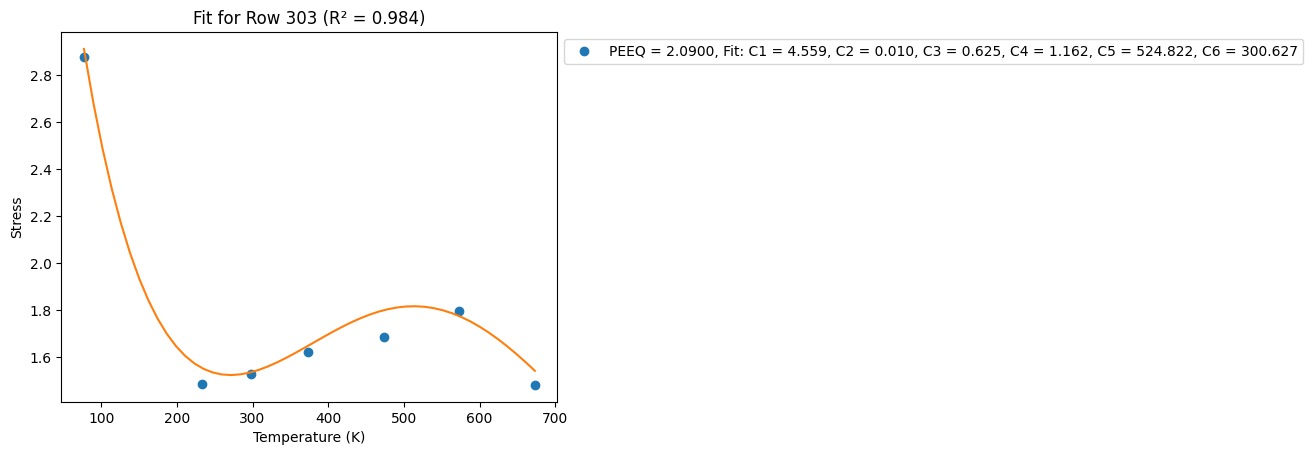

[2.8820575  1.48508827 1.52963233 1.62541709 1.68943676 1.7990986
 1.48402734]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


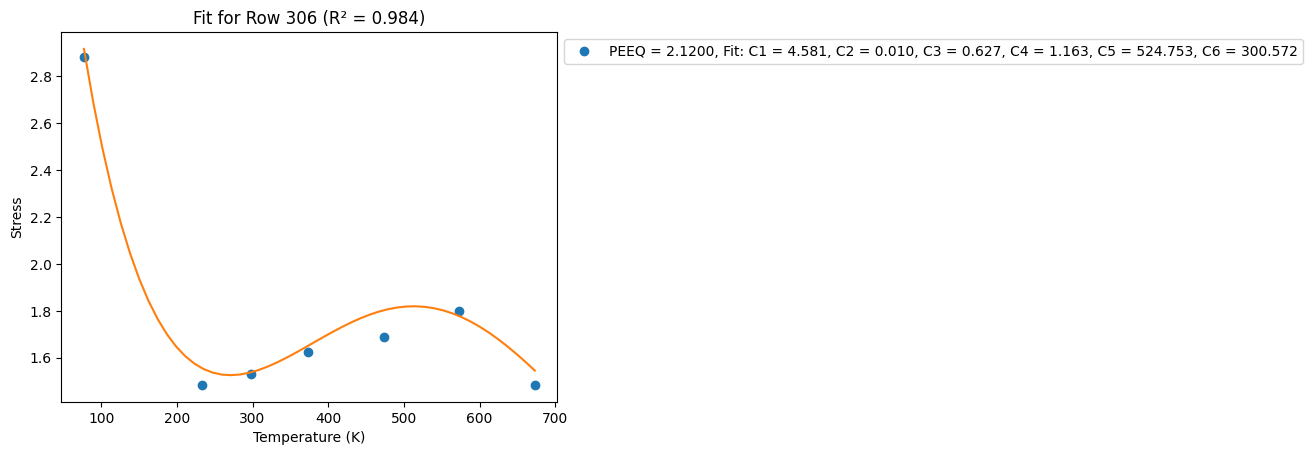

[2.88844242 1.48513615 1.53013769 1.62661314 1.69042695 1.80047898
 1.48511719]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


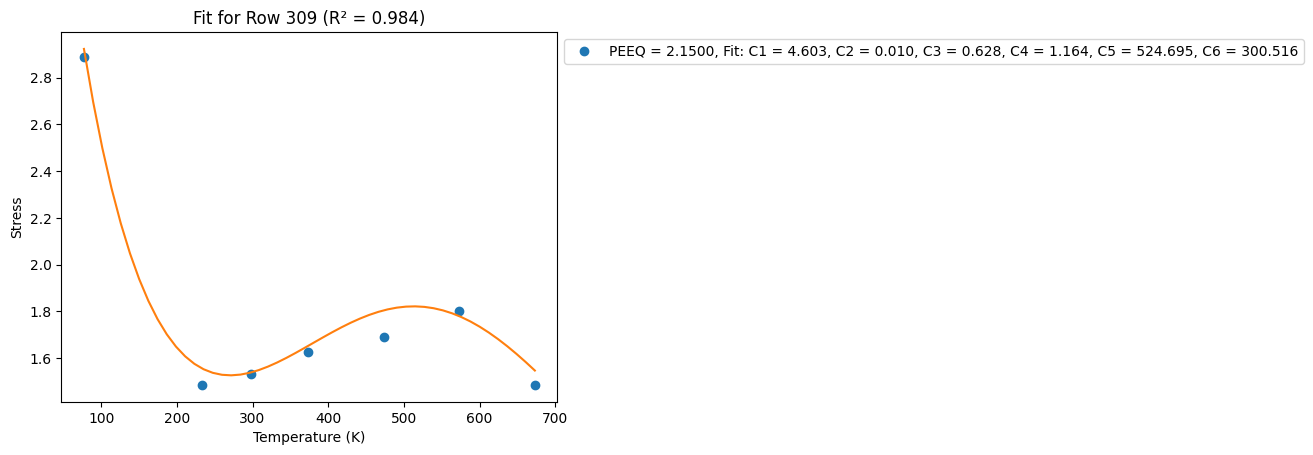

[2.89476573 1.4851828  1.53063455 1.62779256 1.69140205 1.80183904
 1.48619186]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


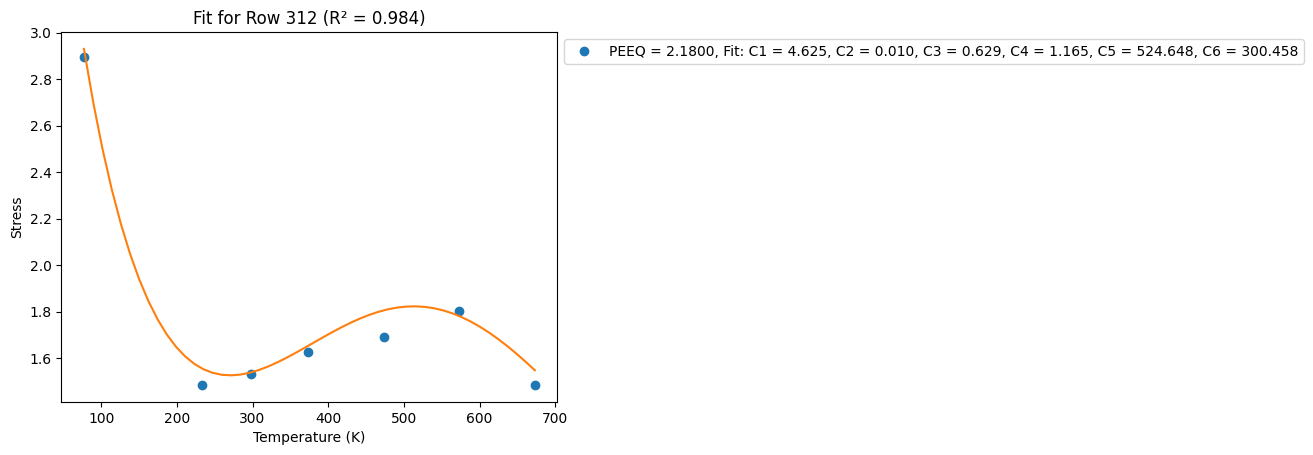

[2.90102884 1.48522826 1.53112317 1.62895581 1.69236252 1.80317933
 1.48725178]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


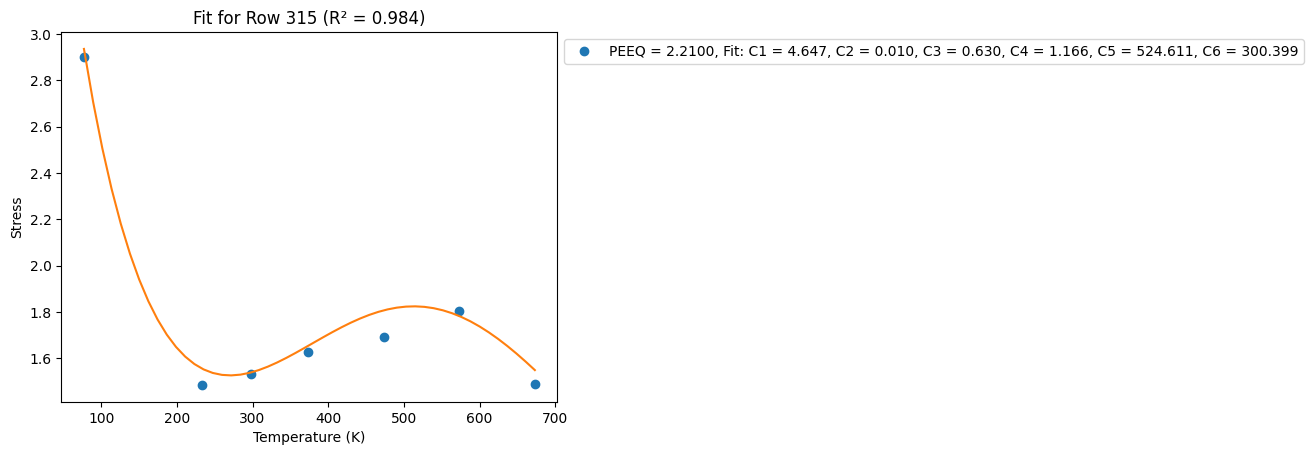

[2.90723315 1.48527257 1.53160379 1.63010332 1.69330874 1.80450041
 1.48829734]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


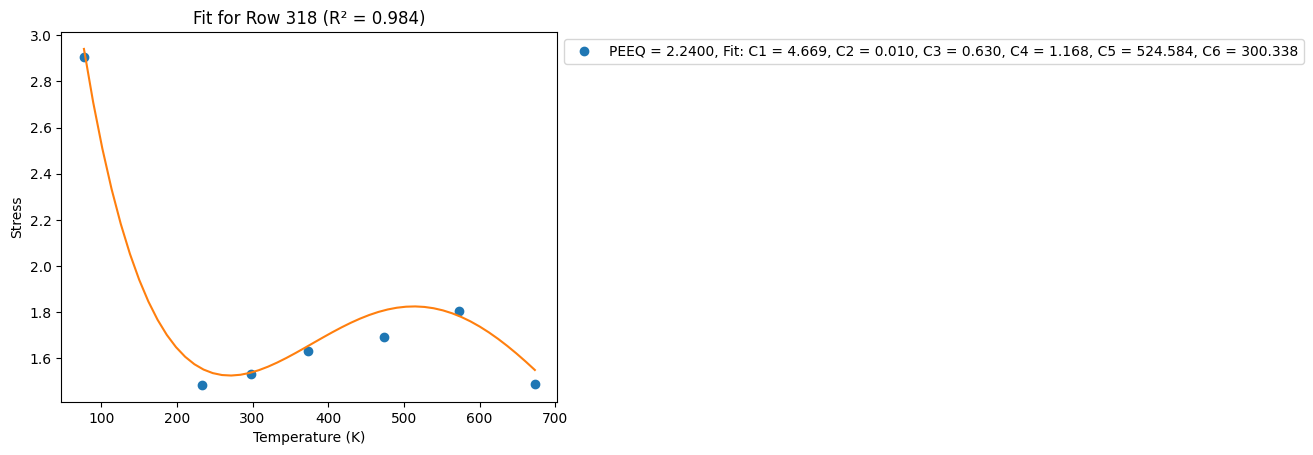

[2.91337999 1.48531579 1.53207666 1.63123552 1.69424114 1.80580281
 1.48932894]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


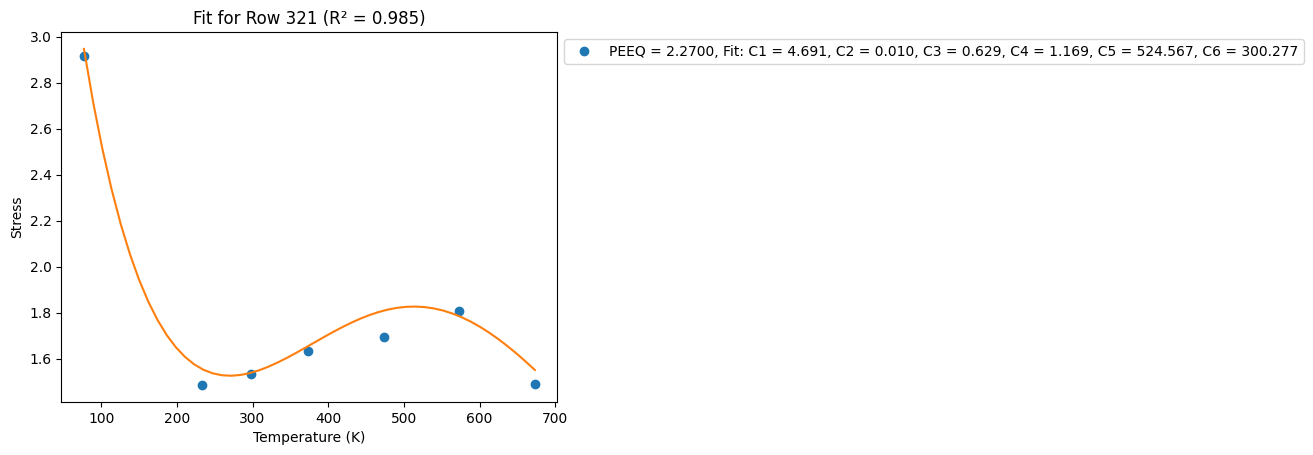

[2.91947064 1.48535795 1.53254199 1.63235281 1.69516009 1.80708704
 1.49034693]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


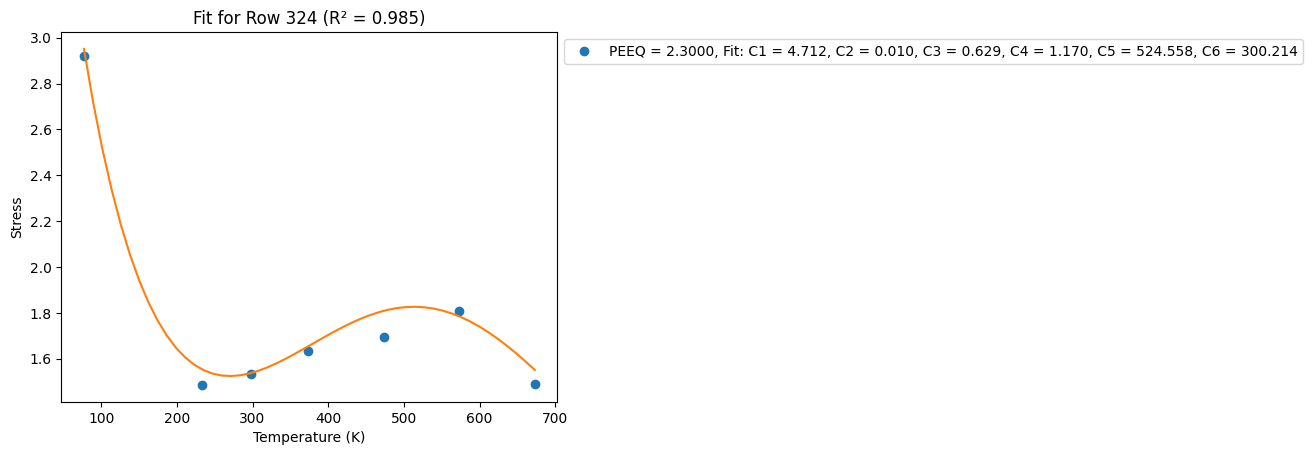

[2.92550635 1.4853991  1.53300001 1.63345558 1.69606595 1.80835358
 1.49135168]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


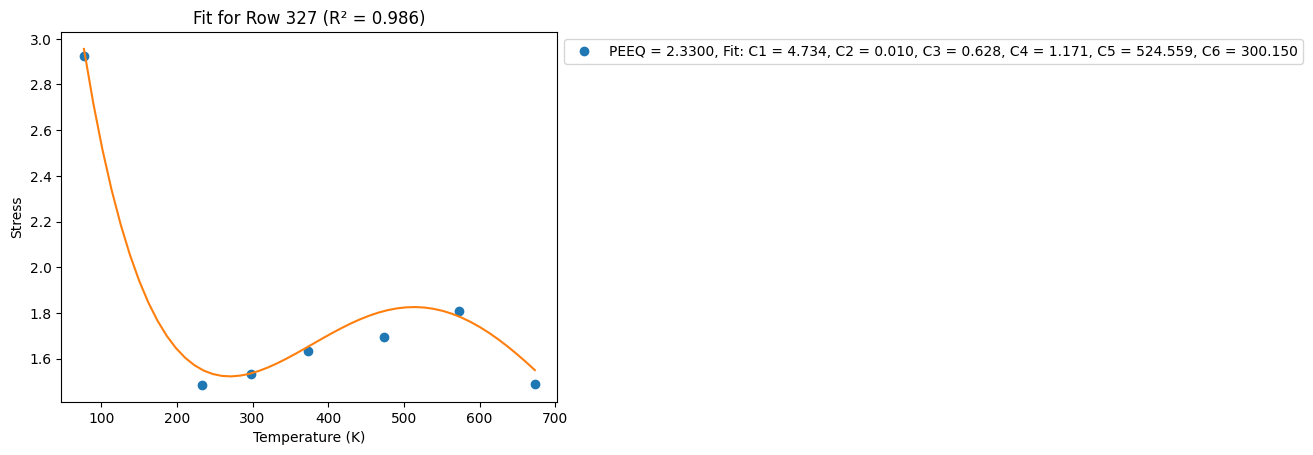

[2.9314883  1.48543926 1.53345092 1.6345442  1.69695908 1.80960289
 1.49234352]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


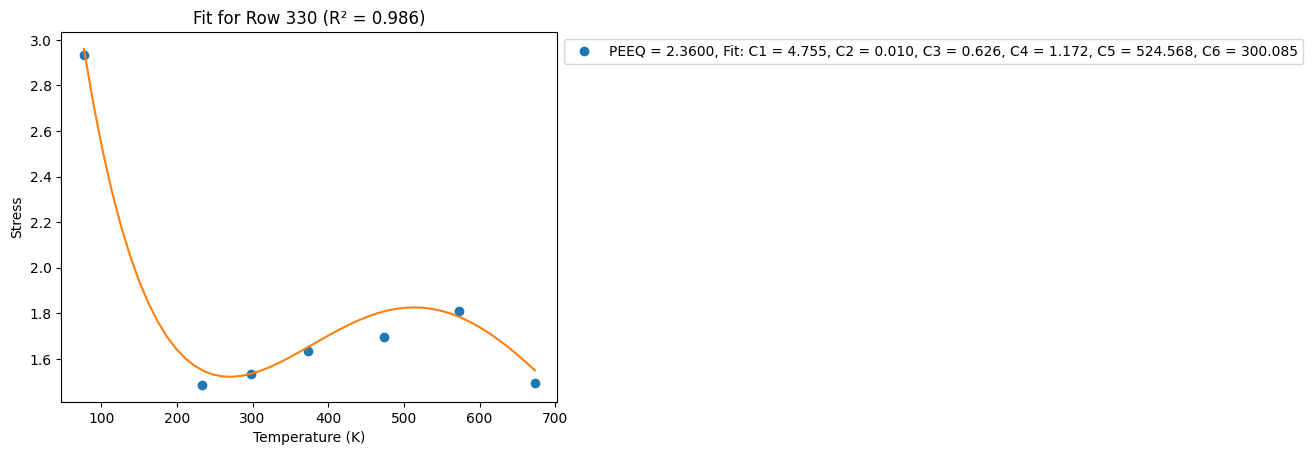

[2.93741766 1.48547848 1.53389491 1.63561902 1.69783981 1.81083544
 1.49332277]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


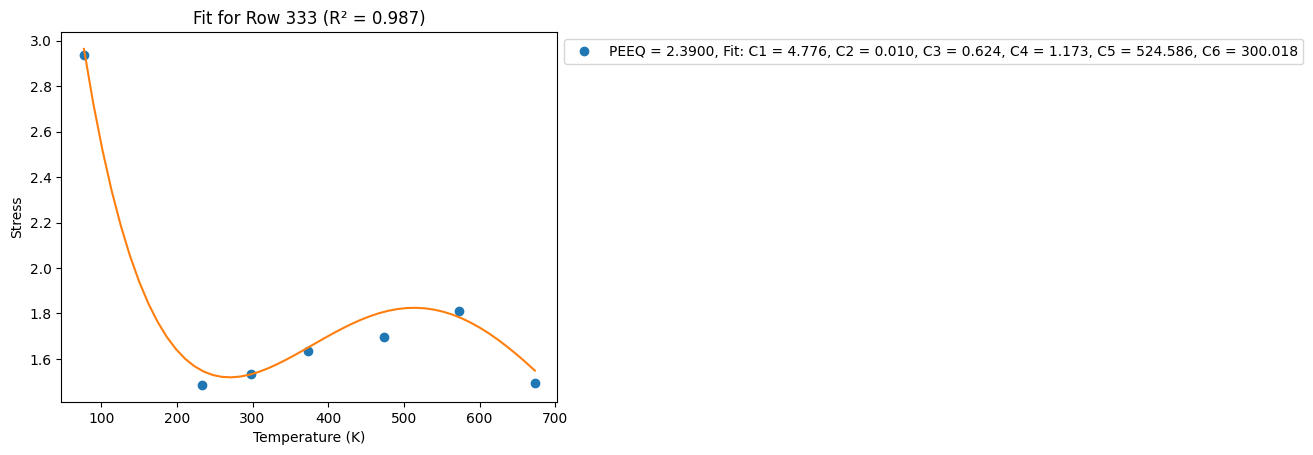

[2.94329554 1.48551679 1.53433219 1.6366804  1.69870848 1.81205164
 1.49428977]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


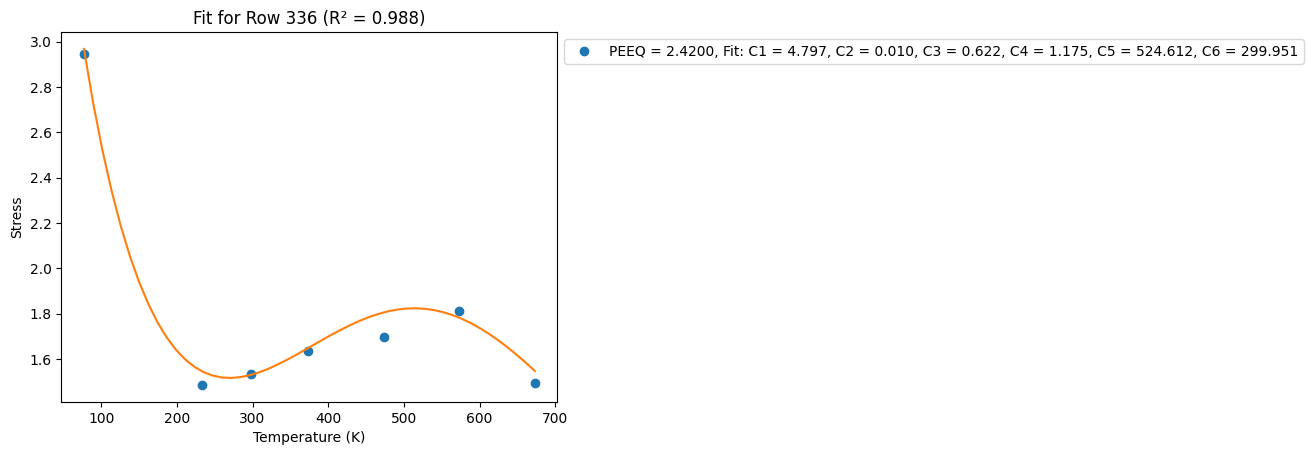

[2.94912302 1.48555421 1.53476293 1.63772867 1.69956538 1.81325192
 1.4952448 ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


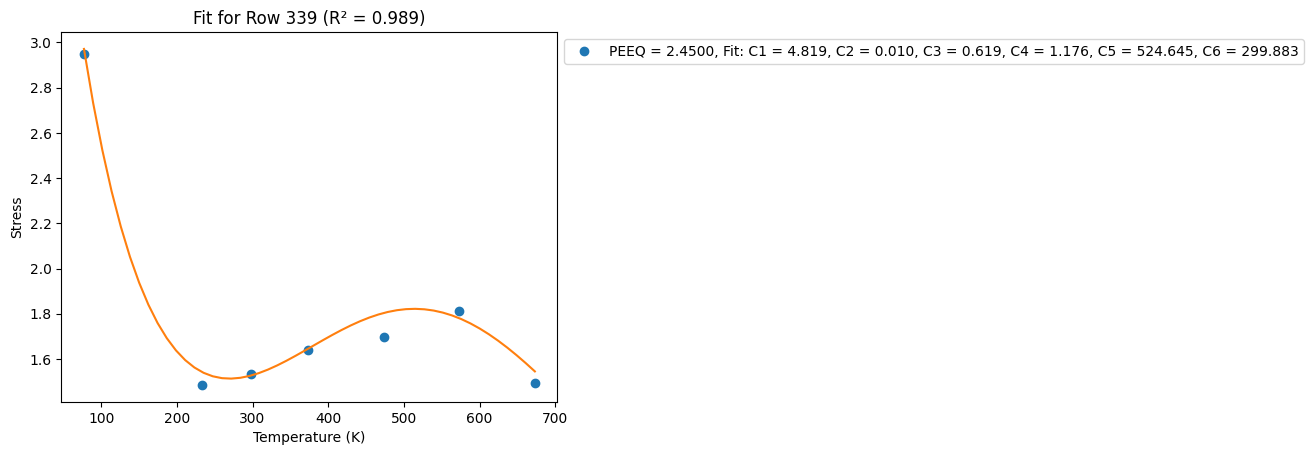

[2.95490114 1.48559079 1.53518732 1.63876414 1.70041084 1.81443668
 1.49618816]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


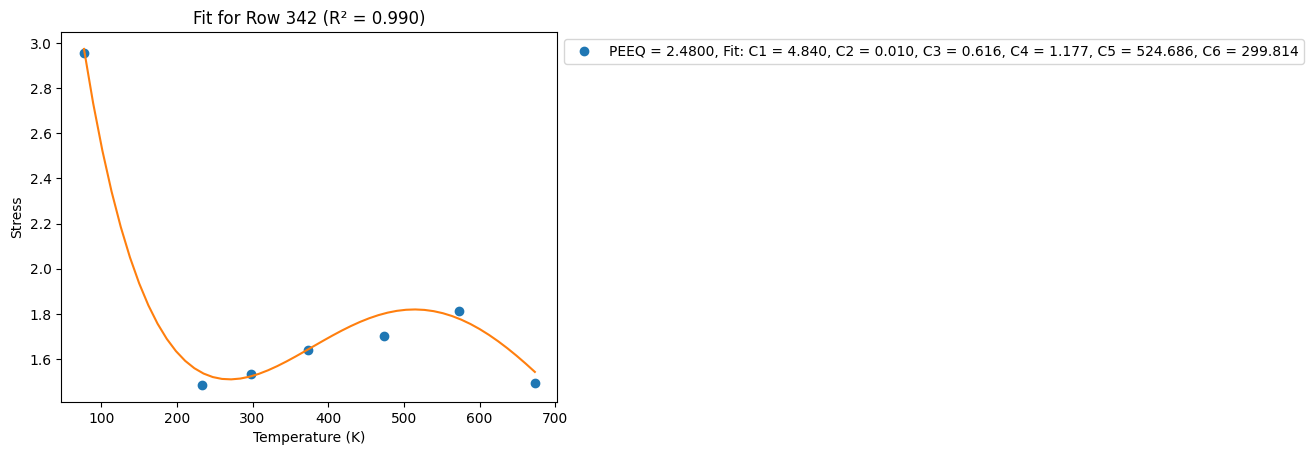

[2.96063092 1.48562655 1.53560551 1.63978713 1.70124512 1.8156063
 1.49712013]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


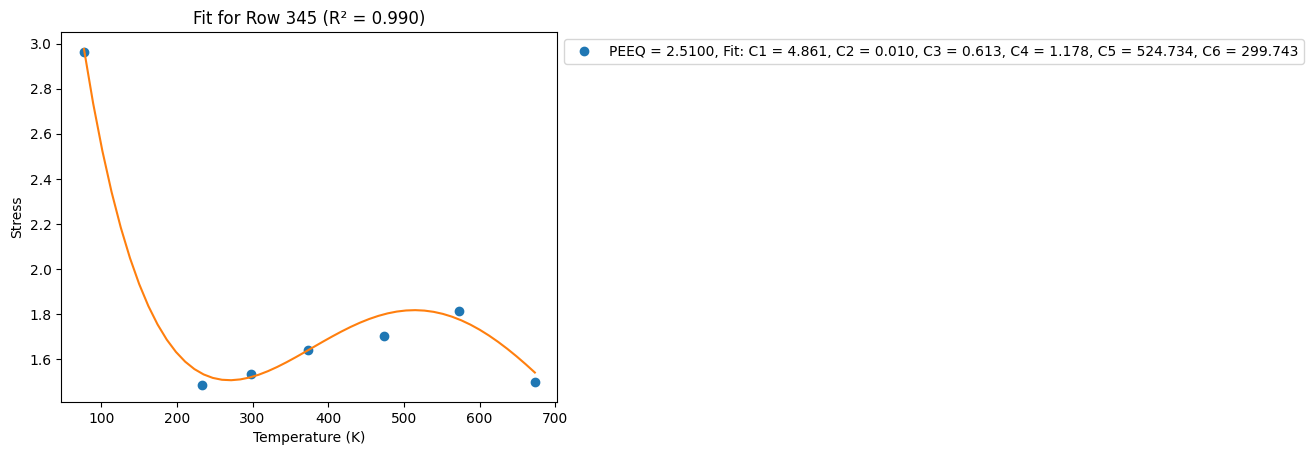

[2.96631333 1.48566152 1.53601768 1.64079793 1.70206852 1.81676116
 1.49804099]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


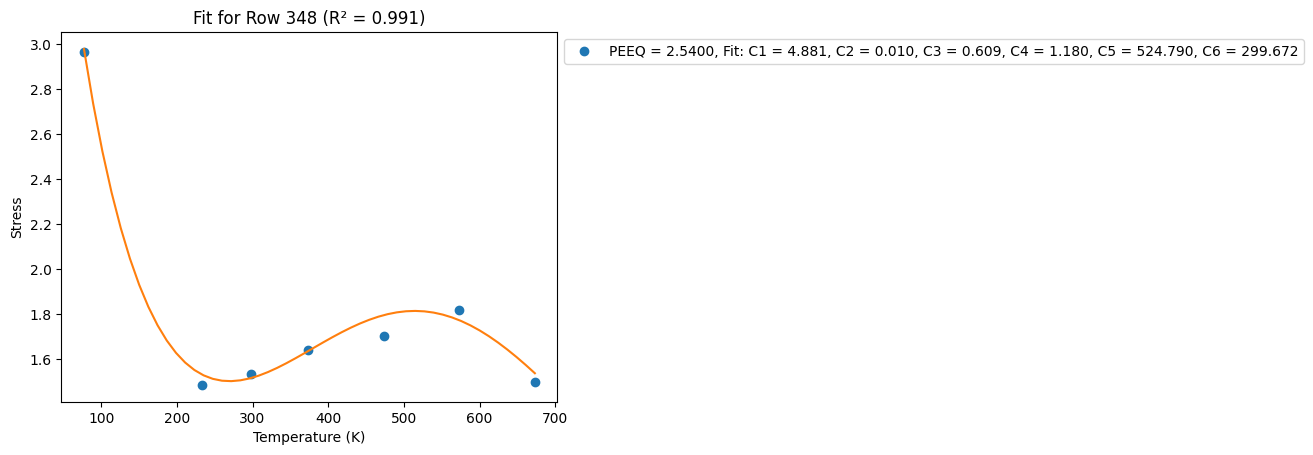

[2.97194932 1.48569572 1.53642397 1.64179684 1.70288129 1.81790161
 1.498951  ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


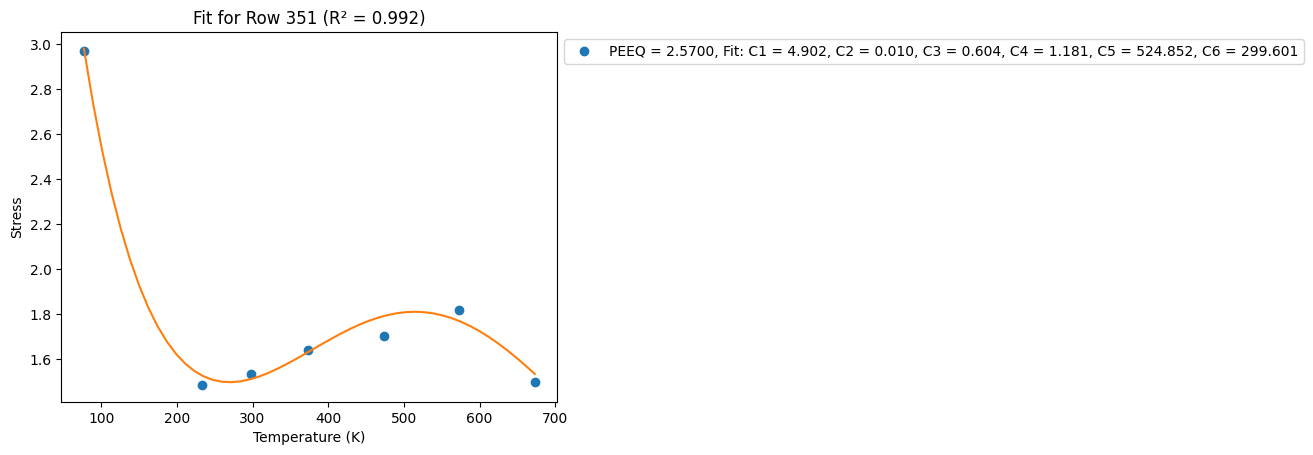

[2.97753981 1.48572919 1.53682455 1.64278412 1.70368371 1.819028
 1.4998504 ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


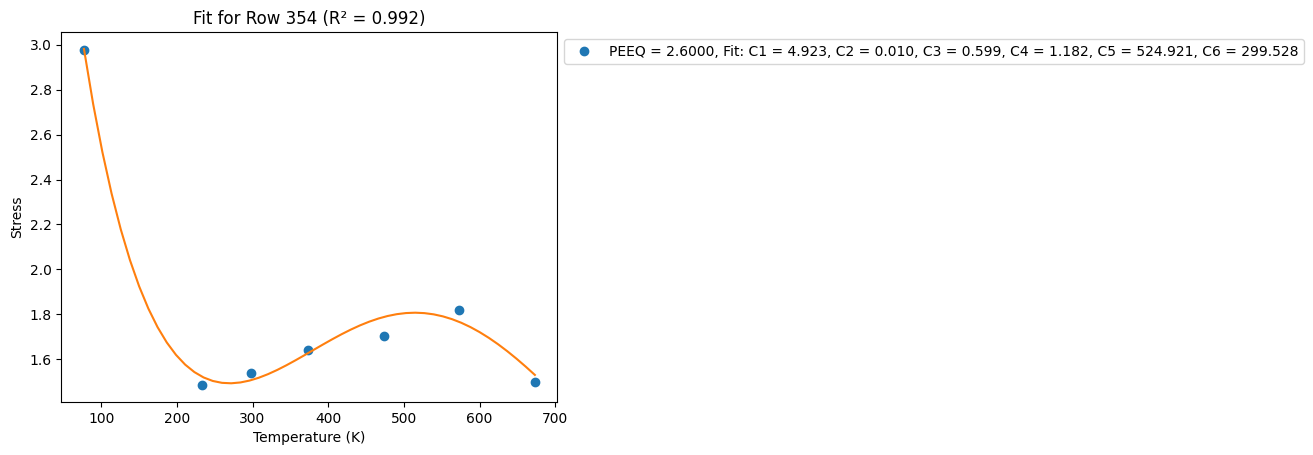

[2.98308568 1.48576193 1.53721955 1.64376004 1.70447601 1.82014066
 1.50073945]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


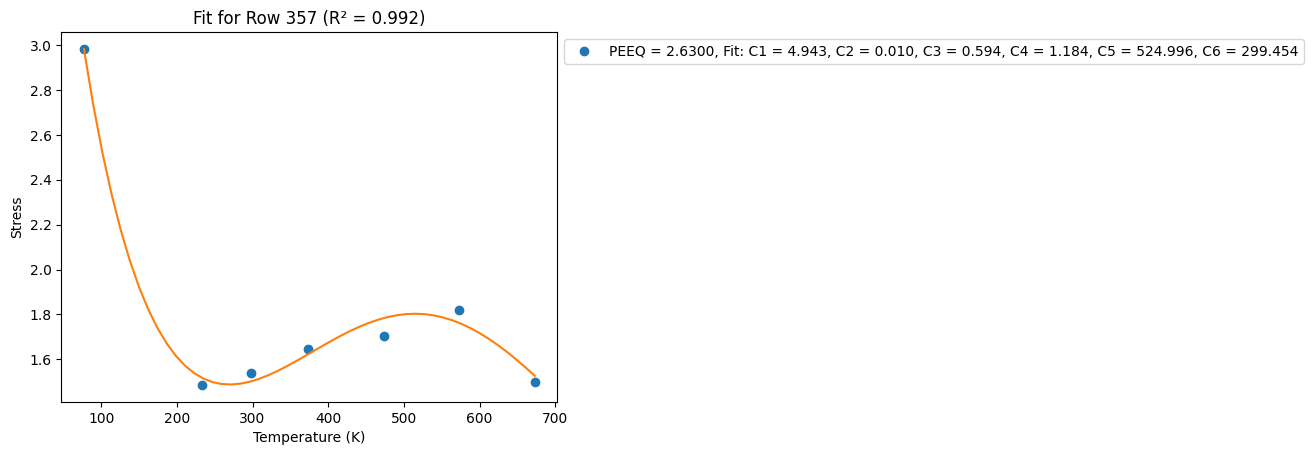

[2.98858779 1.48579399 1.53760912 1.64472487 1.70525845 1.82123991
 1.50161837]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


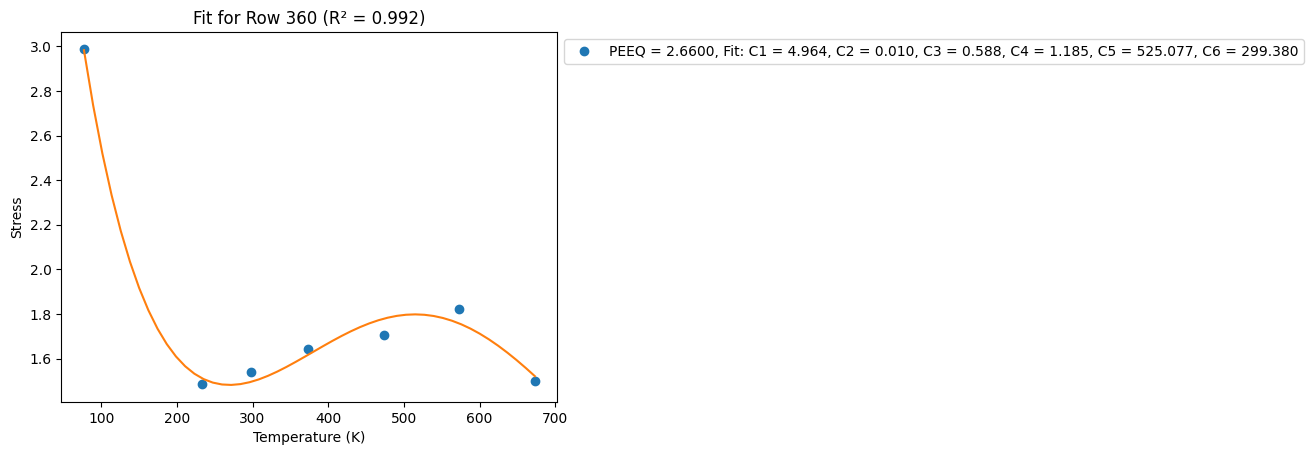

[2.99404698 1.48582538 1.53799339 1.64567885 1.70603125 1.82232606
 1.50248741]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


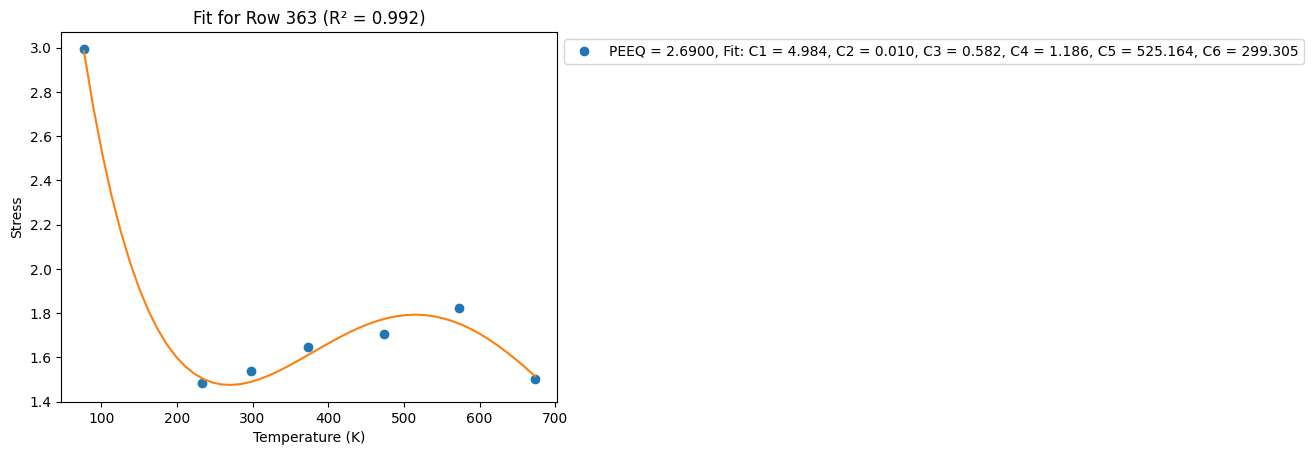

[2.99946406 1.48585611 1.53837249 1.64662223 1.70679464 1.82339942
 1.50334677]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


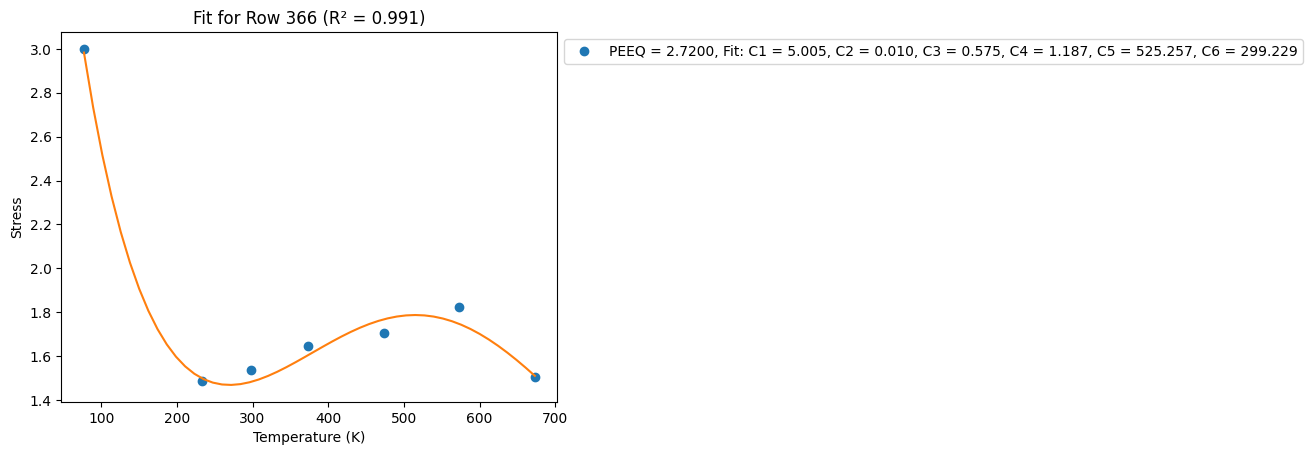

[3.00483981 1.48588622 1.53874655 1.64755523 1.70754883 1.82446027
 1.50419667]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


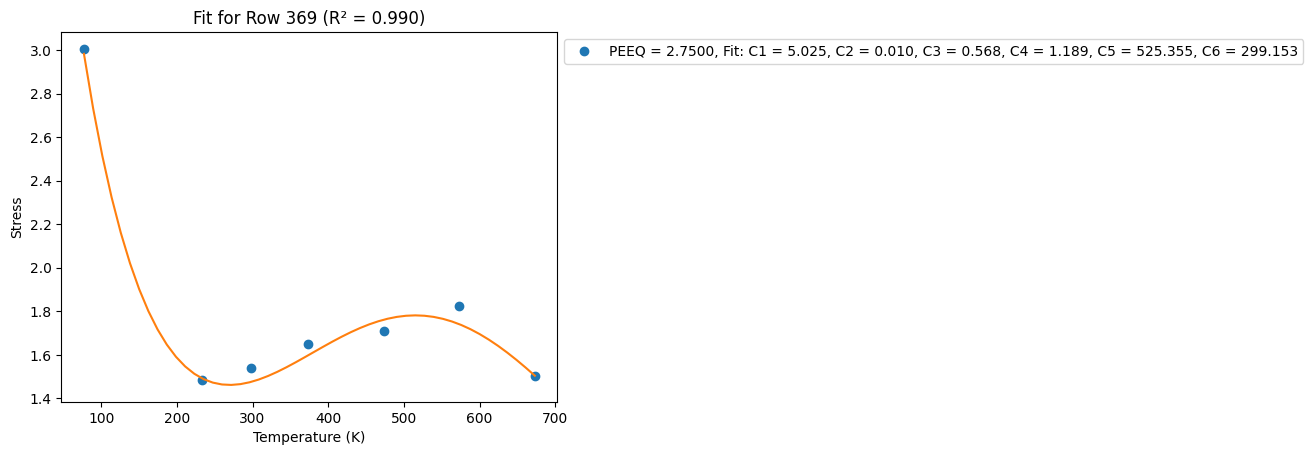

[3.010175   1.48591572 1.53911568 1.64847809 1.70829403 1.8255089
 1.50503732]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


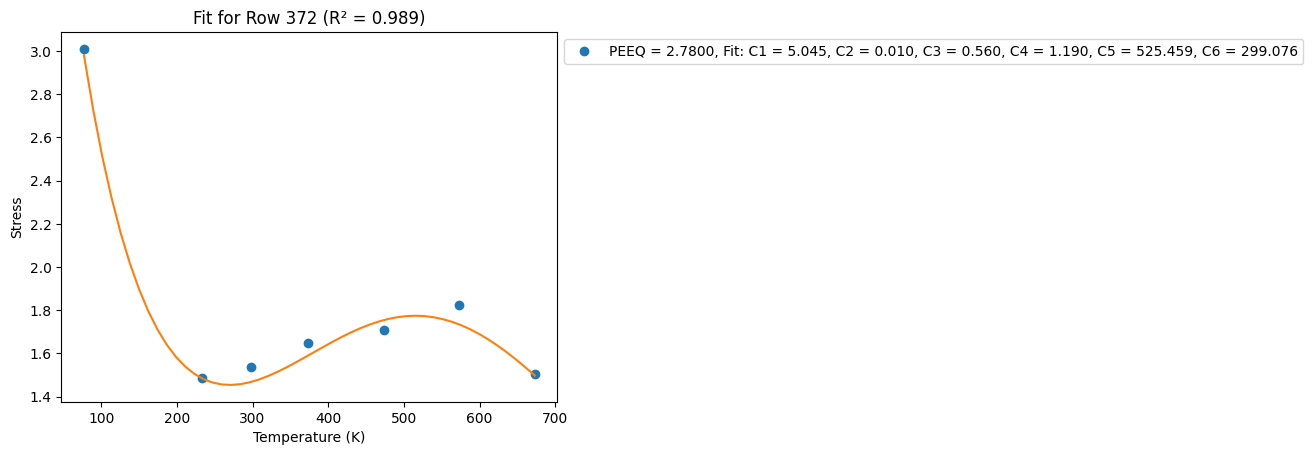

[3.01547037 1.48594463 1.53948001 1.64939101 1.70903045 1.82654557
 1.50586891]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


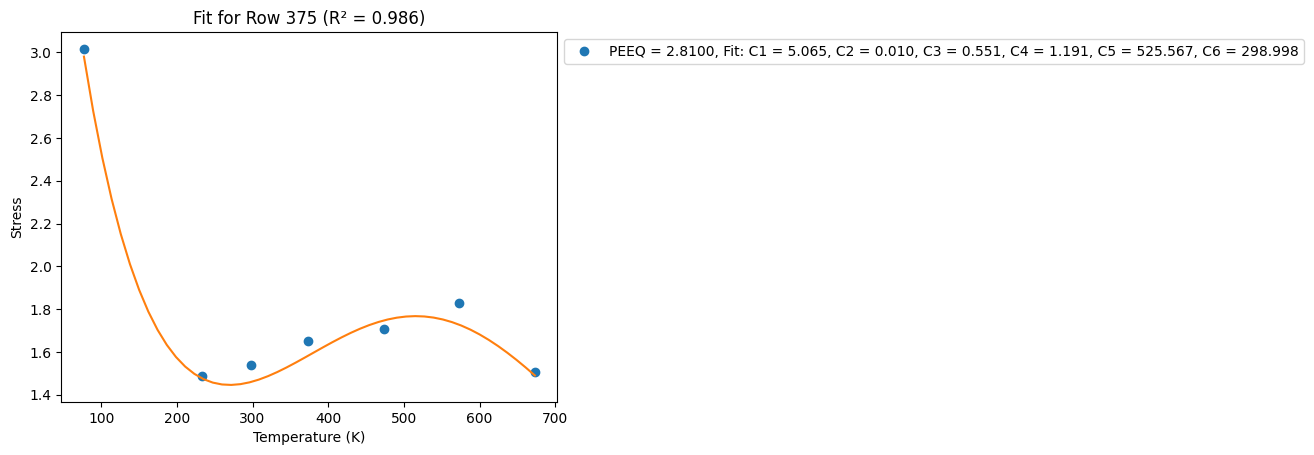

[3.02072664 1.48597297 1.53983965 1.65029423 1.70975828 1.82757055
 1.50669164]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


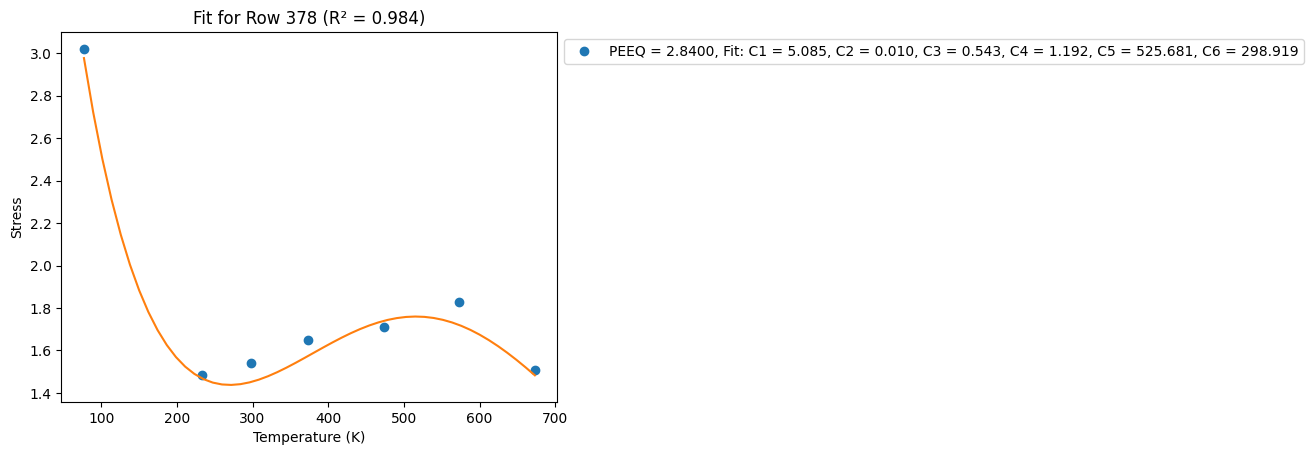

[3.0259445  1.48600075 1.54019471 1.65118793 1.71047772 1.82858408
 1.5075057 ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


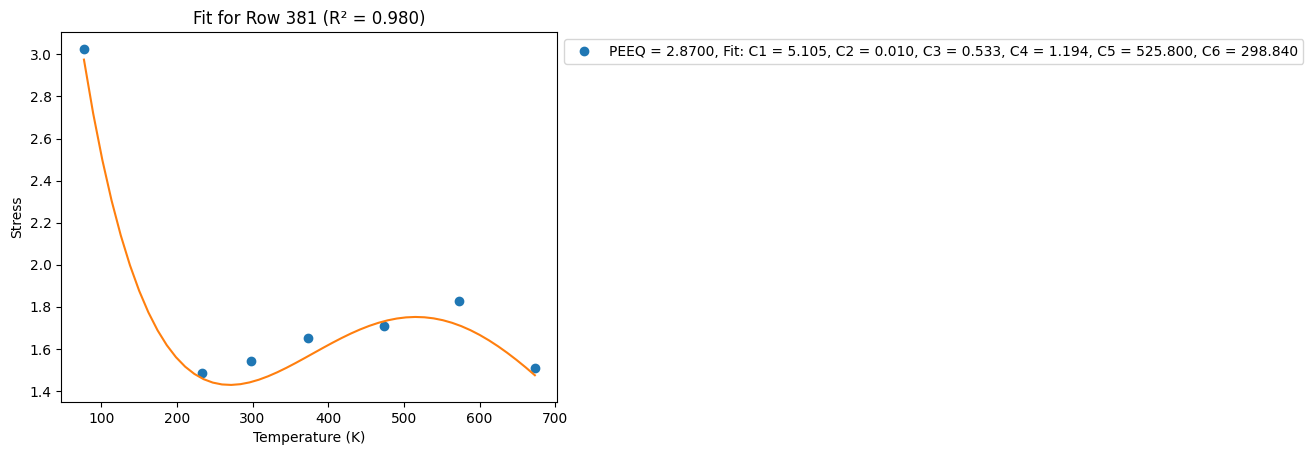

[3.03112463 1.48602799 1.54054528 1.65207231 1.71118894 1.82958643
 1.50831126]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


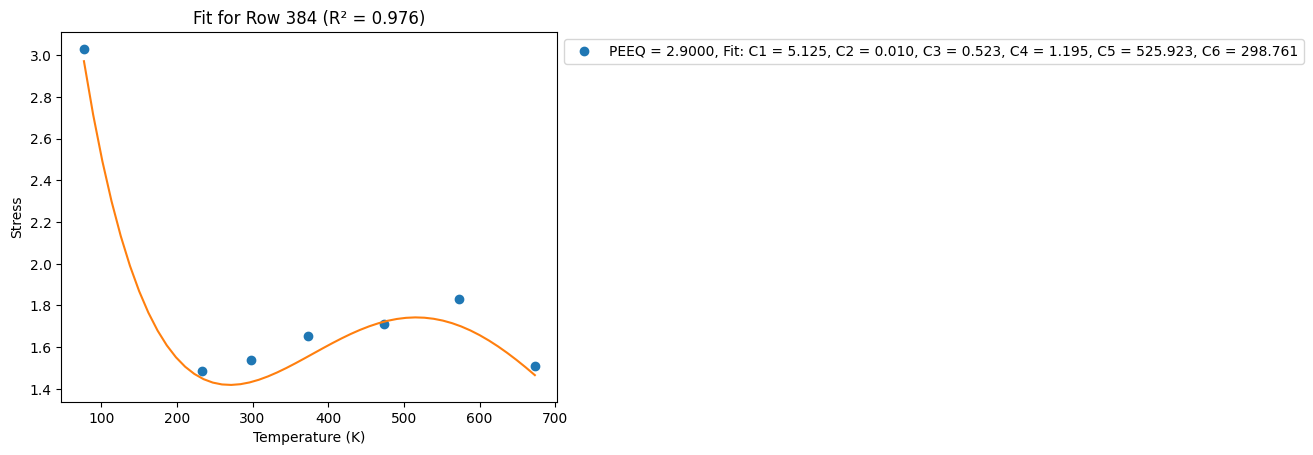

[3.0362677  1.48605472 1.54089149 1.65294758 1.71189213 1.83057782
 1.50910851]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


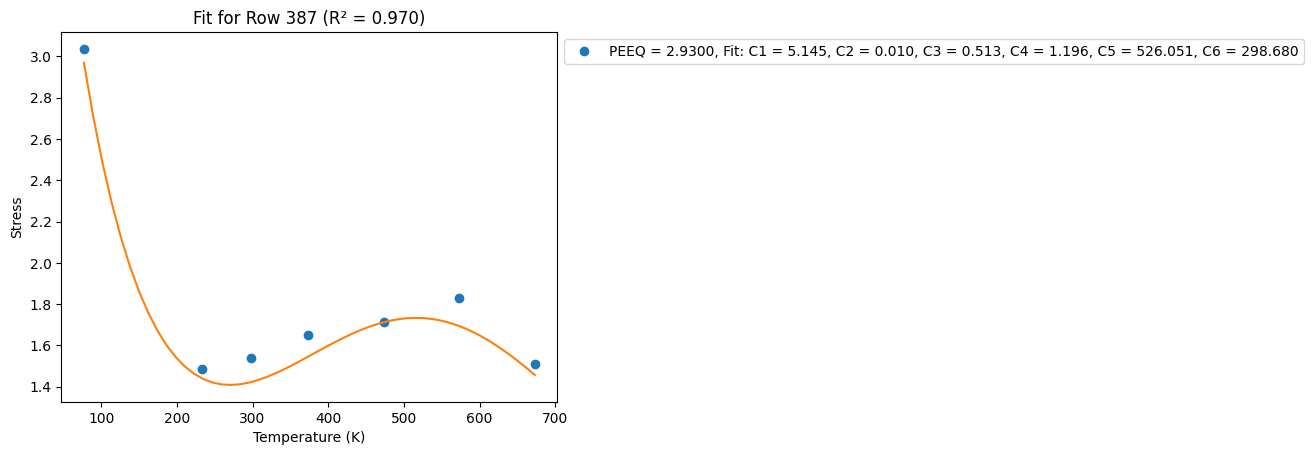

[3.04137435 1.48608093 1.54123341 1.65381391 1.71258744 1.83155848
 1.5098976 ]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


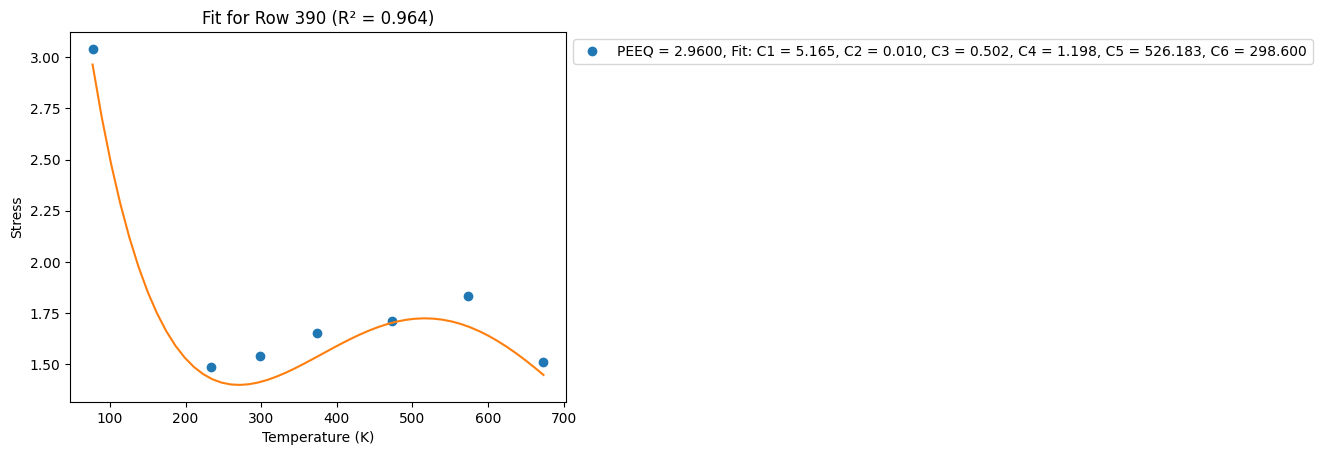

[3.04644519 1.48610665 1.54157116 1.65467149 1.71327507 1.83252864
 1.51067872]


/tmp/ipykernel_11901/2252662410.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


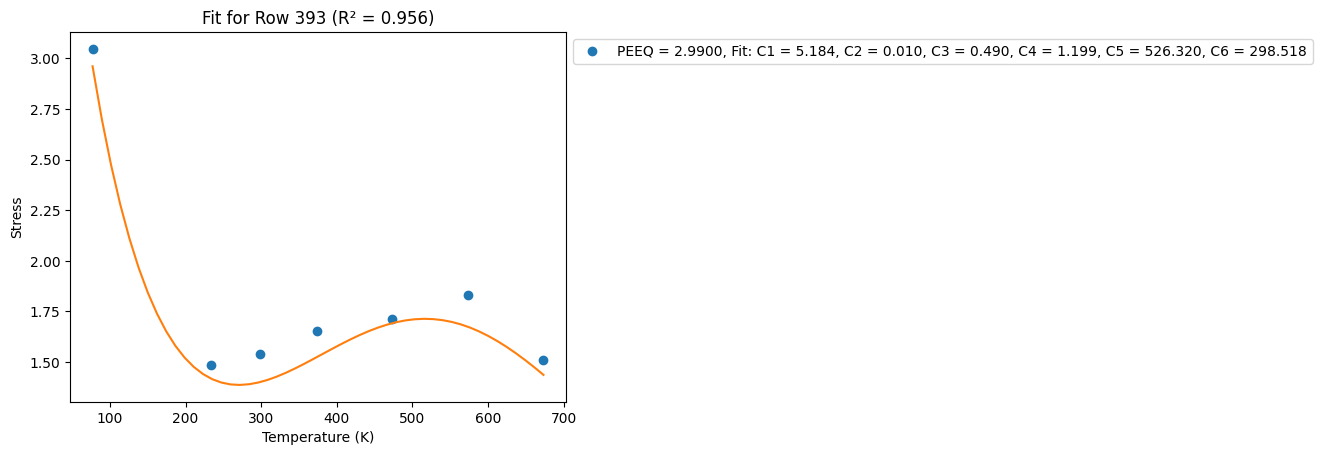

In [24]:
# Temperarute data points
T = np.array([77.15, 233.15, 298.15, 373.15, 473.15, 573.15, 673.15])

# Temperature function
def f_func(T, cT1, cT2, cT3, cT4, cT5, cT6):
    return cT1*(np.exp(-cT2*T))+cT3+cT4*(np.exp(-((T-cT5)/cT6)**2))

for j, i in enumerate(np.arange(0,394,3)):
    T_fit = np.linspace(np.min(T), np.max(T), 50)
    [C1, C2, C3, C4, C5, C6] = fitted_para.iloc[i, 1:]
    y = stress_data.iloc[i, 8:].values
    print(y)
    gaussian_fit = f_func(T_fit, C1, C2, C3, C4, C5, C6)

    # Calculate residuals for error estimation
    y_pred = f_func(T, C1, C2, C3, C4, C5, C6)
    r_squared = r2_score(y, y_pred)

    plt.plot(T, y, 'o', T_fit, gaussian_fit)
    plt.xlabel("Temperature (K)")
    plt.ylabel("Stress")
    plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
    plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
else:
    str(0)